# Simulated Annealing

##### Keywords: simulated annealing, markov chain, proposal, statistical mechanics, temperature, boltzmann distribution, energy, optimization, global minimum, combinatoric optimization

## Contents
{:.no_toc}
* 
{: toc}

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

## The basic physics

Simulated Annealing is one of the most popular techniques for global optimization. 

In physical annealing, a system is first heated to a melting state and then cooled down slowly.

When the solid is heated, its molecules start moving randomly, and its energy increases. If the
subsequent process of cooling is slow, the energy of the solid decreases slowly, but there are also random increases in the energy governed by the Boltzmann distribution (see below). If the cooling is slow enough, and deep enough to unstress the solid, the system will eventually
settle down to the lowest energy state where all the molecules are arranged to have minimal potential energy. 

Suppose we have a function whose global optimum(minimum) needs to be found. We identify this function with the energy of an imaginary physical system undergoing an annealing process. Then, at the end the global minimum of the system is function is reached.

Why do we not get stuck in local  minima?

Our process repeats a loop where the temperature is decreased in every loop cycle. Within each loop, the algorithm mimics the cooling process of the system by making random changes to the current value of the position along the function, and thus the value of the function, the energy. This is reminiscent of particles in the physical system randomly moving to a corner of a jar, or some magnetizations changing.

Suppose the system is in a state with energy $E_i$ (function at current $x_i$ has value $E_i$) and subsequent to the random fluctuation to position $x_j$, now has energy state $E_j$.
We denote the change in the energy due to the state change as $\Delta E = E_j-E_i$. 

The move to the new position $x_j$ is done via a **proposal**.

If the new state has lower energy than the current state, we go into this new state. This way we are making our way towards a minimum of the function. But what if the new state has higher energy?

In this case, the new state is accepted with probability equal to 

$$A=\exp{ ( -\Delta f/kT)}$$ 

where $k$ is the Boltzmann constant and $T$ is the 
temperature.  If this number is say, 0.7, we'll move to this new state  70% of the time. In other words, we;ll throw a uniform between 0 and 1, and if its less than 0.7, we'll move to, or "accept" the new state, updating the position and energy. If the uniform random number is higher than 0.7, we stay put.

This stochastic acceptance of higher energy states, allows our process to escape local minima.

When the temperature is high, the acceptance of these uphill moves is higher, as the exponent gets closer to 0 and thus the acceptance probability closer to 1. This means that higher local minima are discouraged.

As the temperature is lowered, there will be more concentrated search effort near the current local minimum, since only few uphill moves will be allowed. Thus, if we get our temperature decrease schedule right, we can hope that we will converge to a global minimum.

If the lowering of the temperature is sufficiently slow, the system reaches "thermal equilibrium" at each temperature. This is the scenario which justifies the use of the acceptance probability above, since a physical system in equilibrium has a probability distribution of its energy states given by

$$p(X=i) = \frac{1}{Z(T)} \exp{ \left( \frac{-E_i}{kT}\right) }$$
 
 where 
 
 $$Z(T) = \sum_j \exp{ \left( \frac{ -E_j}{kT}\right)}$$
 
 is the normalization constant of the distribution, also called the partition function. (one can treat this as a continuous distribution as well).

What about the role of the proposal? The proposal proposes a new position x from a **neighborhood** $\cal{N}$ at which to evaluate the function. The important criterion for it is that all the positions x in the domain we wish to minimize a function $f$ over ought to be able to communicate. In other words, any position should be reachable from any other in a finite sequence of operations: every next position should be in the neighborhood of the previous one and the sequence of such moves should be finite. It is otherwise possible that we cant reach some parts of the space, and the minimum may specifically like there.

## An example

Let us consider the example of a function with one global minimum and many local minima.

In [2]:
f = lambda x: x**2 + 4*np.sin(2*x)

[Wolfram Alpha](http://bit.ly/2lTPKsB) is a useful way to get info on this function, but here is what it looks like...

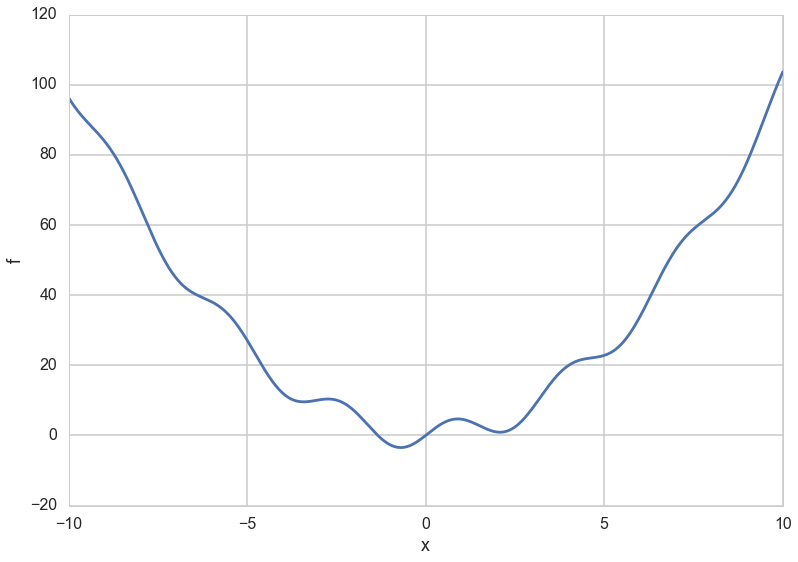

In [4]:
xs = np.linspace(-10.,10.,1000)
plt.plot(xs, f(xs));
plt.xlabel('x')
plt.ylabel('f')

##  Cooling Schedule and convergence

The sequence of temperatures we use (we'll call the iterations for each temperature an **epoch**), and the number of iterations at each temperature, called the stage length, constitute the cooling schedule.

Why do we think we will reach a global minimum? For this we'll have to understand the structure of the sequence of positions simulated annealing gives us. We'll see this in more detail later, but, briefly, simulated annealing produces either a set of homogeneous markov chains, one at each temperature or a single inhomogeneous markov chain.

Now, assume that our proposal is symmetric: that is proposing $x_{i+1}$ from $x_i$ in $\cal{N}(x_i)$ has the same probability as  proposing $x_{i}$ from $x_{i+1}$ in $\cal{N}(x_{i+1})$. This *detailed balance* condition ensures that the sequence of $\{x_t\}$ generated by simulated annealing is a stationary markov chain with the boltzmann distribution as the stationary distribution of the chain as $t \to \infty$. Or, in physics words, you are in equilibrium (with detailed balance corresponding to the reversibility of the isothermal process).

Then the appropriately normalized Boltzmann distribution looks like this (assuming M global minima (set $\cal{M}$) with function value $f_{min}$):

$$ p(x_i) = \frac{e^{-(f(x_i) - f_{min})/T}}{M + \sum_{j \notin  \cal{M}} e^{-(f(x_i) - f_{min})/T}}$$

Now as $T \to 0$ from above, this becomes $1/M$ if $x_i \in \cal{M}$ and 0 otherwise.

We will talk more about markov chains soon, they are at the root of MCMC which is very similar to  simulated annealing.

If you think of our example in terms of the Boltzmann probability distribution as the stationary distribution, then you can identify

$$p_{T}(x) = e^{-f(x)/T}$$ 

as the probability distribution we get down to.  Specifically let $p(x) = p_{1}(x)$. Then $f(x) = - log(p(x))$ and we can think of this in terms of our usual likelihoods and risks and energies. But even more interesting:

$$P_{T}(x) = P(x)^{1/T}$$

and so you get a peakier and peakier distribution as $T \to 0$ around the global minimum (the globality and the exponentiation ensures that this peak is favored over the rest in the dfunction $f$). You can see this in the diagram below. As $T \to 0$, we get towards a delta function at the optimum and get a global minimum instead of a distribution.

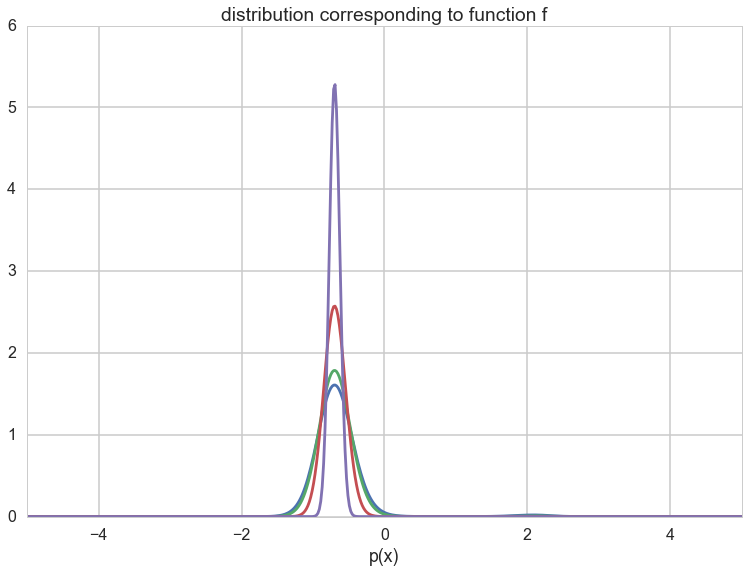

In [6]:
import functools
distx = lambda g, x: np.e**(-g(x))
dxf = functools.partial(distx, f)
outx = np.linspace(-10, 10,1000)
import scipy.integrate as integrate
O=20
plt.plot(outx, dxf(outx)/integrate.quad(dxf,-O, O)[0]);
A=integrate.quad(lambda x: dxf(x)**1.2,-O, O)[0]
plt.plot(outx, (dxf(outx)**1.2)/A);
B=integrate.quad(lambda x: dxf(x)**2.4,-O, O)[0]
plt.plot(outx, (dxf(outx)**2.4)/B);
C=integrate.quad(lambda x: dxf(x)**10,-O, O)[0]
plt.plot(outx, (dxf(outx)**10)/C);


plt.xlim([-5,5])
plt.xlabel('x')
plt.xlabel('p(x)')
plt.title("distribution corresponding to function f")

## The Simulated Annealing Algorithm

1. Initialize $x_i,T, L(T)$ where $L$ is the number of iterations at a particular temperature. 
2. Perform $L$ transitions thus(we will call this an epoch):
    1. Generate a new proposed position $x$
    2. If $x$ is accepted (according to probability $P = e^{(-\Delta E/T)}$, set $x_{i+1} = x_j$, else set $x_{i+1} = x_{i}$  
3. Update T and L 
4. Until some fixed number of epochs, or until some stop criterion is fulfilled, goto 2.

### Proposal

Let us first define our proposal distribution as a normal centers about our current position. In this case we need to figure a width. This is our first case of tuning, the **width** of our neighborhood $\cal{N}$.  Notice that this is a symmetric proposal and will thus follow the detailed balance condition.

In [7]:
pfxs = lambda s, x: x + s*np.random.normal()
pfxs(0.1, 10)

9.986617187961961

Too wide a width and we will lose sensitivity near the minimum..too narrow and we'll spend a very long time heading downward on the function.

We capture the width since we are not planning to write an adaptive algorithm (we must learn to walk before we can run...)

In [8]:
from functools import partial
pf = partial(pfxs, 0.1)
pf(10)

9.834946224602824

### Cooling Schedule

Now we must define the functions that constitute our cooling schedule. We reduce the temperature by a multiplicative factor of 0.8, and increase the epoch length by a factor of 1.2

In [9]:
import math
tf = lambda t: 0.8*t #temperature function
itf = lambda length: math.ceil(1.2*length) #iteration function

### Running the Algorithm

We define the `sa` function that takes a set of initial conditions, on temperature, length of epoch, and starting point, the energy function, the number or opochs to run, the cooling schedule, and the proposal, and implements the algorithm defined above. Our algorithms structure is that of running for some epochs during which we reduce the temperature and increase the epoch iteration length. This is somewhat wasteful, but simpler to code, although it is not too complex to build in stopping conditions.

In [10]:
def sa(energyfunc, initials, epochs, tempfunc, iterfunc, proposalfunc):
    accumulator=[]
    best_solution = old_solution = initials['solution']
    T=initials['T']
    length=initials['length']
    best_energy = old_energy = energyfunc(old_solution)
    accepted=0
    total=0
    for index in range(epochs):
        print("Epoch", index)
        if index > 0:
            T = tempfunc(T)
            length=iterfunc(length)
        print("Temperature", T, "Length", length)
        for it in range(length):
            total+=1
            new_solution = proposalfunc(old_solution)
            new_energy = energyfunc(new_solution)
            # Use a min here as you could get a "probability" > 1
            alpha = min(1, np.exp((old_energy - new_energy)/T))
            if ((new_energy < old_energy) or (np.random.uniform() < alpha)):
                # Accept proposed solution
                accepted+=1
                accumulator.append((T, new_solution, new_energy))
                if new_energy < best_energy:
                    # Replace previous best with this one
                    best_energy = new_energy
                    best_solution = new_solution
                    best_index=total
                    best_temp=T
                old_energy = new_energy
                old_solution = new_solution
            else:
                # Keep the old stuff
                accumulator.append((T, old_solution, old_energy))
    
    best_meta=dict(index=best_index, temp=best_temp)
    print("frac accepted", accepted/total, "total iterations", total, 'bmeta', best_meta)
    return best_meta, best_solution, best_energy, accumulator

Lets run the algorithm

In [11]:
inits=dict(solution=8, length=100, T=100)
bmeta, bs, be, out = sa(f, inits, 30, tf, itf, pf)

Epoch 0
Temperature 100 Length 100
Epoch 1
Temperature 80.0 Length 120
Epoch 2
Temperature 64.0 Length 144
Epoch 3
Temperature 51.2 Length 173
Epoch 4
Temperature 40.96000000000001 Length 208
Epoch 5
Temperature 32.76800000000001 Length 250
Epoch 6
Temperature 26.21440000000001 Length 300
Epoch 7
Temperature 20.97152000000001 Length 360
Epoch 8
Temperature 16.777216000000006 Length 432
Epoch 9
Temperature 13.421772800000006 Length 519
Epoch 10
Temperature 10.737418240000006 Length 623
Epoch 11
Temperature 8.589934592000004 Length 748
Epoch 12
Temperature 6.871947673600004 Length 898
Epoch 13
Temperature 5.497558138880003 Length 1078
Epoch 14
Temperature 4.398046511104003 Length 1294
Epoch 15
Temperature 3.5184372088832023 Length 1553
Epoch 16
Temperature 2.814749767106562 Length 1864
Epoch 17
Temperature 2.25179981368525 Length 2237
Epoch 18
Temperature 1.8014398509482001 Length 2685
Epoch 19
Temperature 1.4411518807585602 Length 3222
Epoch 20
Temperature 1.1529215046068482 Length 3867

Our global minimum is as predicted, and we can plot the process:

In [12]:
bs, be

(-0.6977324315630611, -3.4518445511006672)

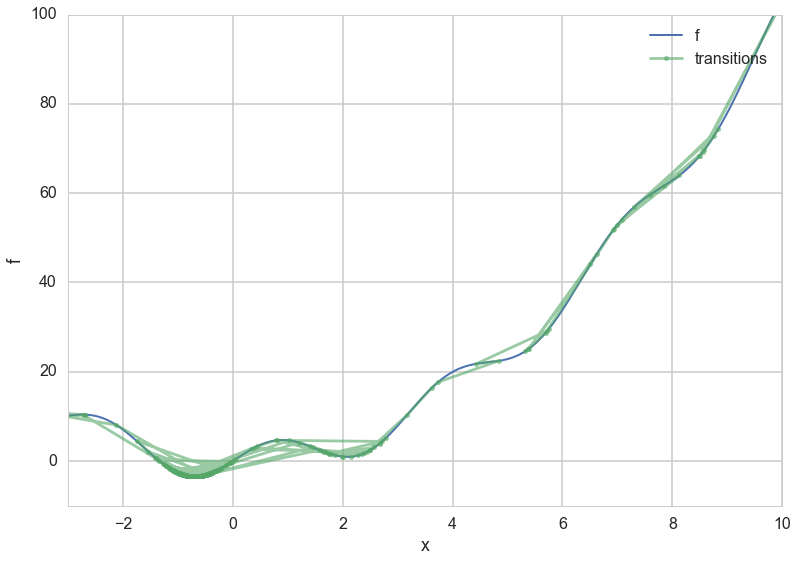

In [14]:
xs = np.linspace(-10.,10.,1000)
plt.plot(xs, f(xs), lw=2, label="f");
eout=list(enumerate(out))
#len([e[1] for i,e in eout if i%100==0]), len([e[2] for i,e in eout if i%100==0])
plt.plot([e[1] for i,e in eout if i%100==0], [e[2] for i,e in eout if i%100==0], 'o-', alpha=0.6, markersize=5, label="transitions")
#plt.plot([e[1] for e in out], [f(e[1]) for e in out], '.', alpha=0.005)
plt.xlim([-3,10])
plt.ylim([-10,100])
plt.xlabel('x')
plt.ylabel('f')
plt.legend();

Notice how the x-values start forming a tighter and tighter (stationary) distribution about the minimum as temperature is decreased.

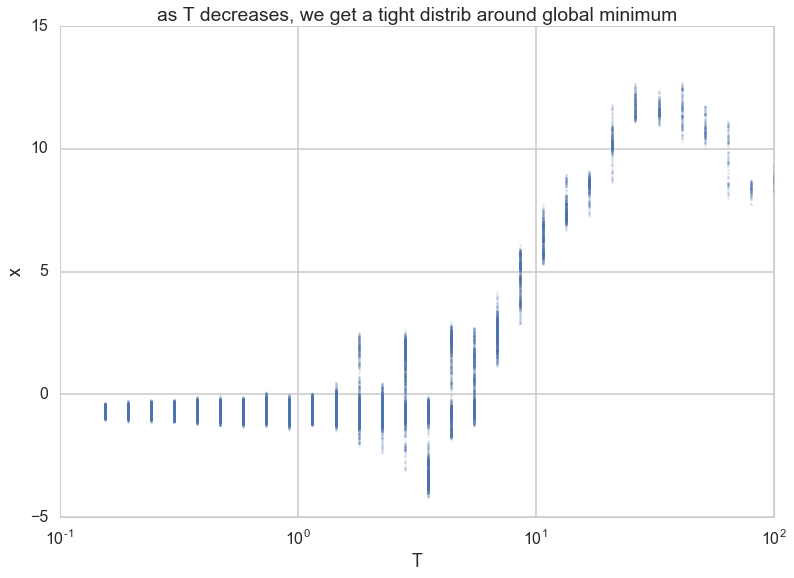

In [15]:
plt.plot([e[0] for e in out],[e[1] for e in out],'.', alpha=0.1, markersize=5);
plt.xscale('log')
plt.xlabel('T')
plt.ylabel('x')
plt.title('as T decreases, we get a tight distrib around global minimum')

...which translates to a tight distribution on the "energy" $f$.

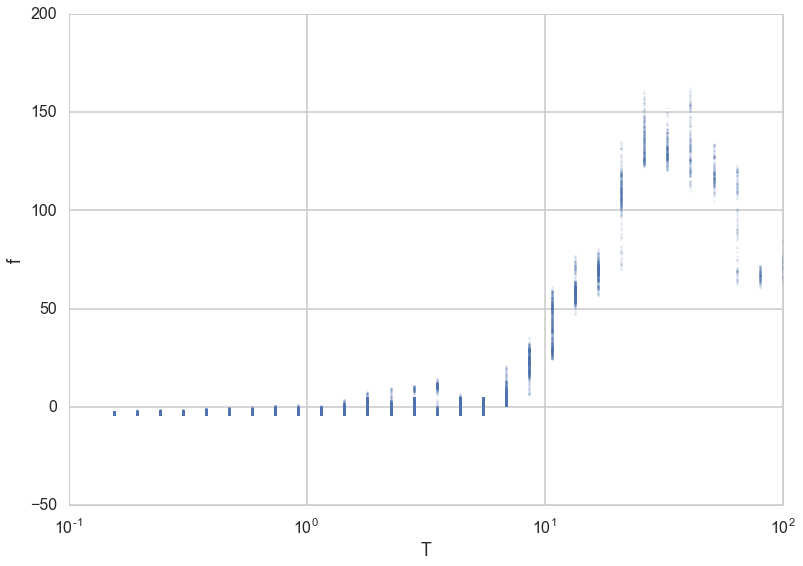

In [16]:
plt.plot([e[0] for e in out],[e[2] for e in out],'.', alpha=0.1, markersize=5);
plt.xscale('log')
plt.xlabel('T')
plt.ylabel('f')

We can also plot these against the iterations.

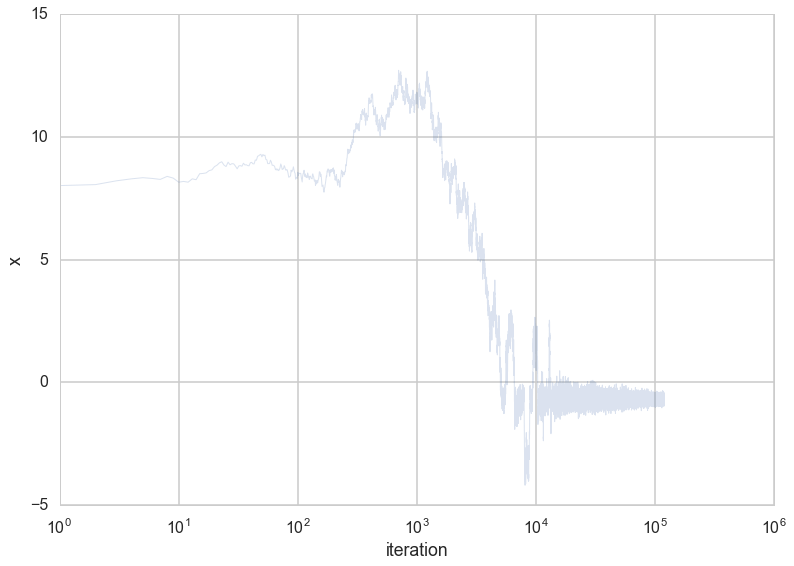

In [17]:
plt.plot([e[1] for e in out], alpha=0.2, lw=1);
plt.xscale('log')
plt.xlabel('iteration')
plt.ylabel('x')

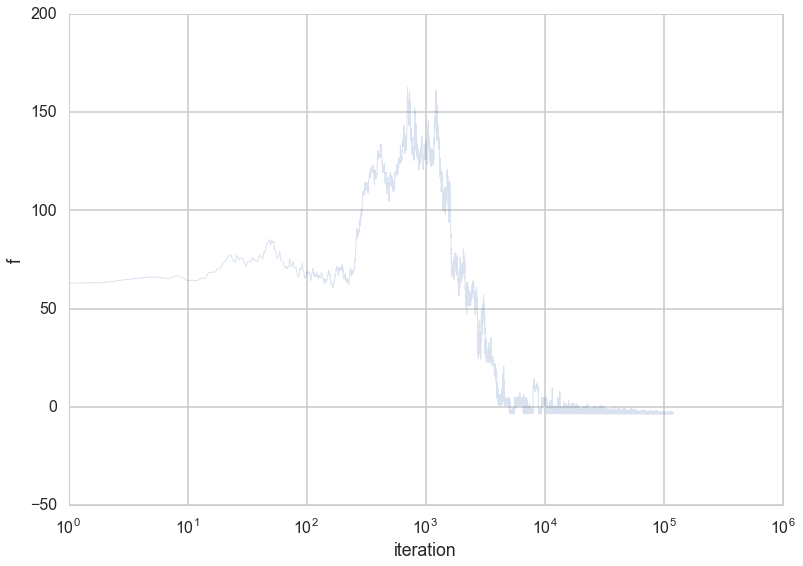

In [18]:
plt.plot(range(len(out)),[e[2] for e in out], alpha=0.2, lw=1);
plt.xscale('log')
plt.xlabel('iteration')
plt.ylabel('f')

We can make an animation of the process of finding a global minimum.

In [19]:
def animator(f, xvals, xdatafn, ydatafn, frameskip, ax):
    
    fvals=[f(x) for x in xvals]
    ax.plot(xvals, fvals, lw=3)
    line, = ax.plot([], [], "o", markersize=12)

    def init():
        line.set_data([], [])
        return line,

    def animate(i):
        x_n = xdatafn(i, frameskip)
        y_n = ydatafn(i)
        line.set_data(x_n, y_n)
        return line,
    return init, animate


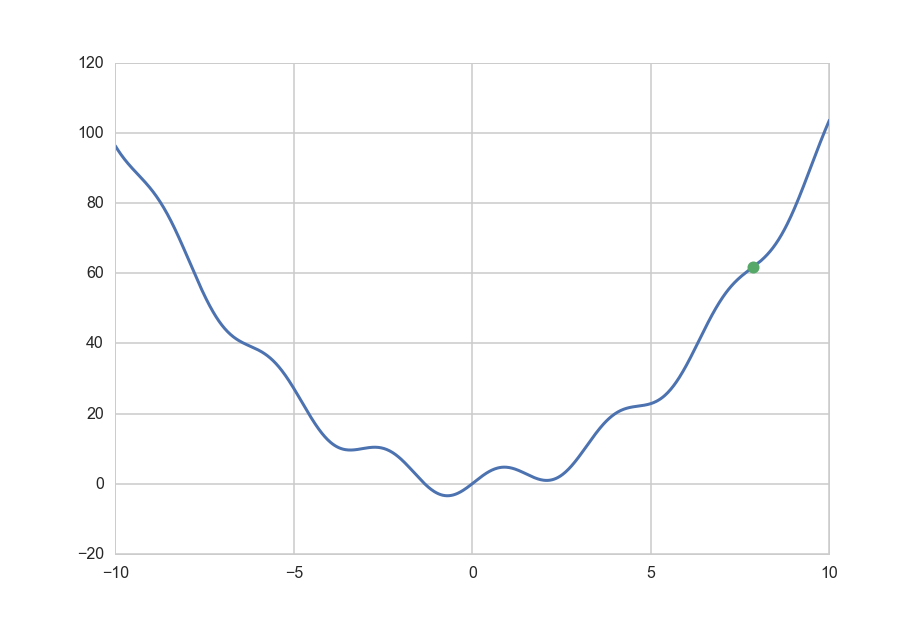
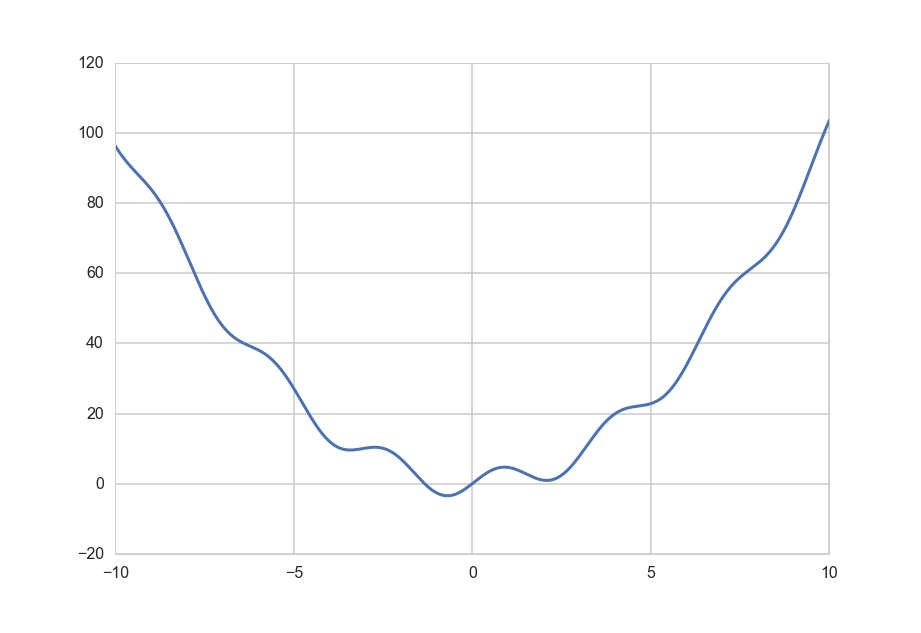
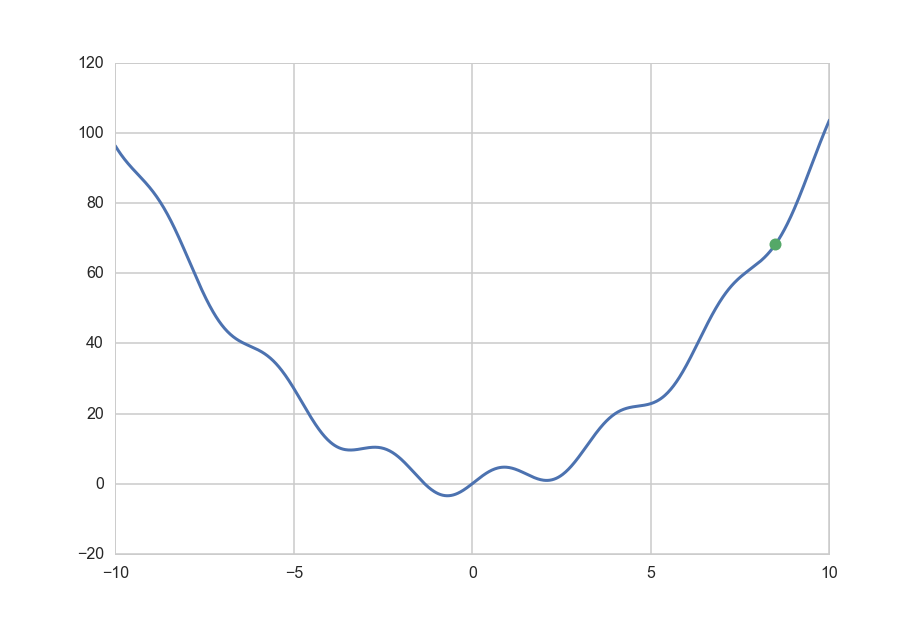
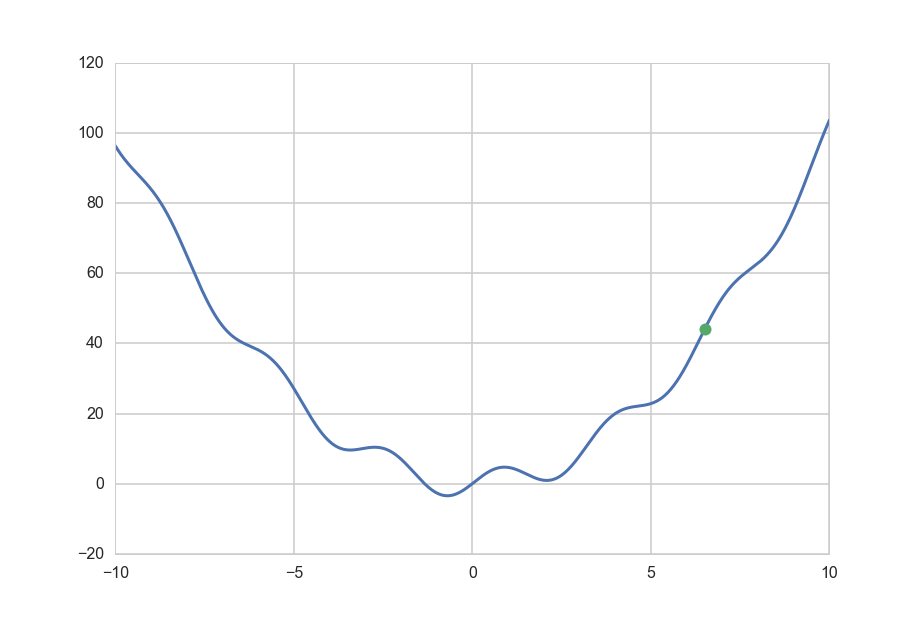
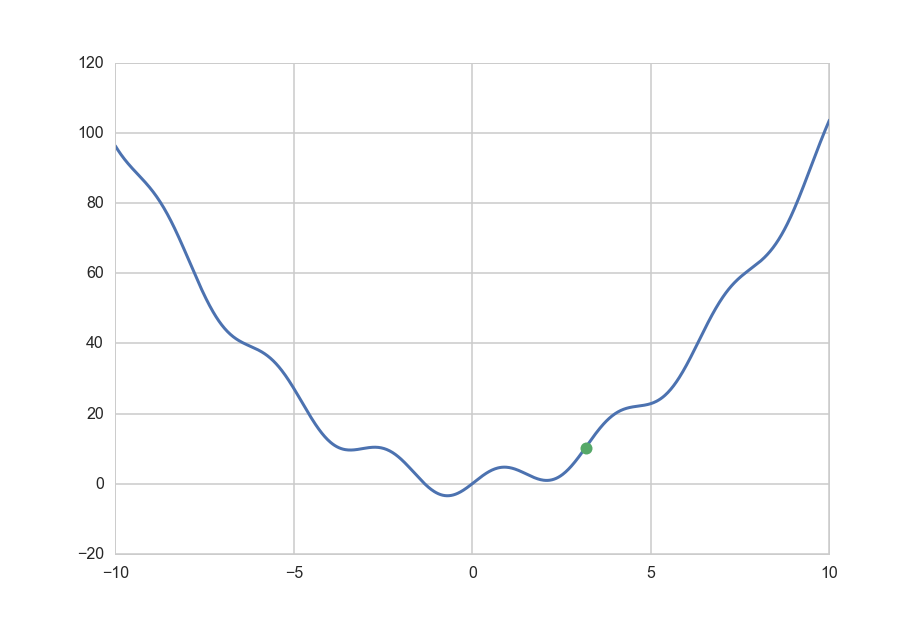
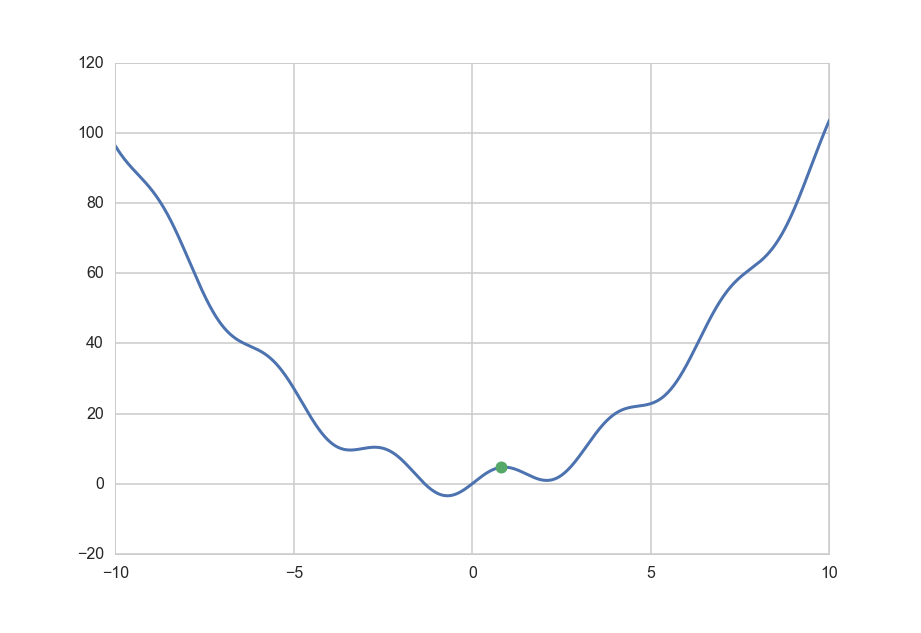
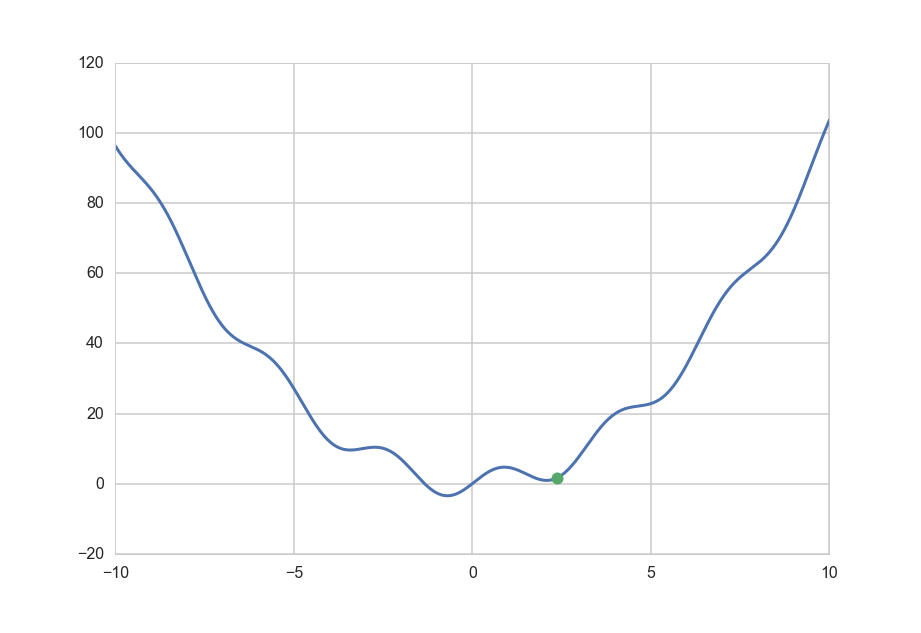
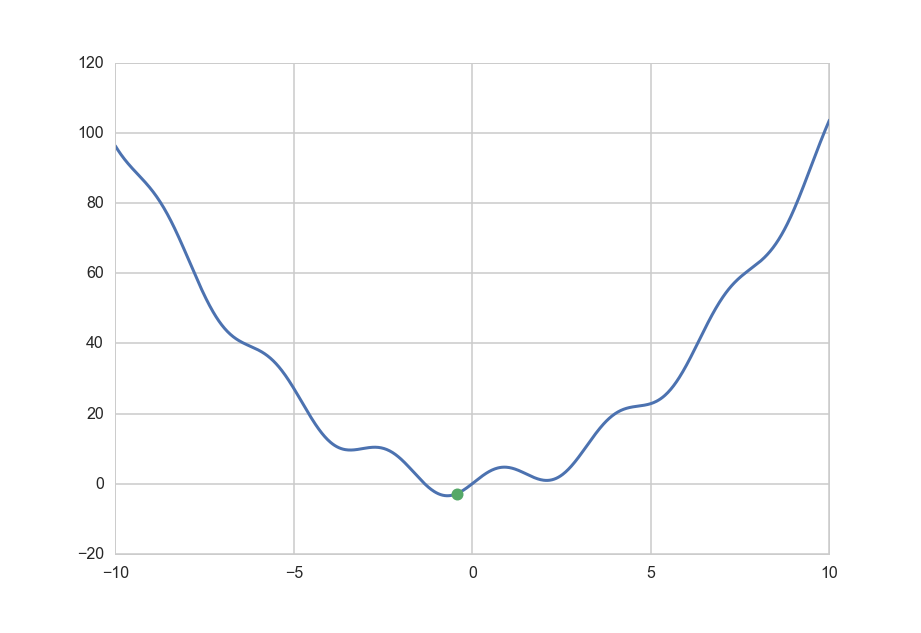
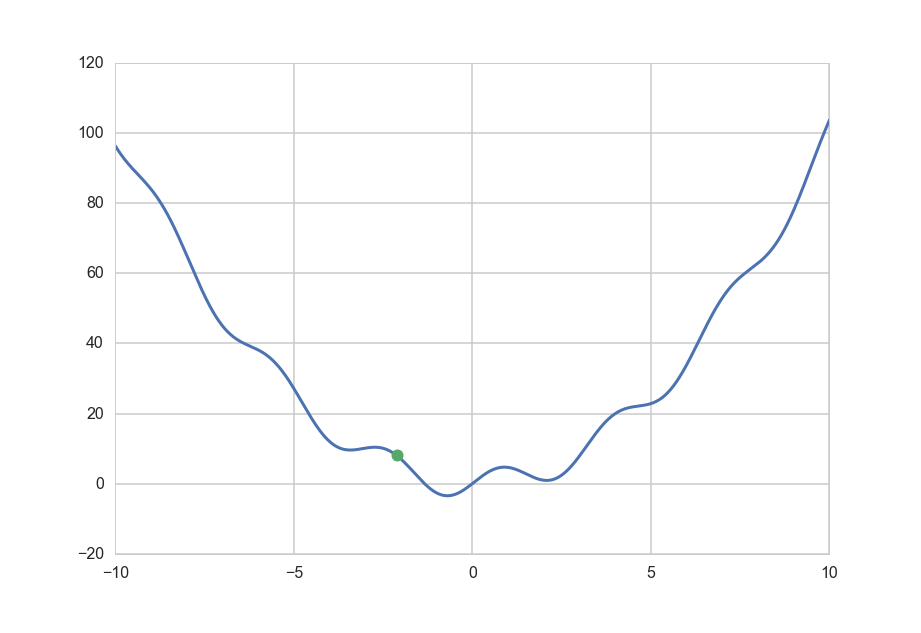
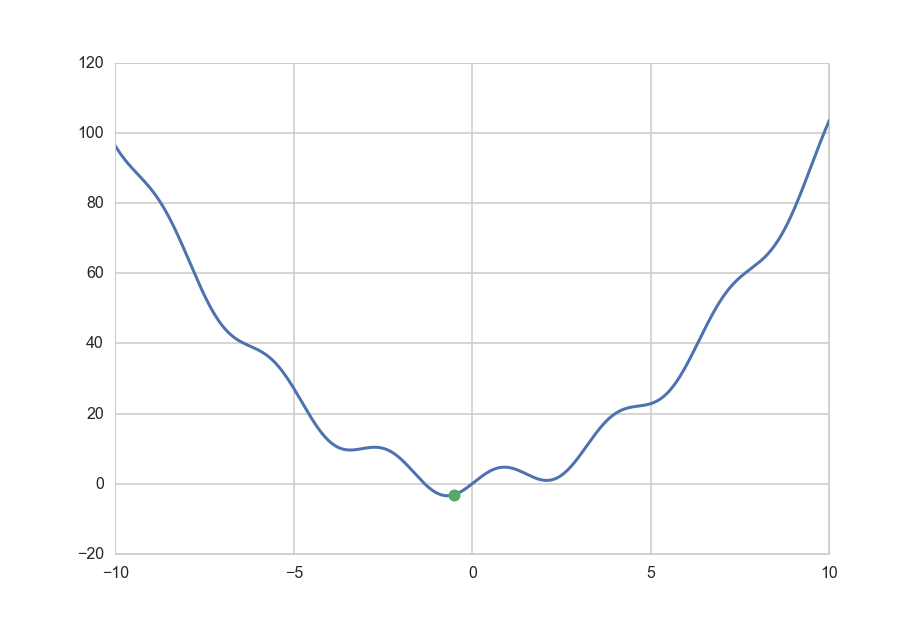
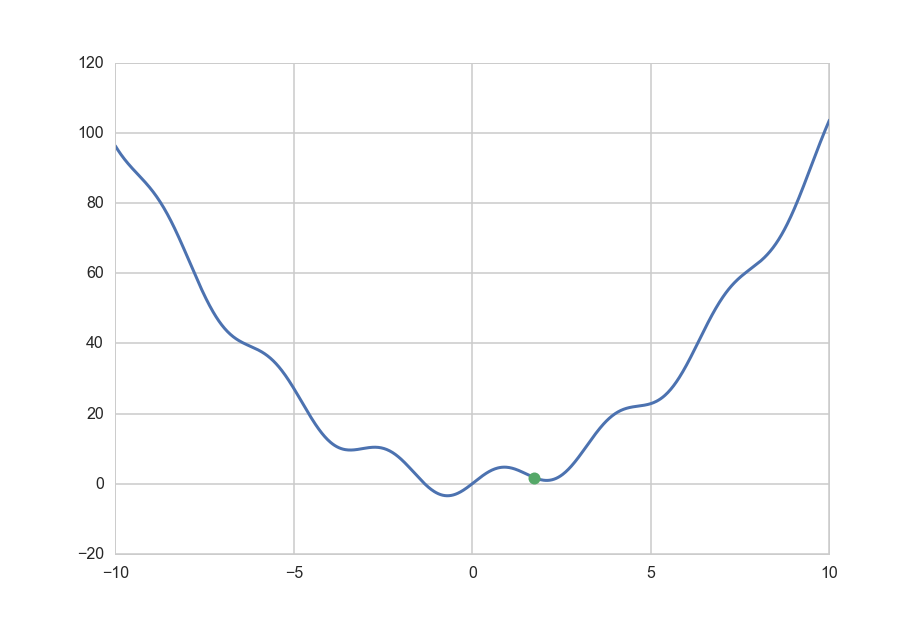
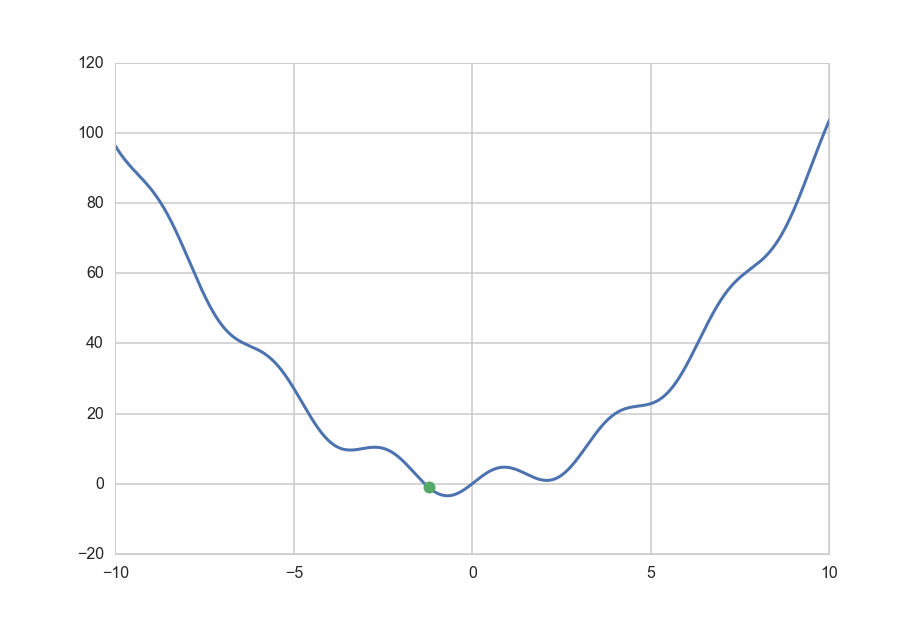
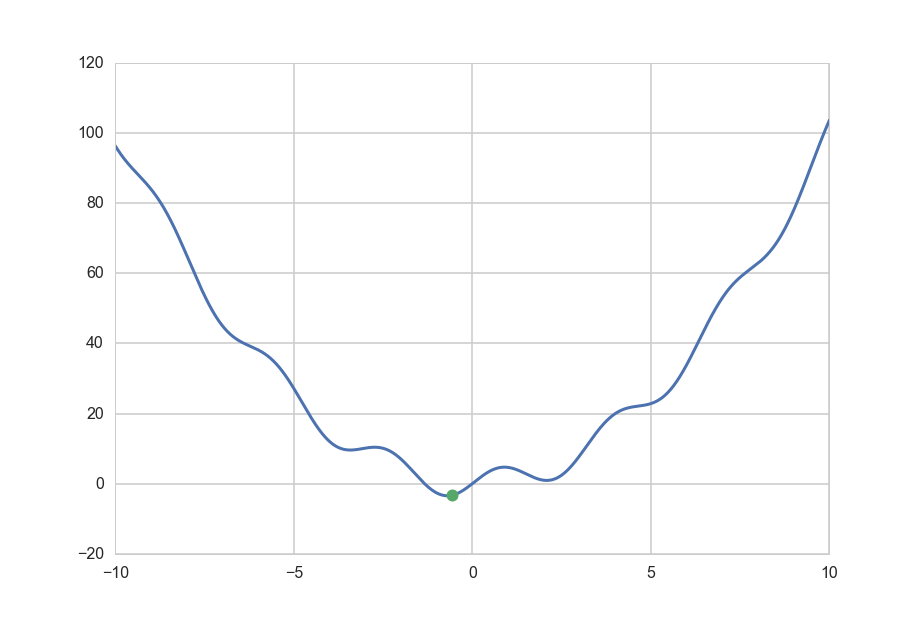
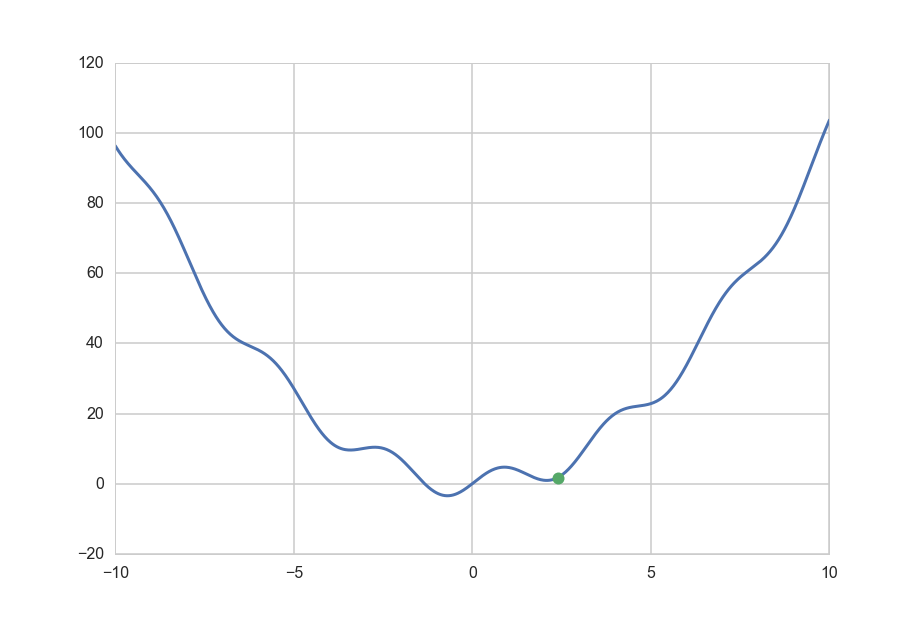
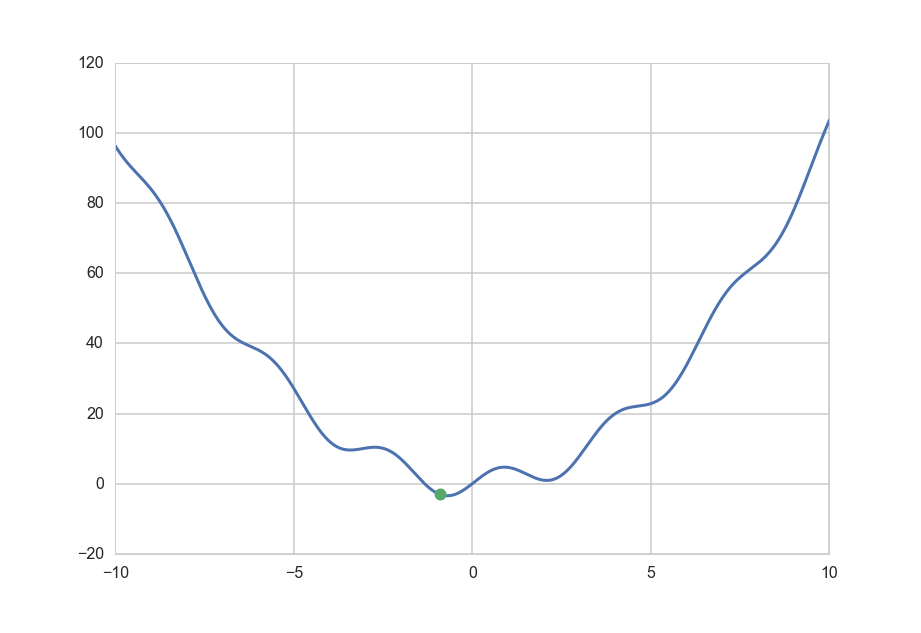
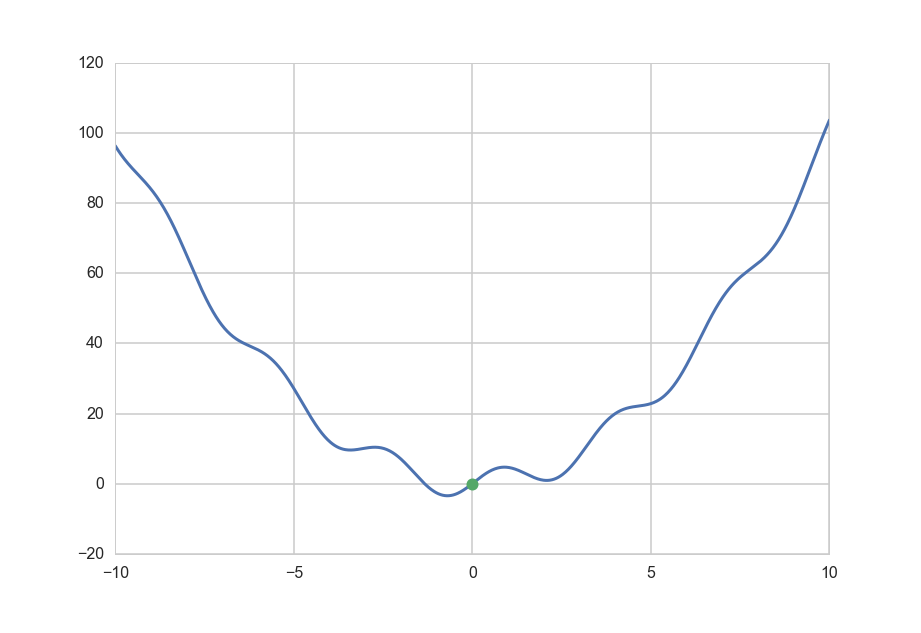
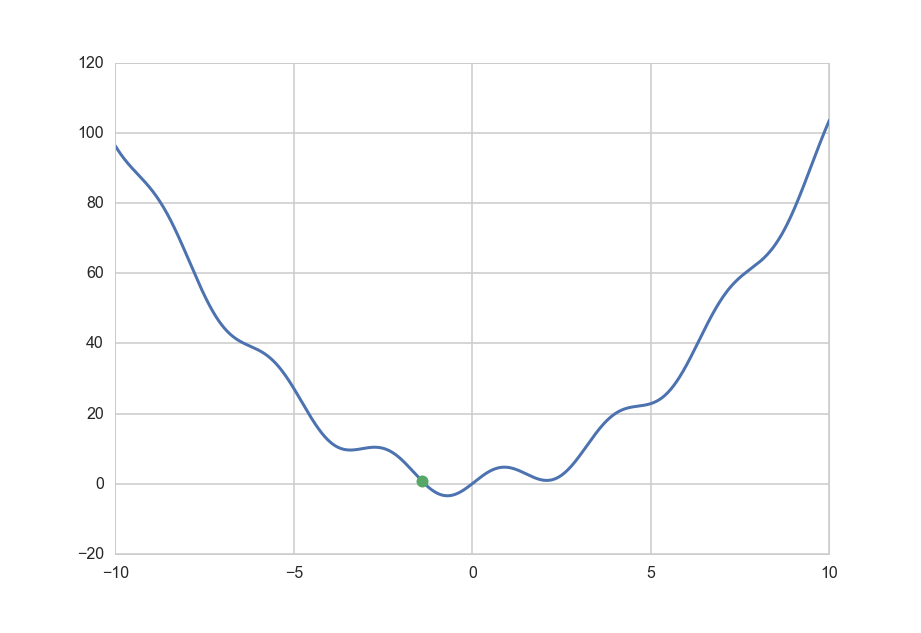
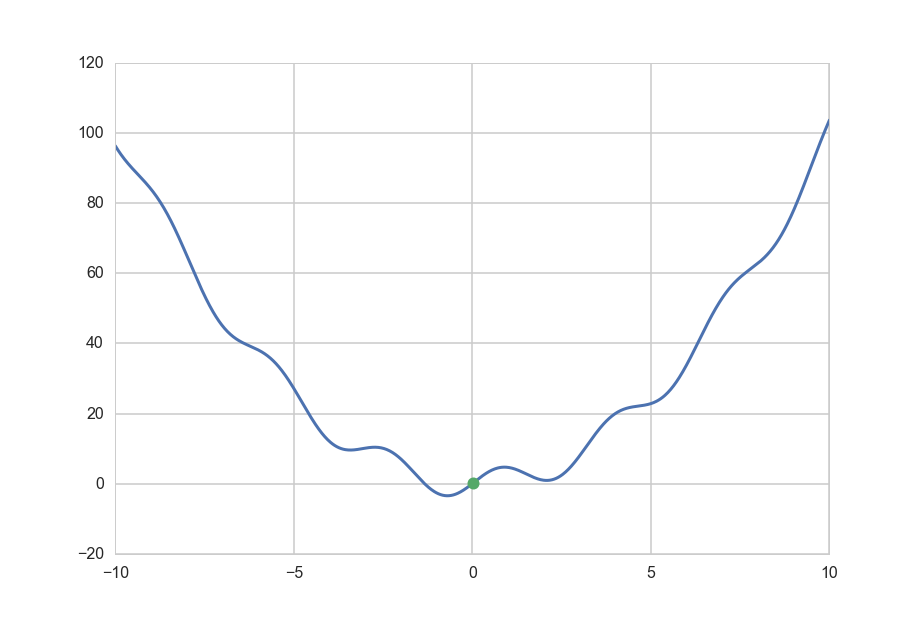
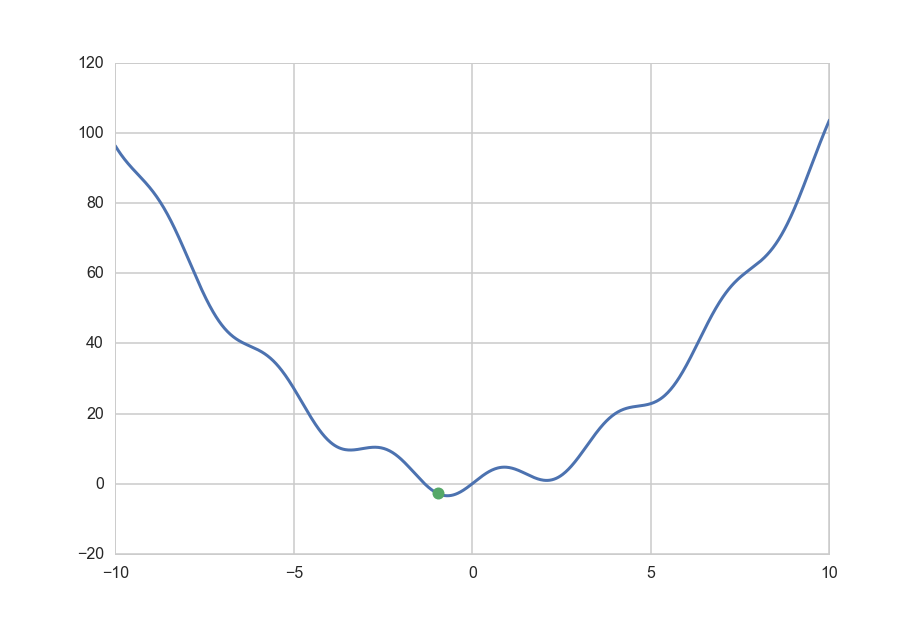
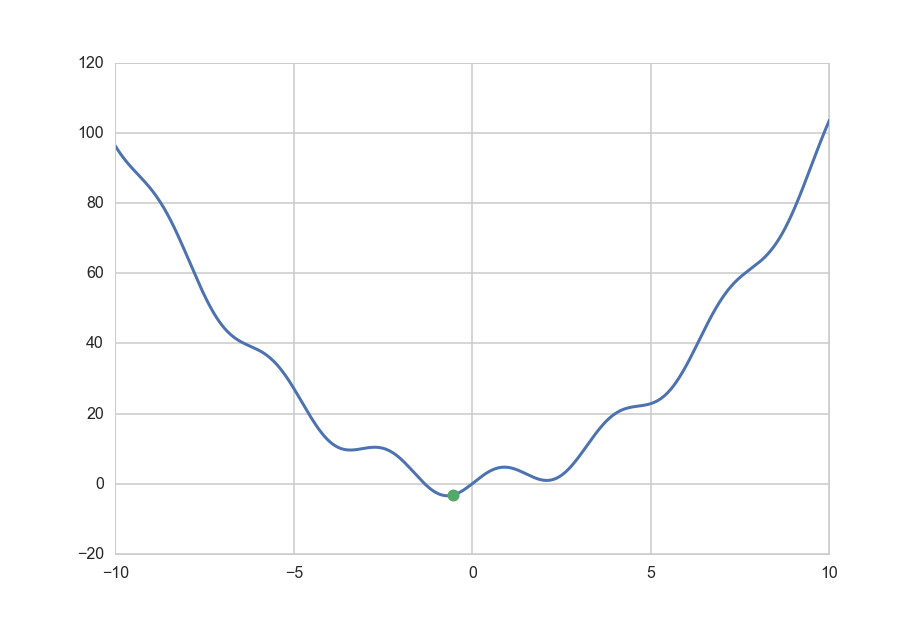
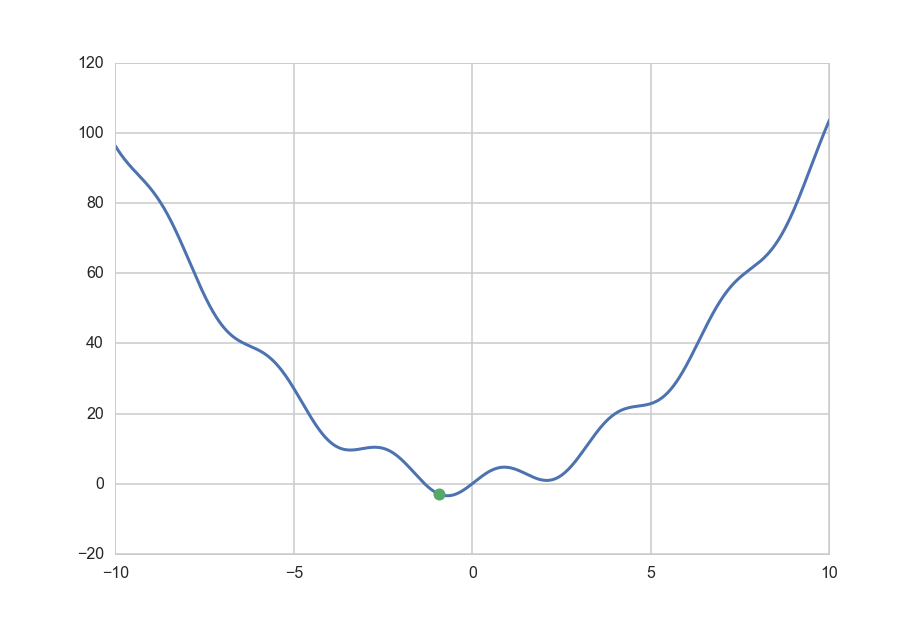
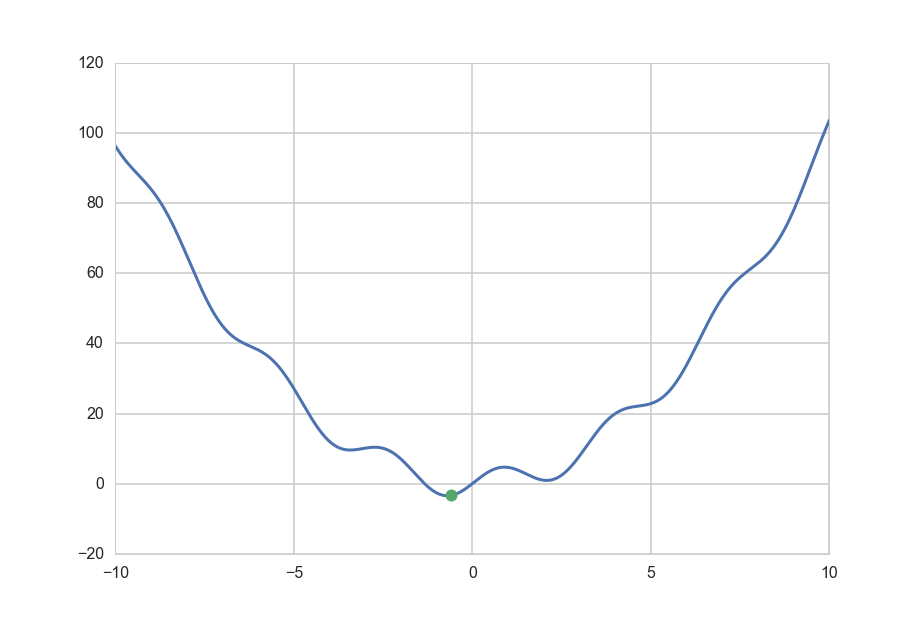
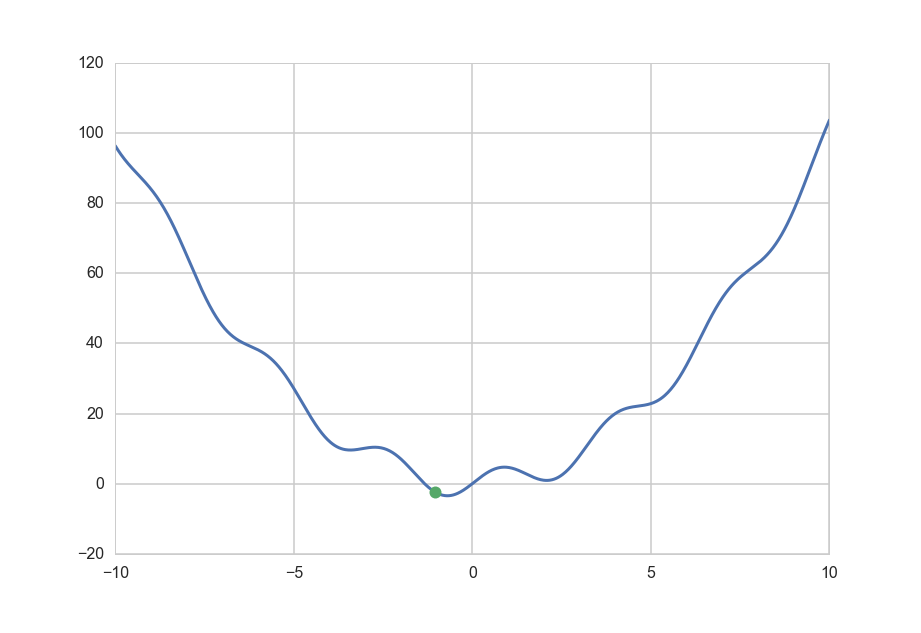
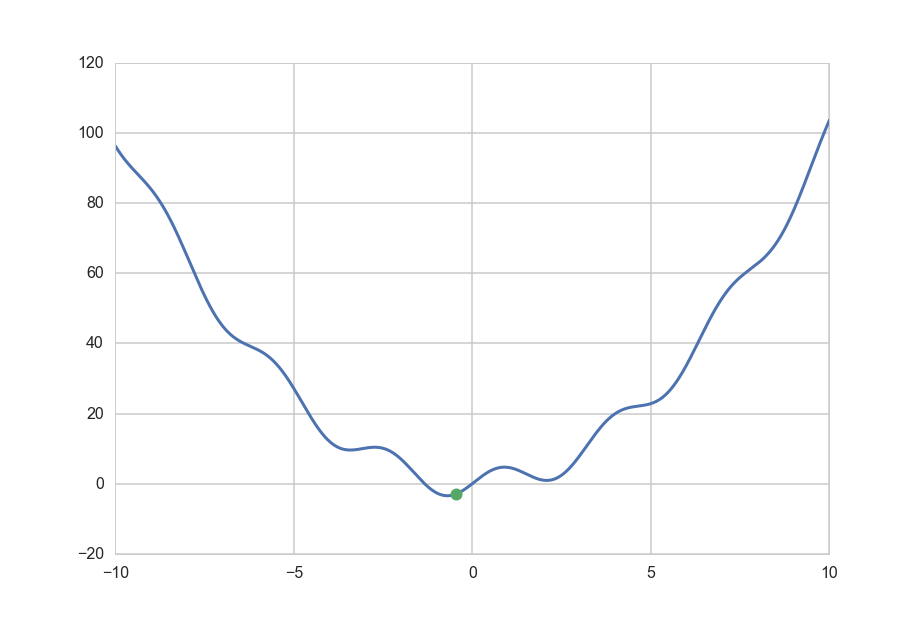
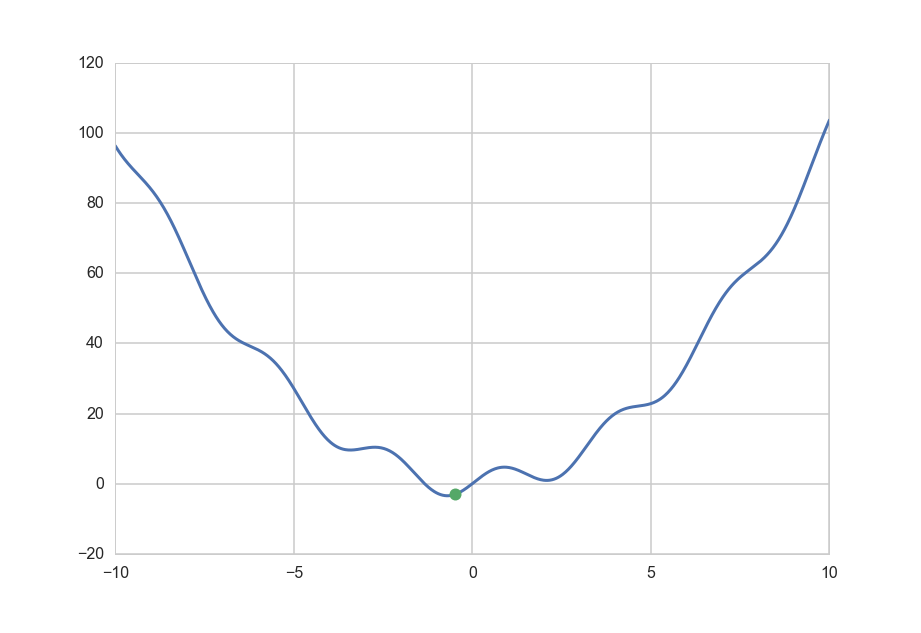
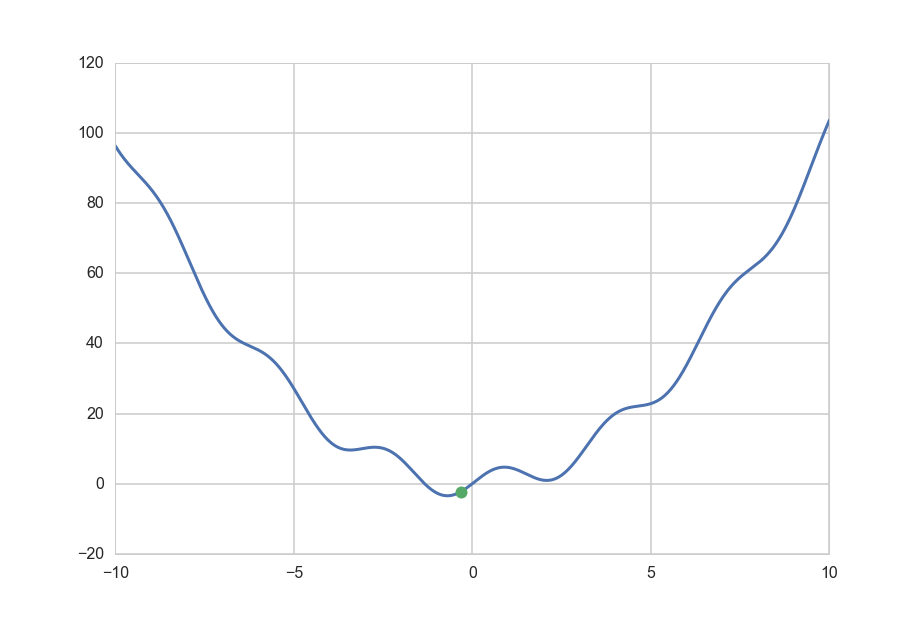
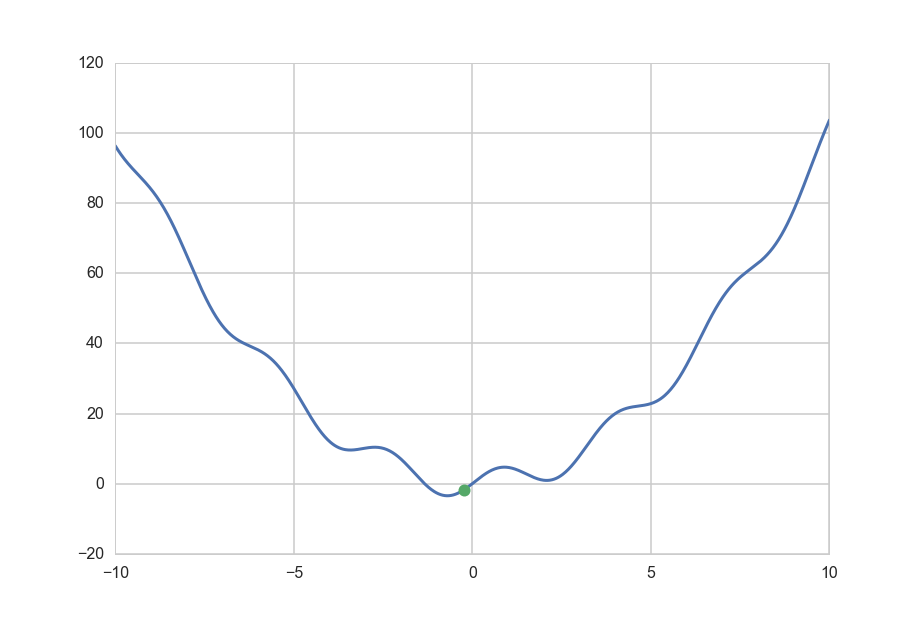
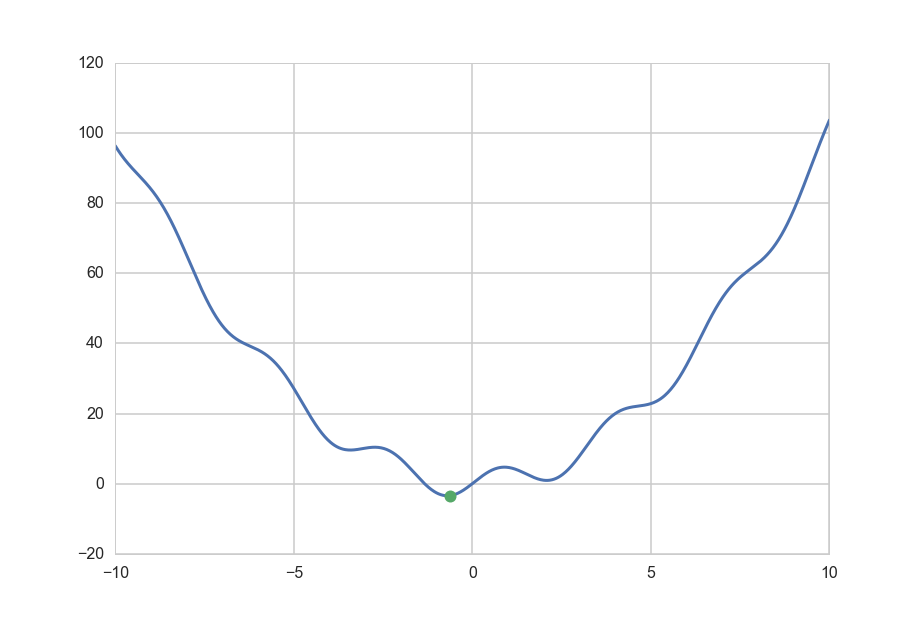
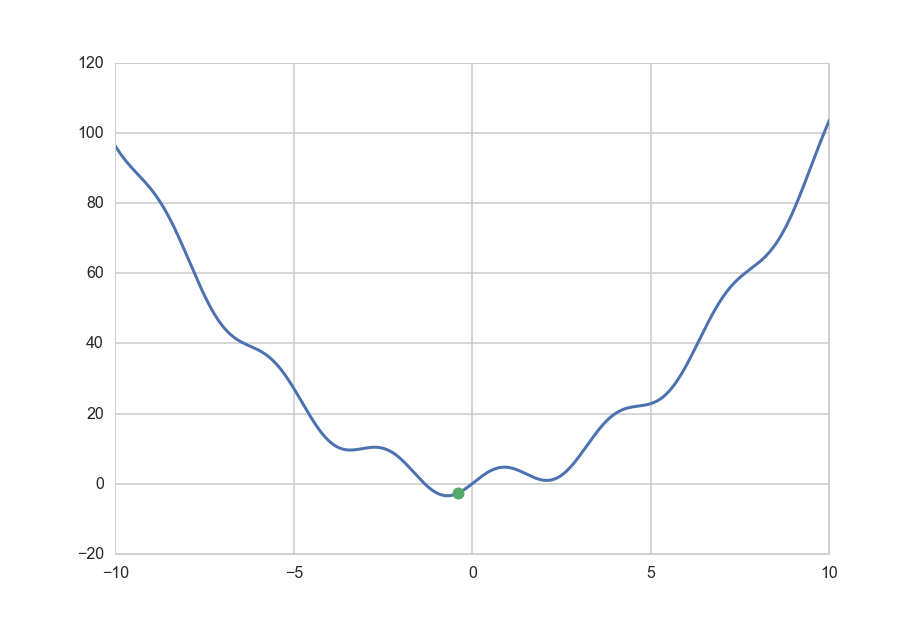
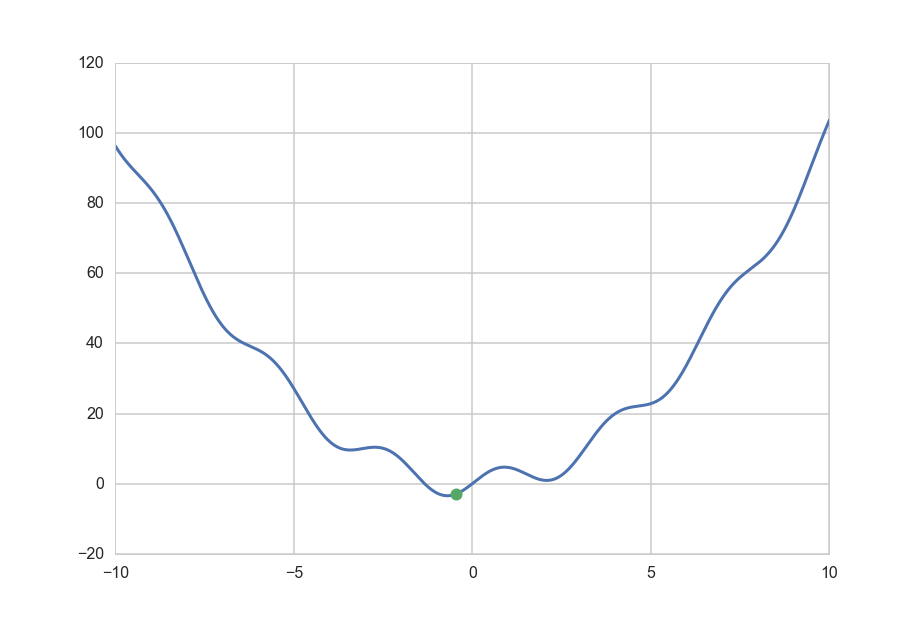
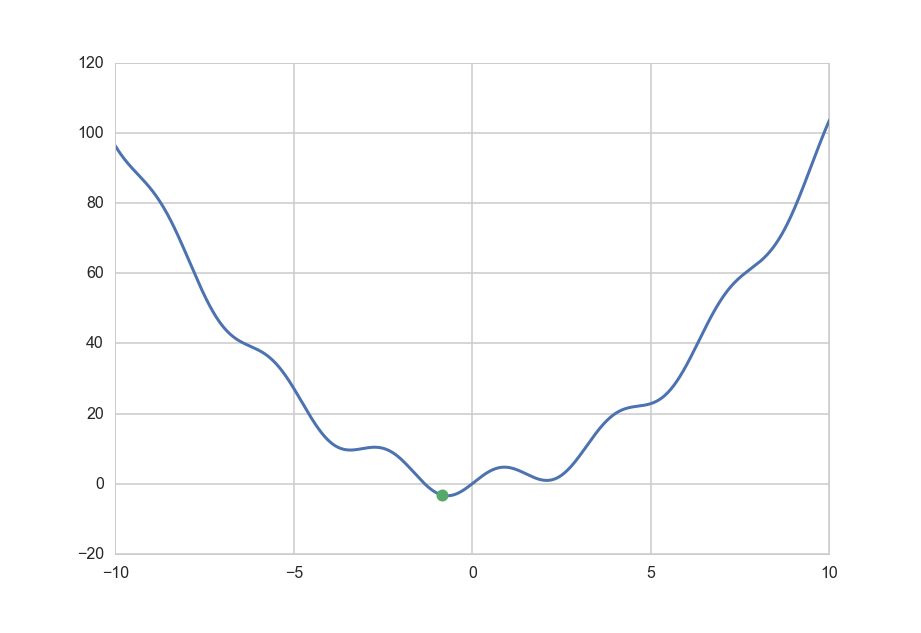
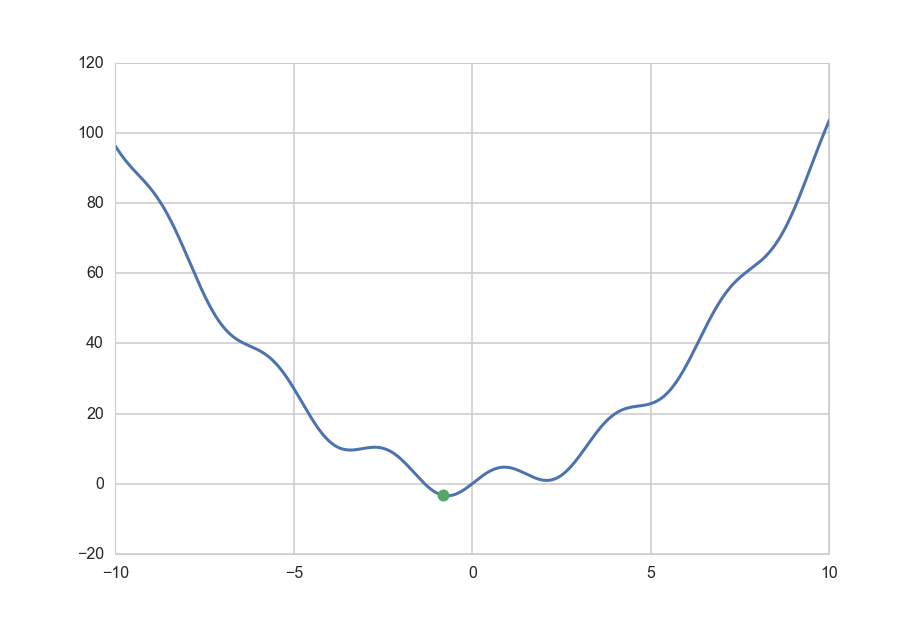
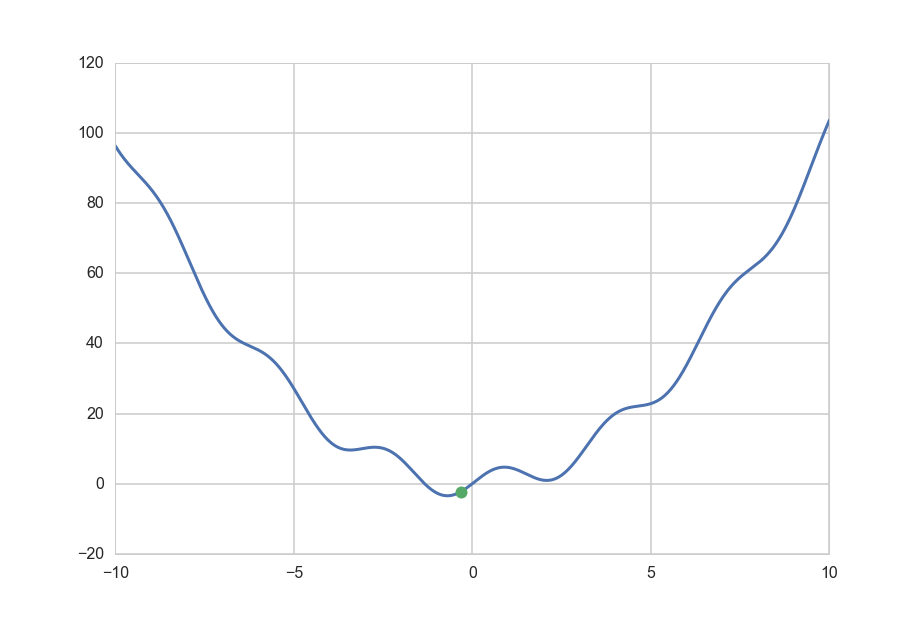
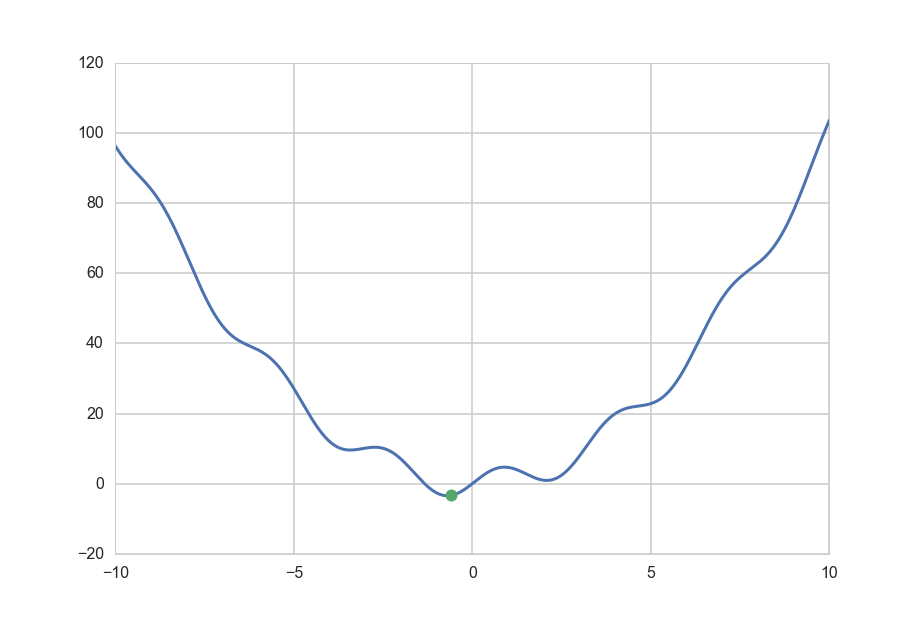
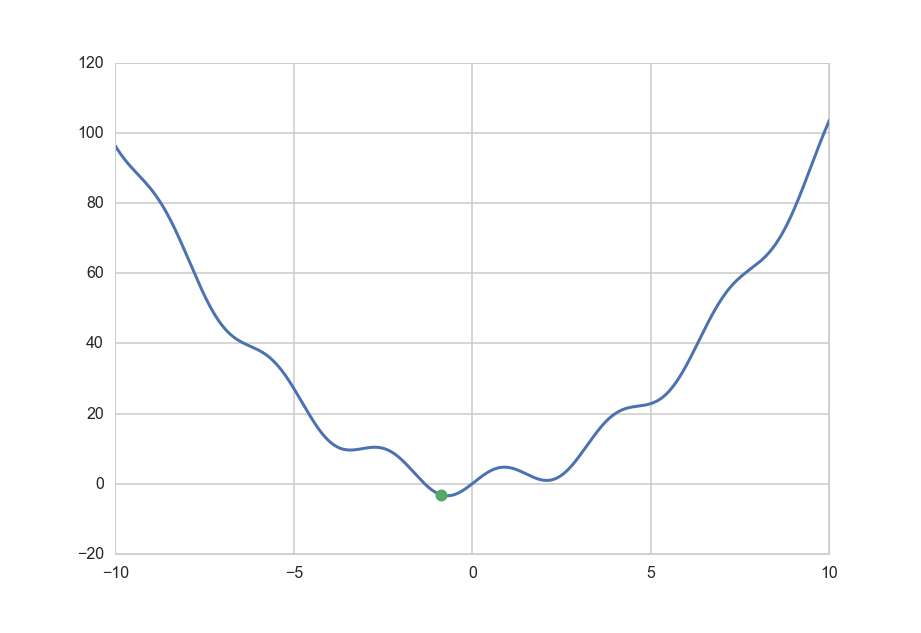
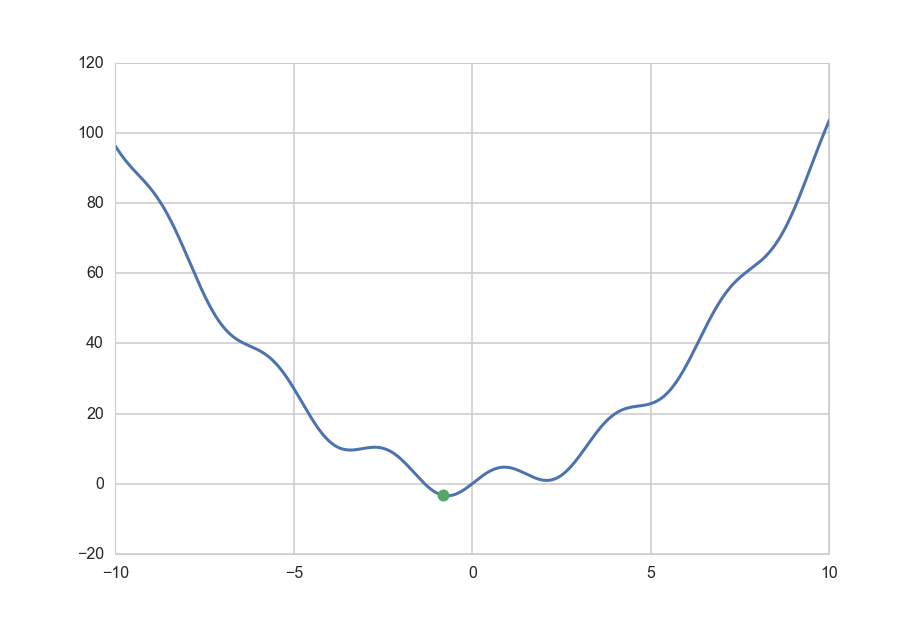
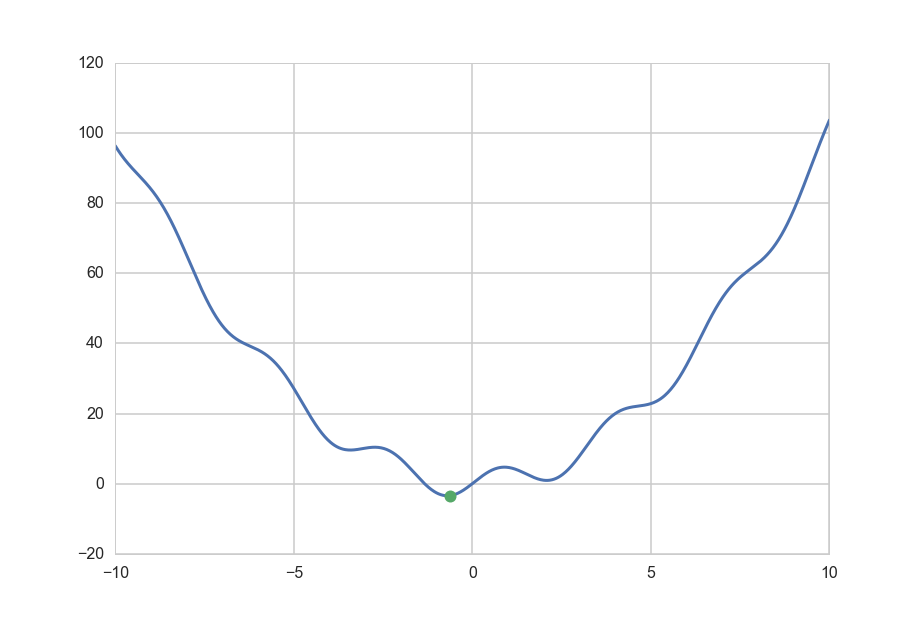
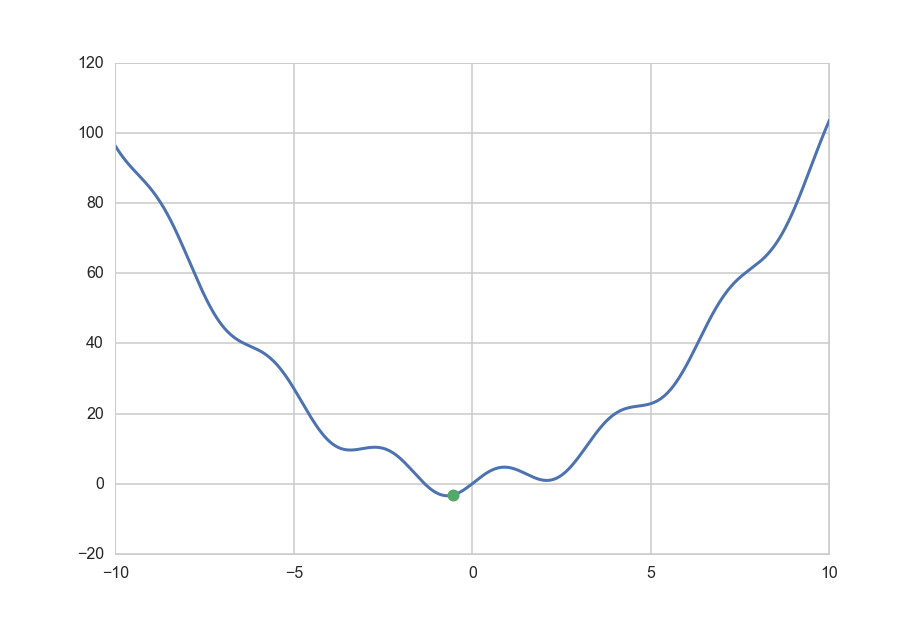
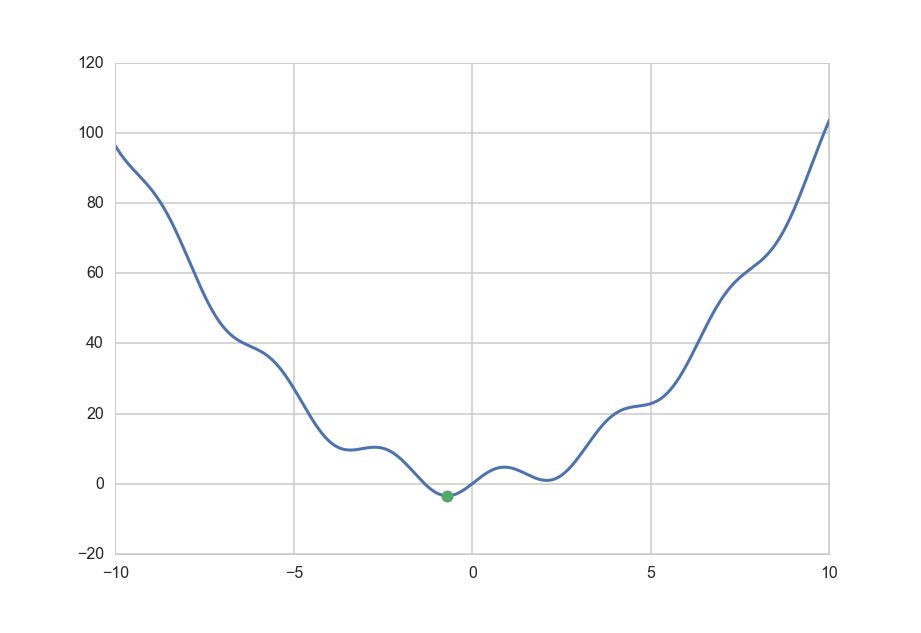
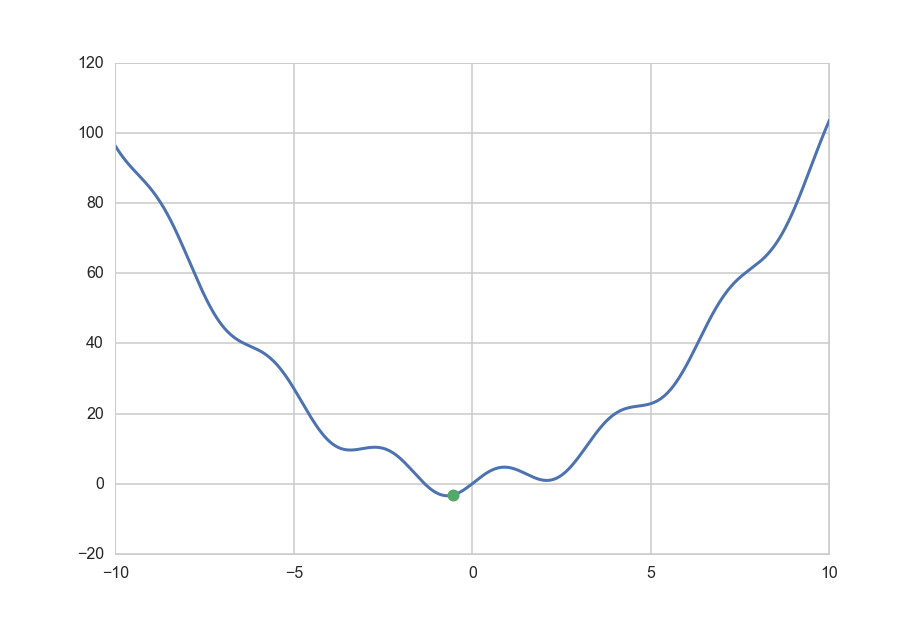
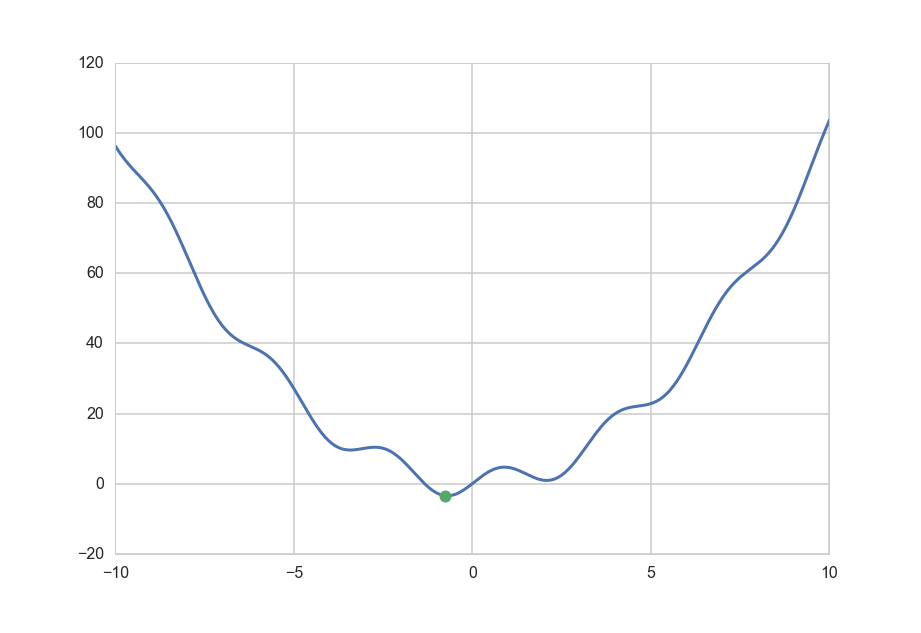
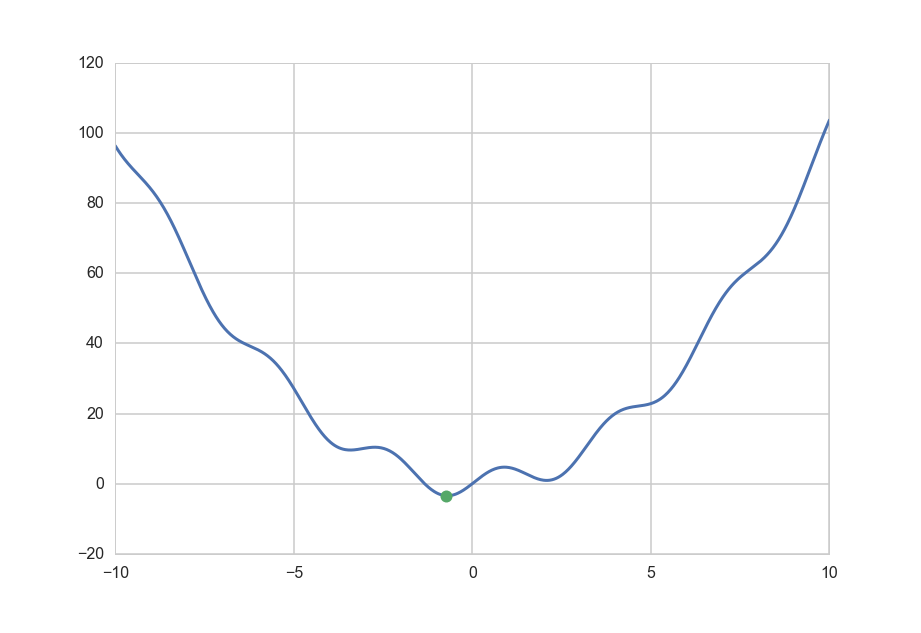
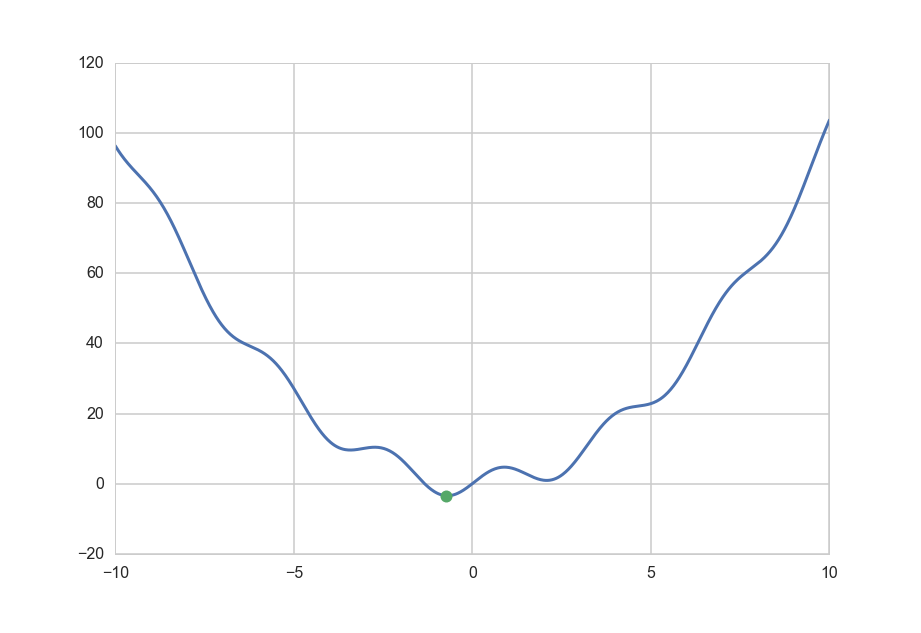
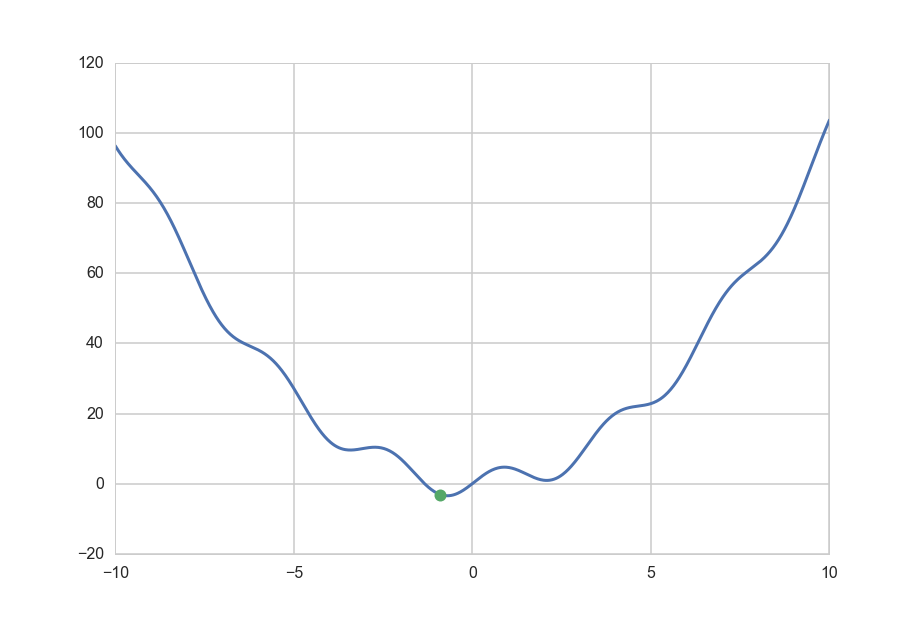
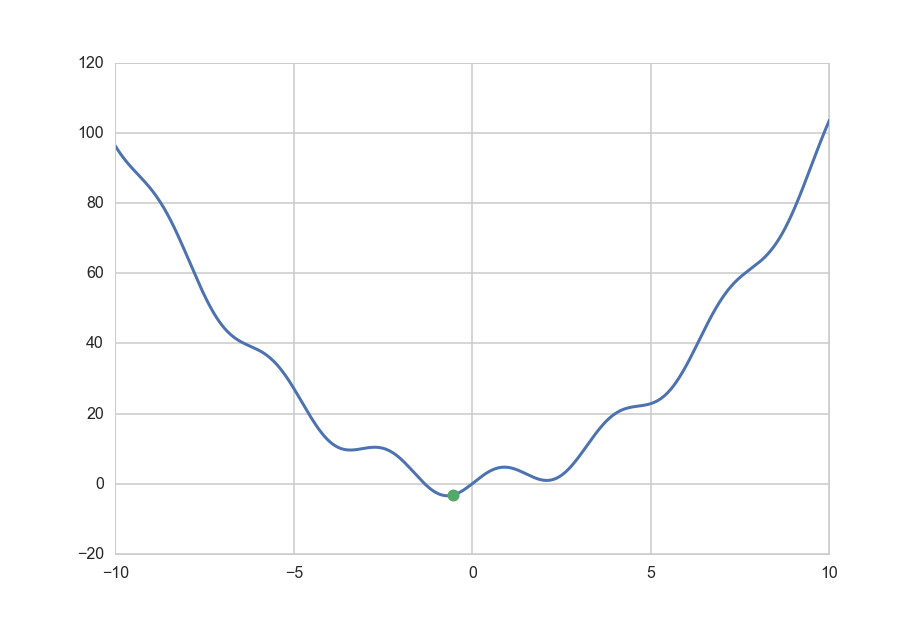
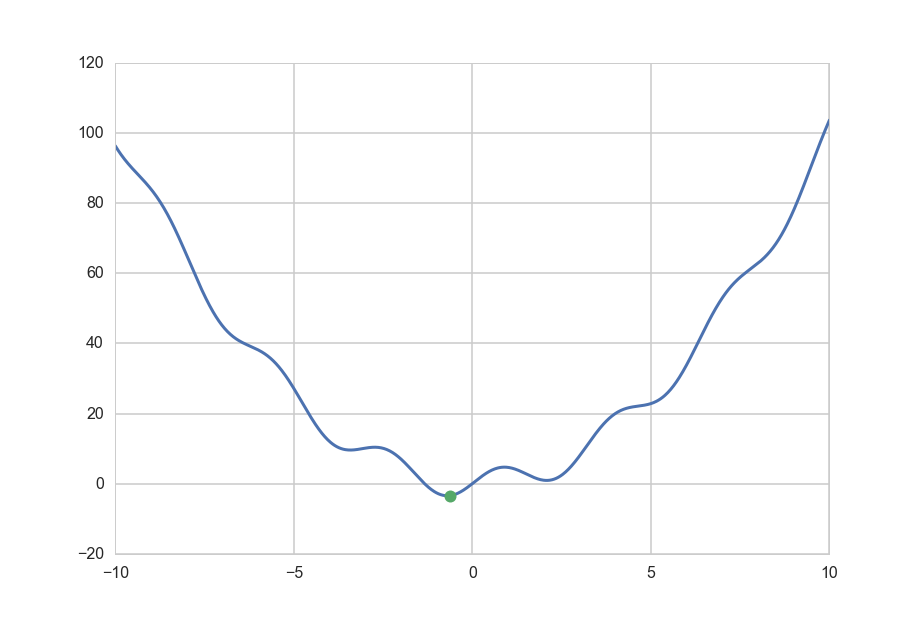
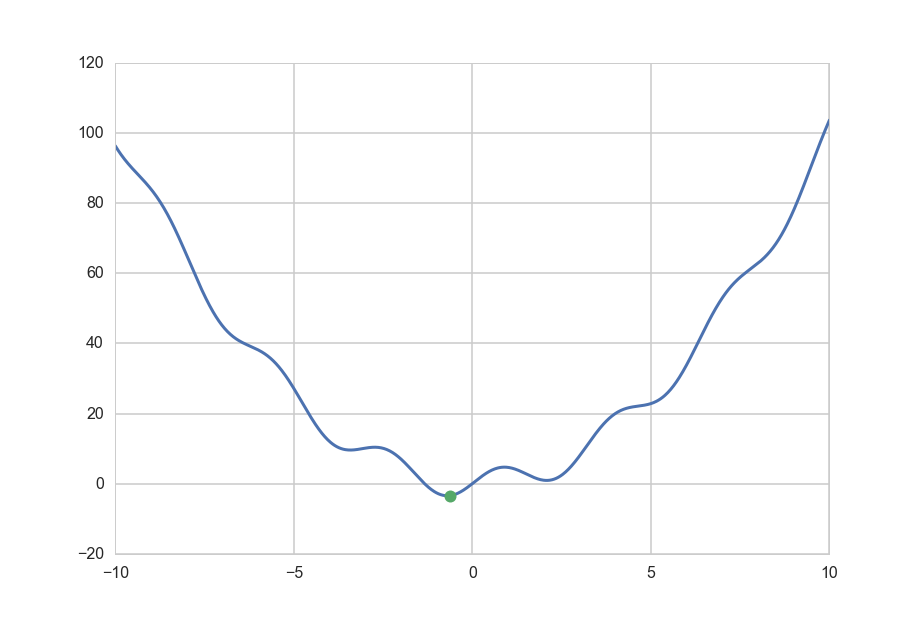
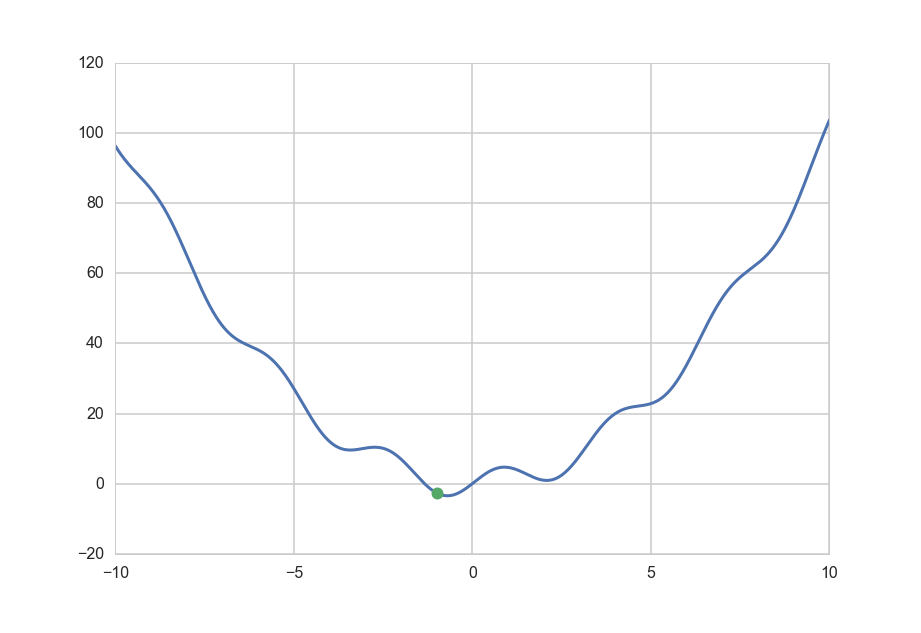
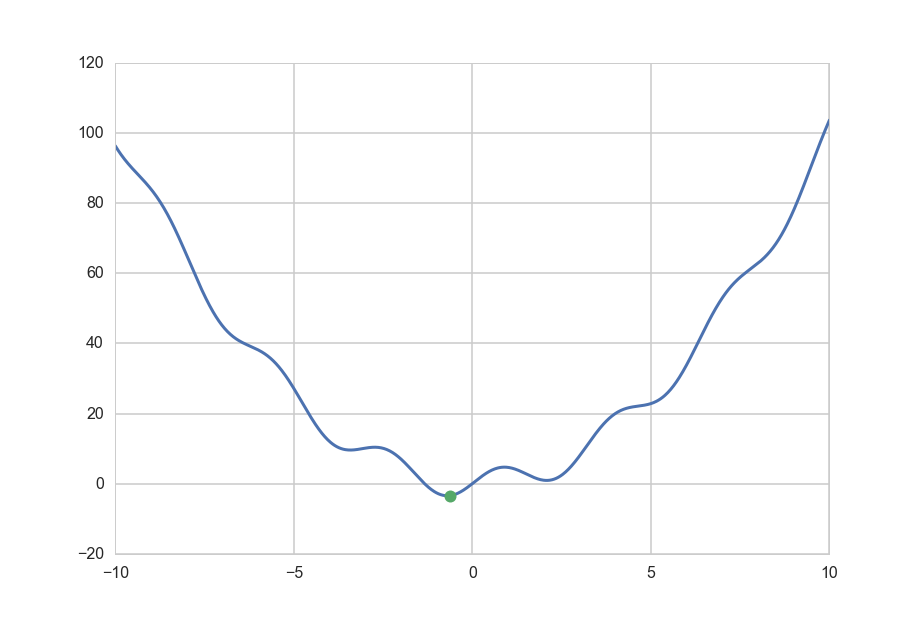
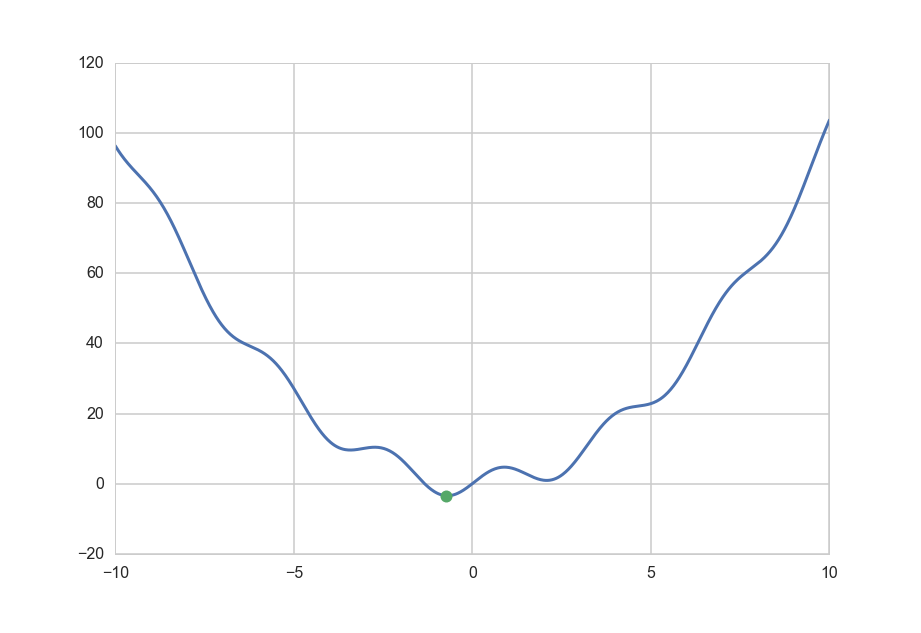
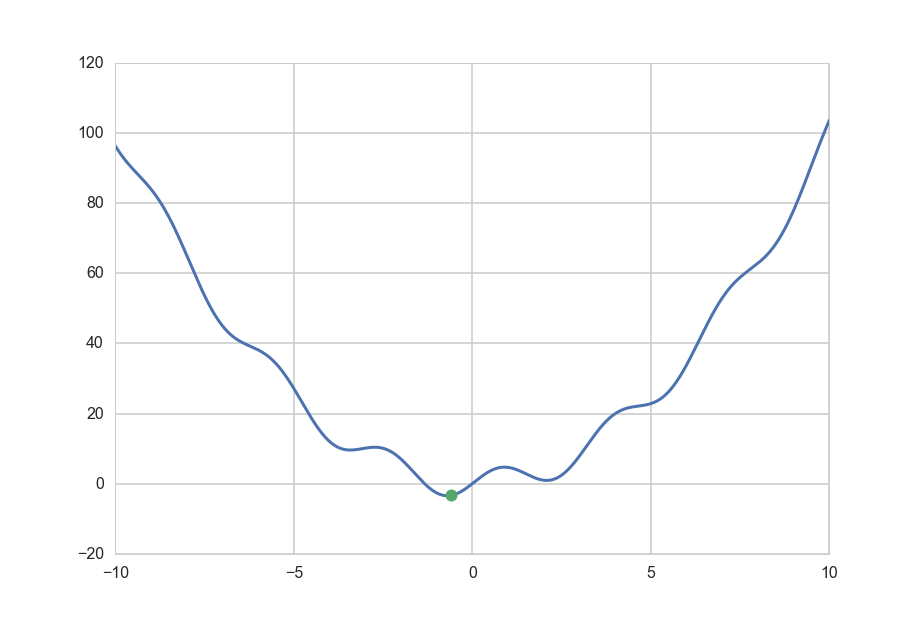
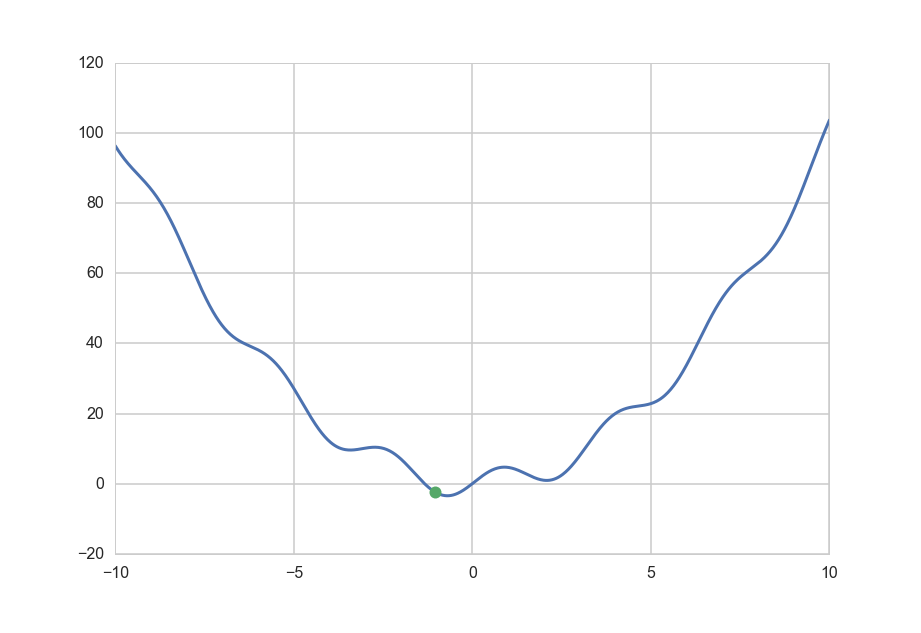
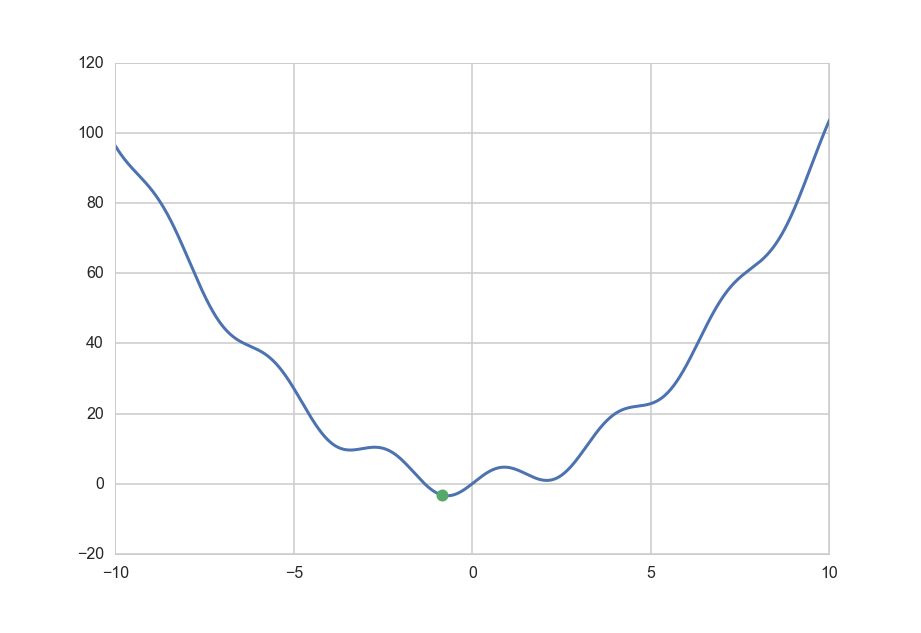
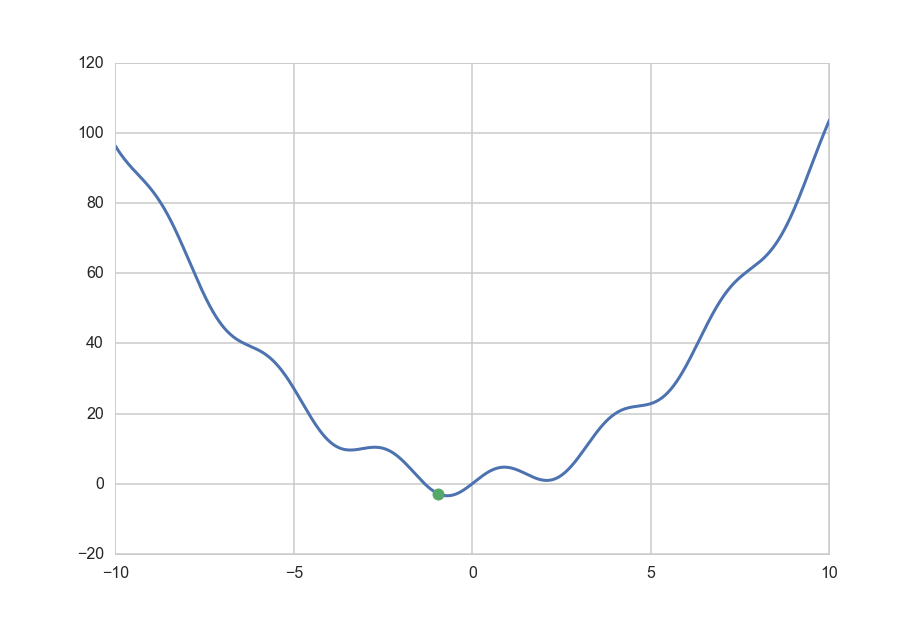
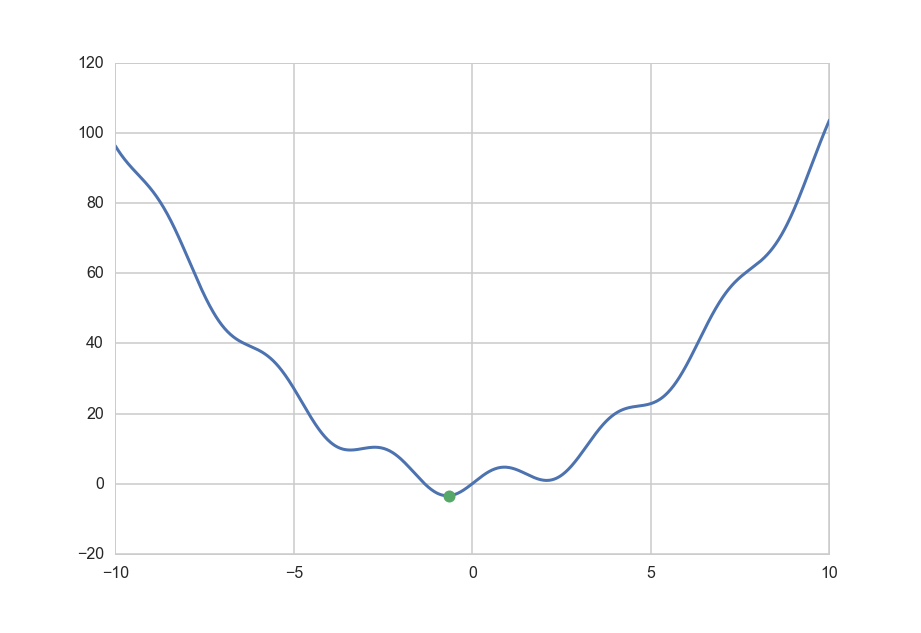
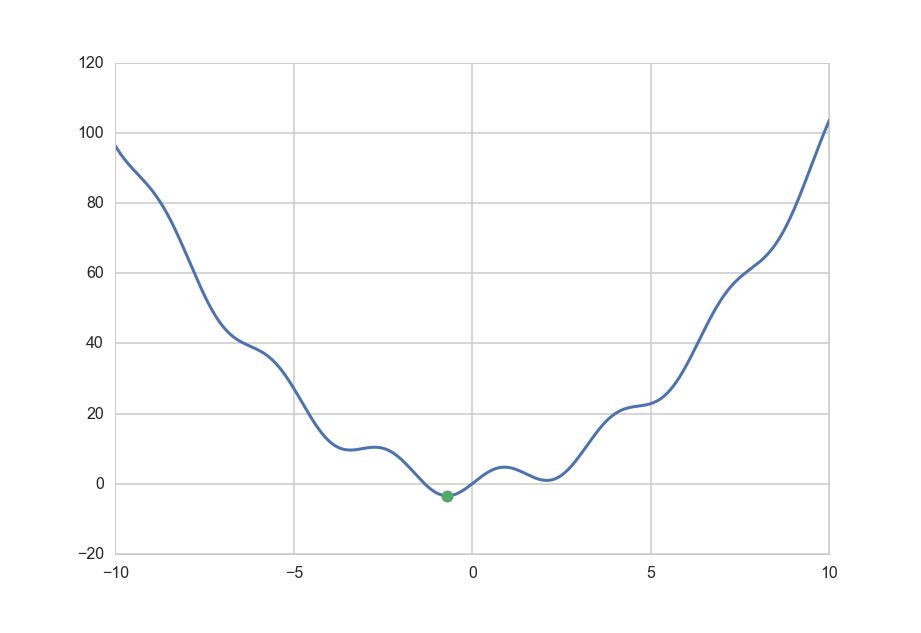
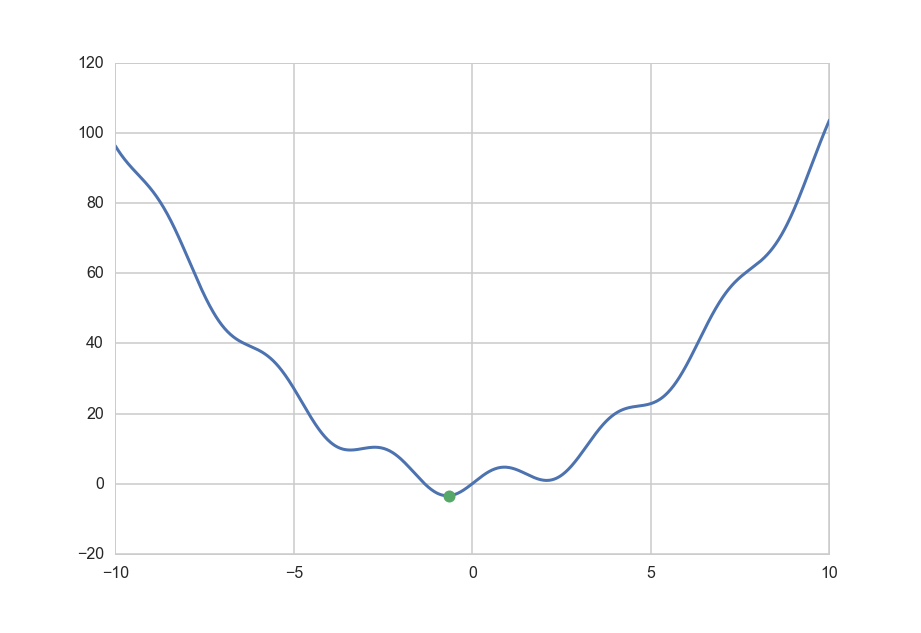
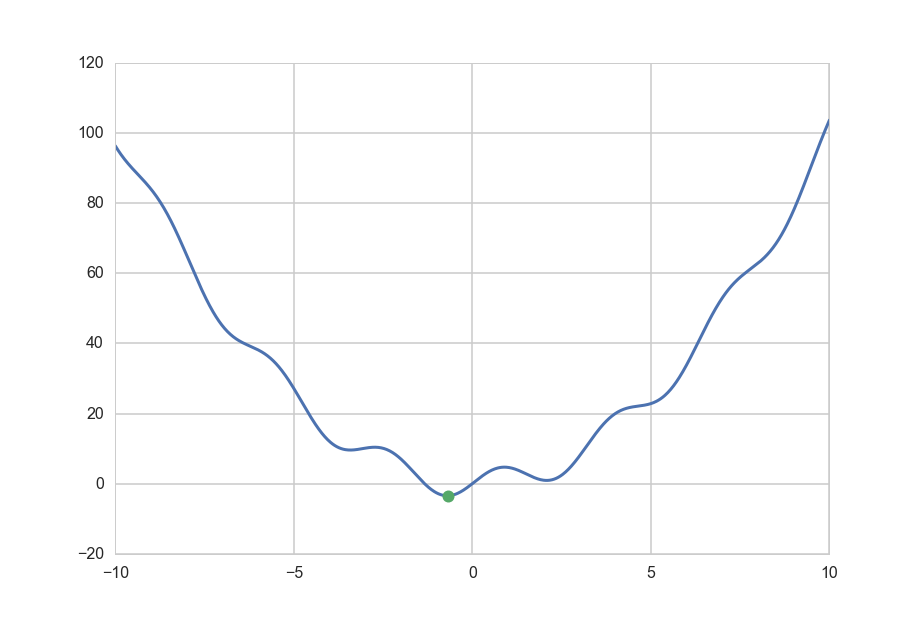
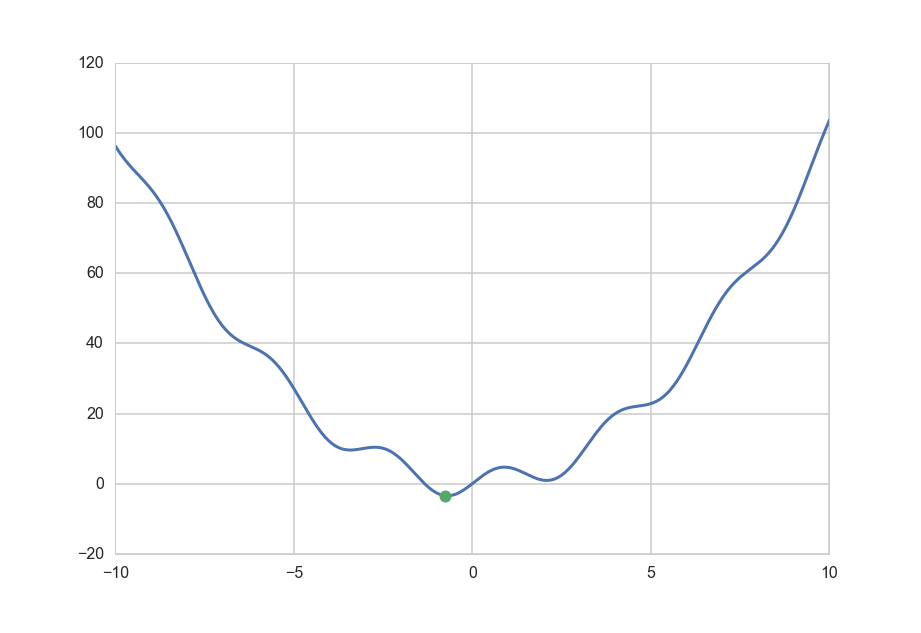
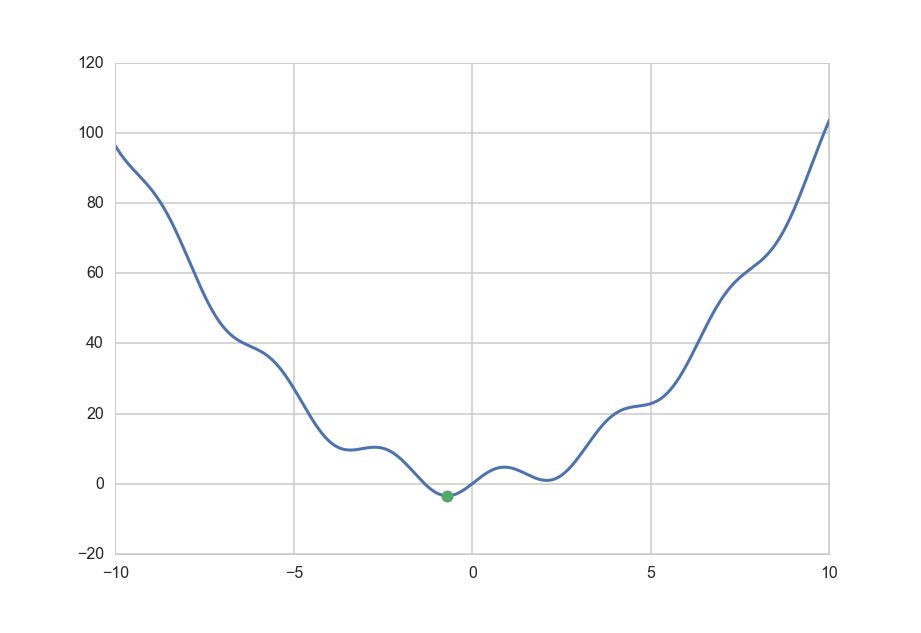
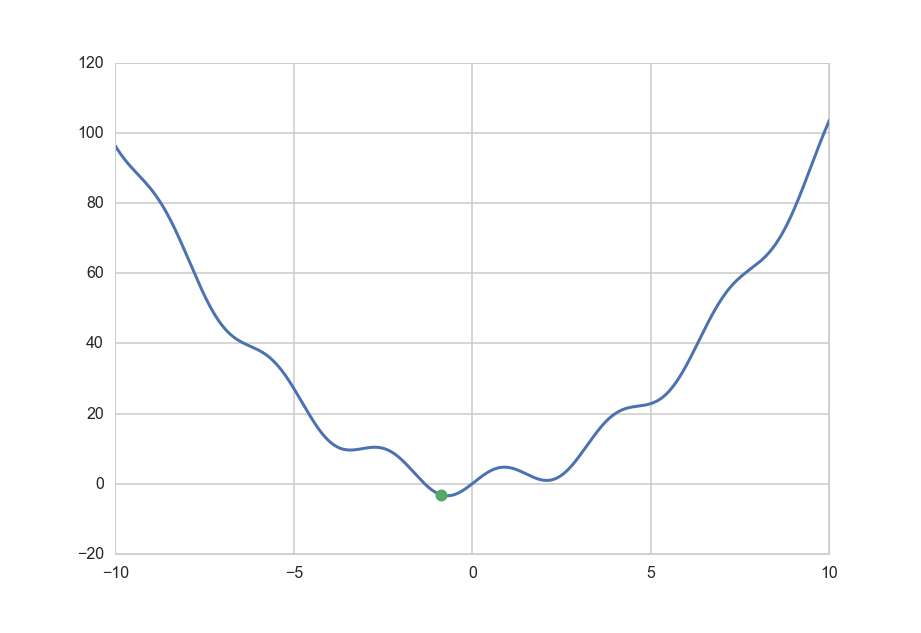
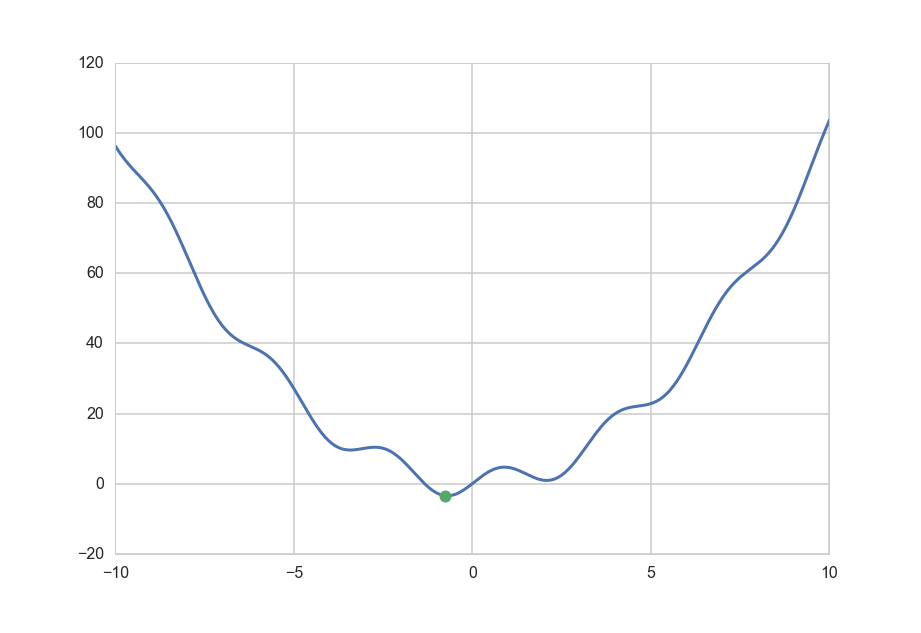
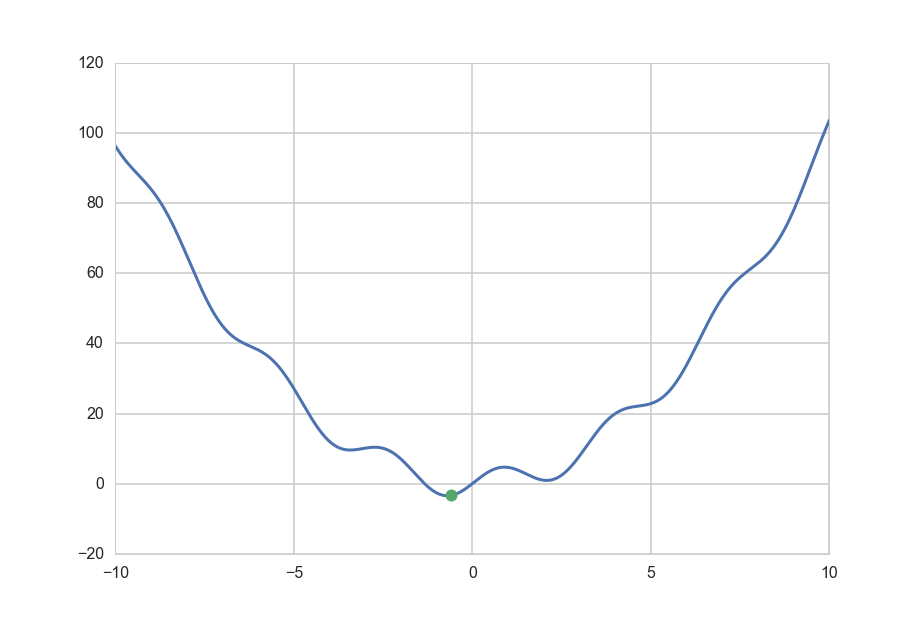
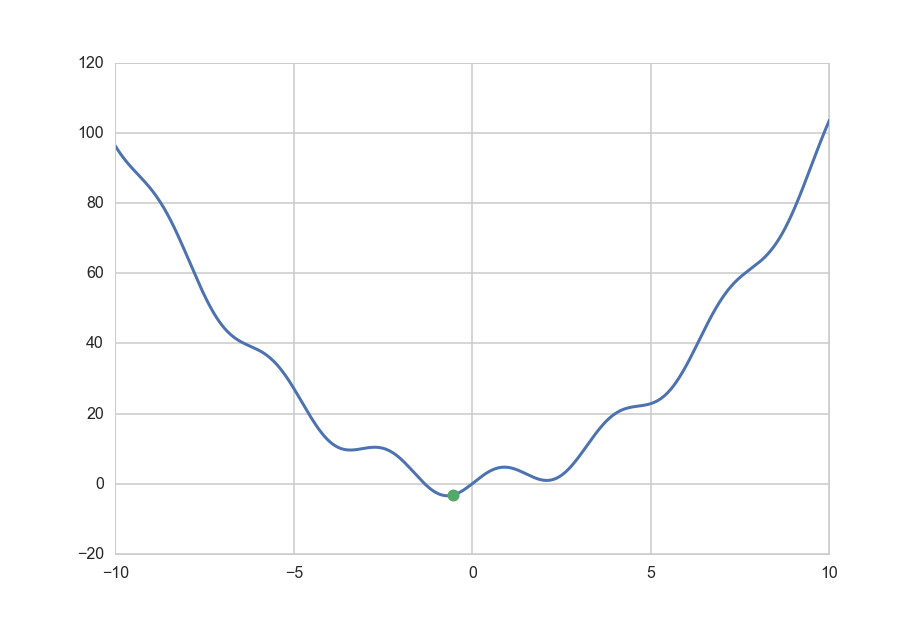
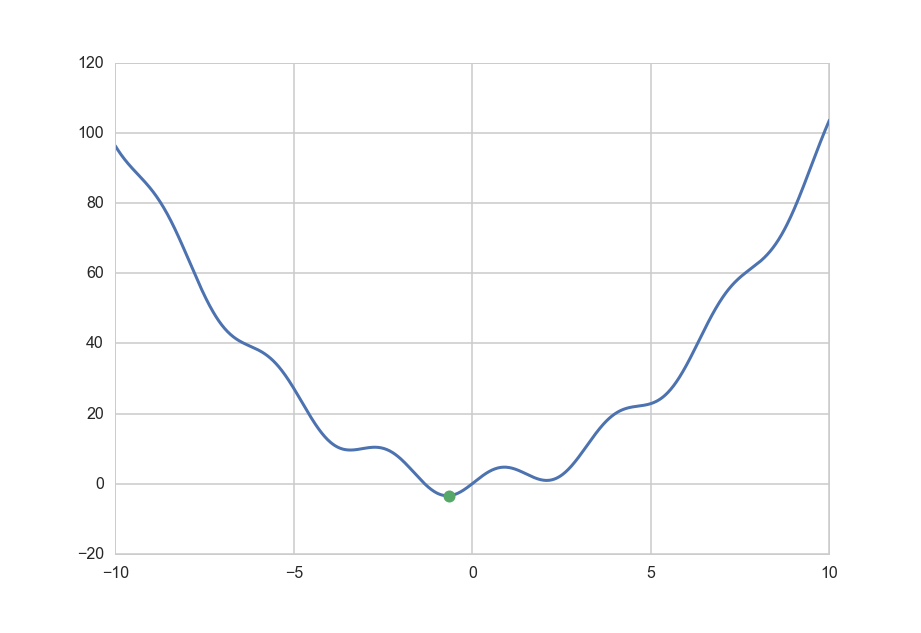
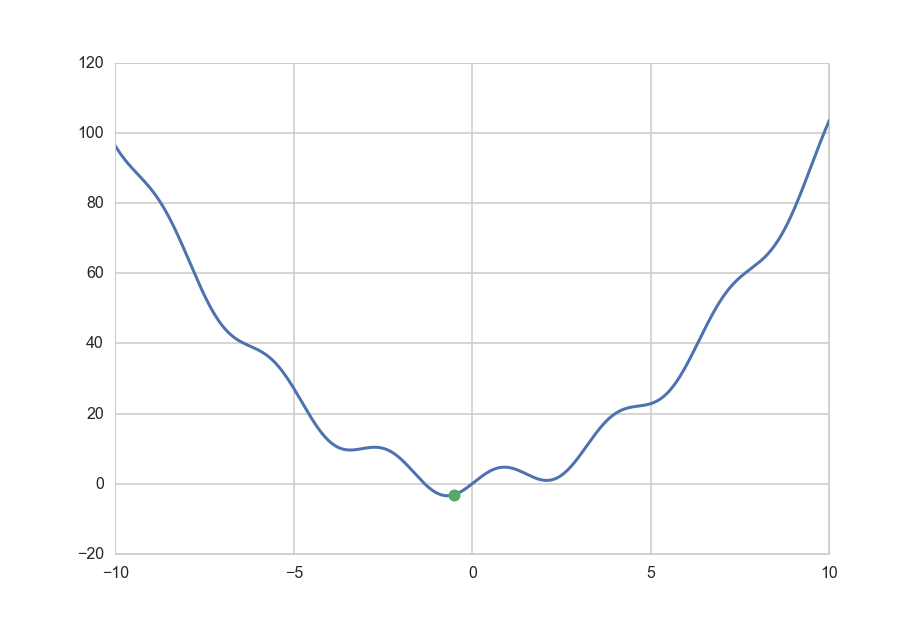
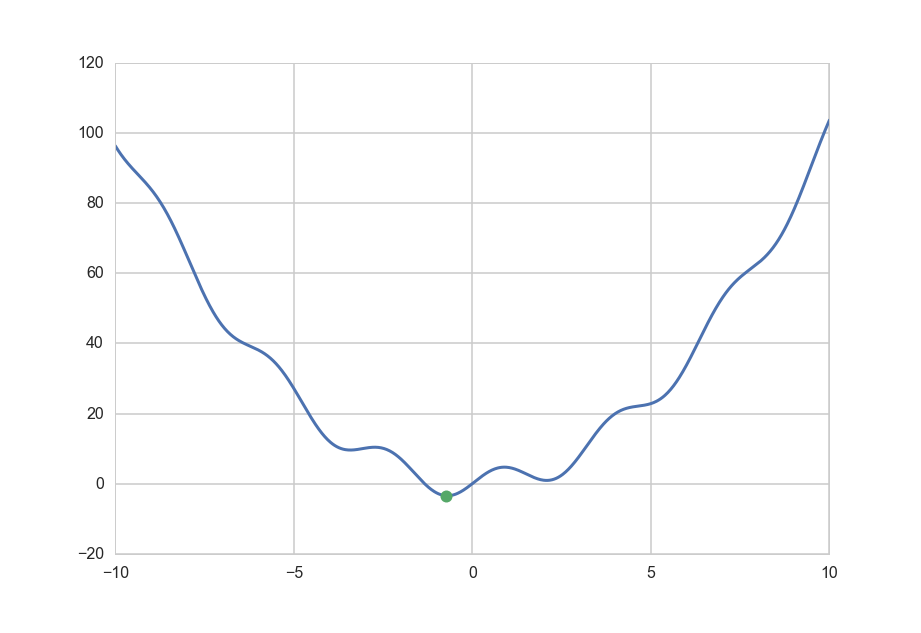
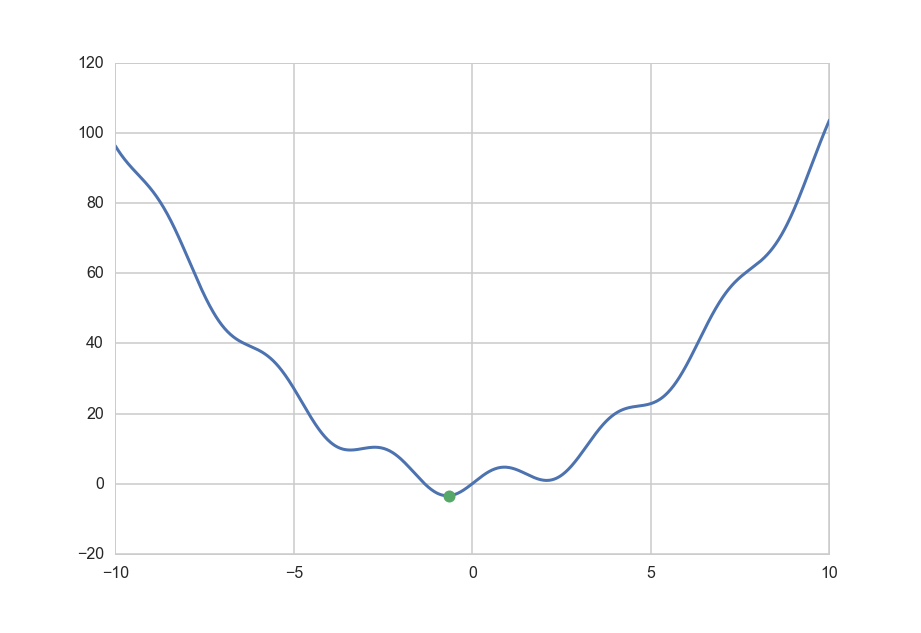
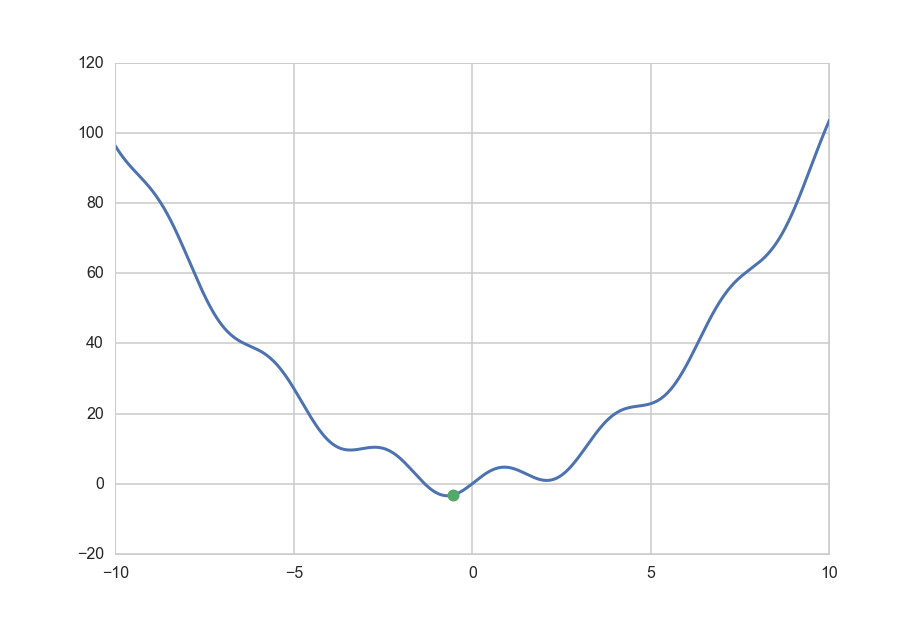
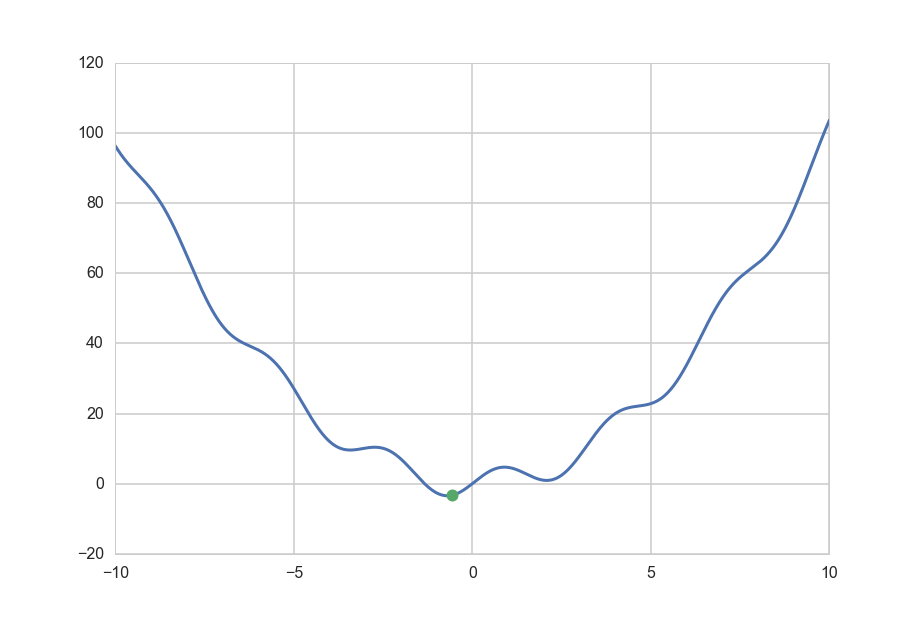
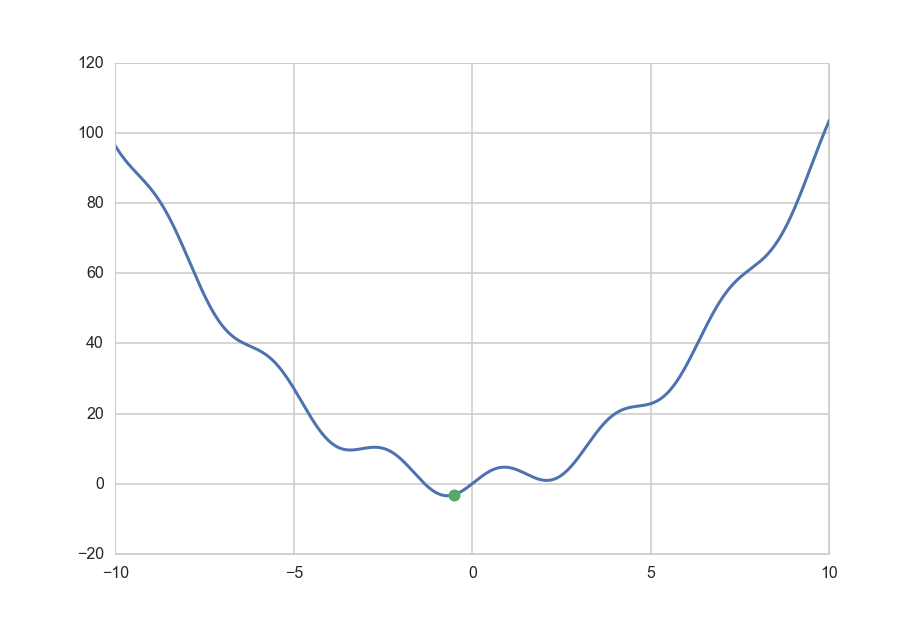
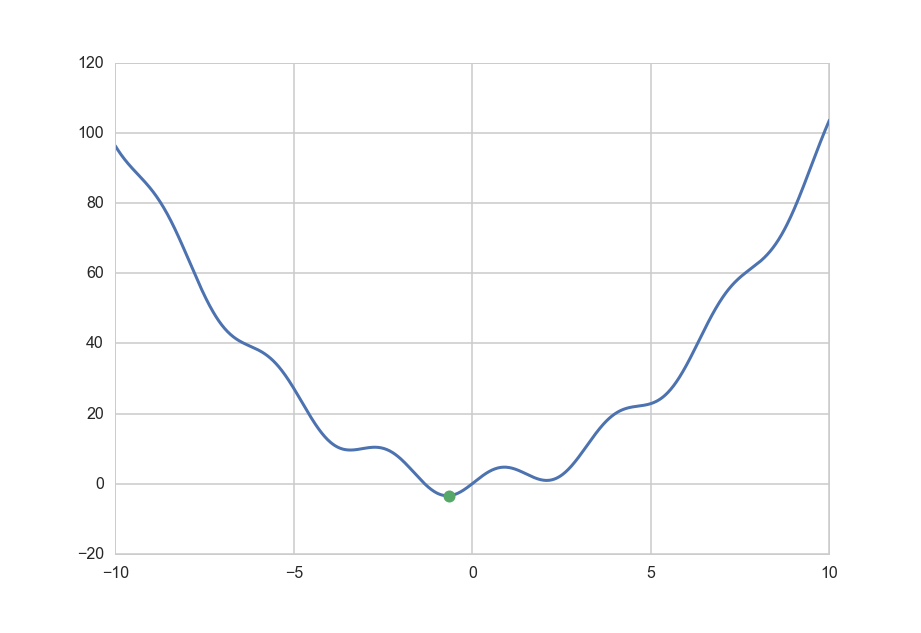
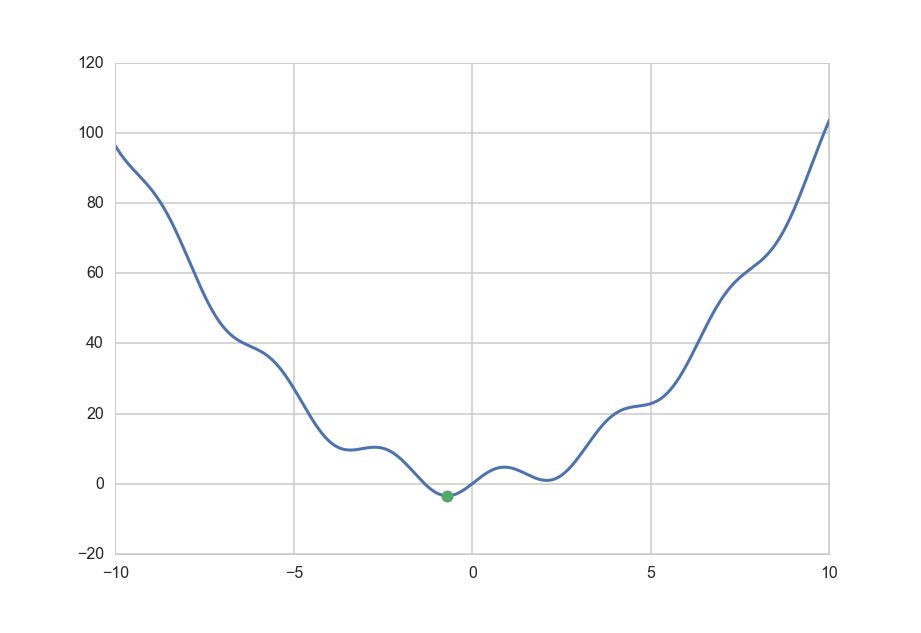
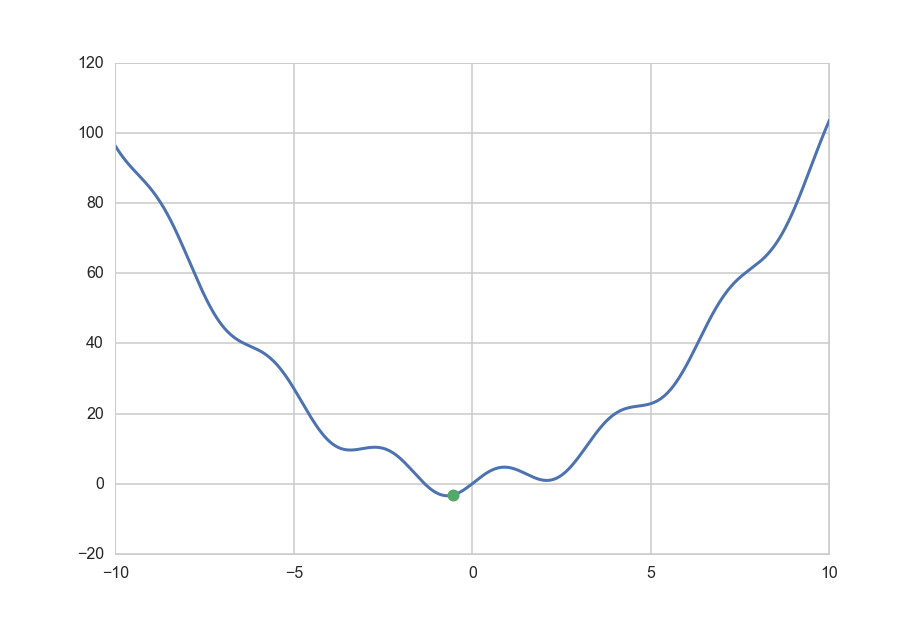
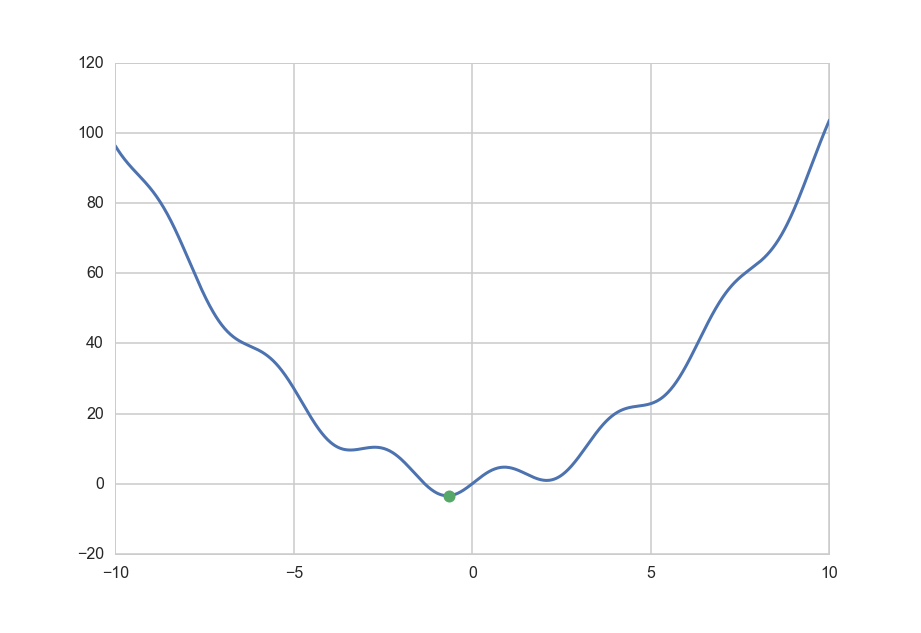
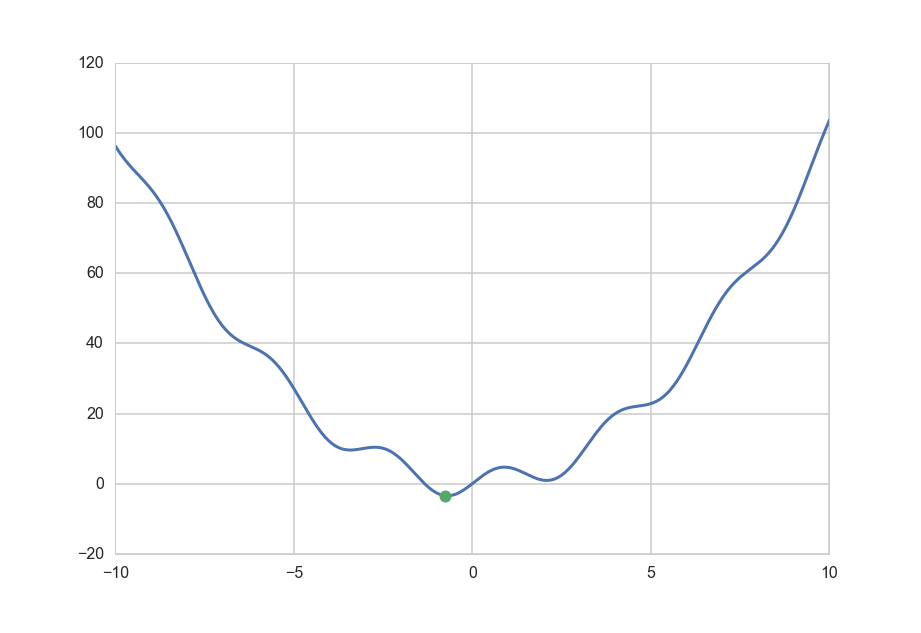
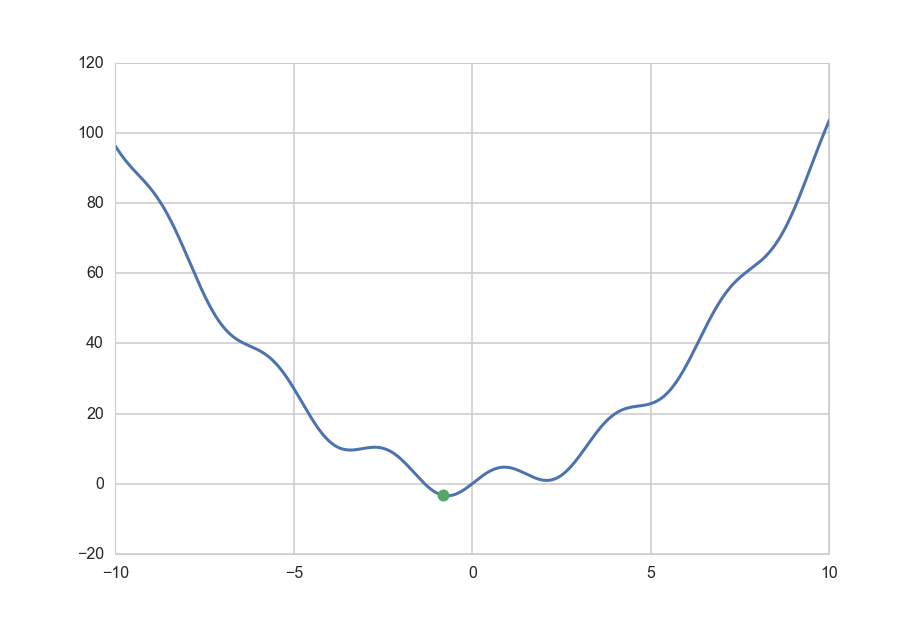
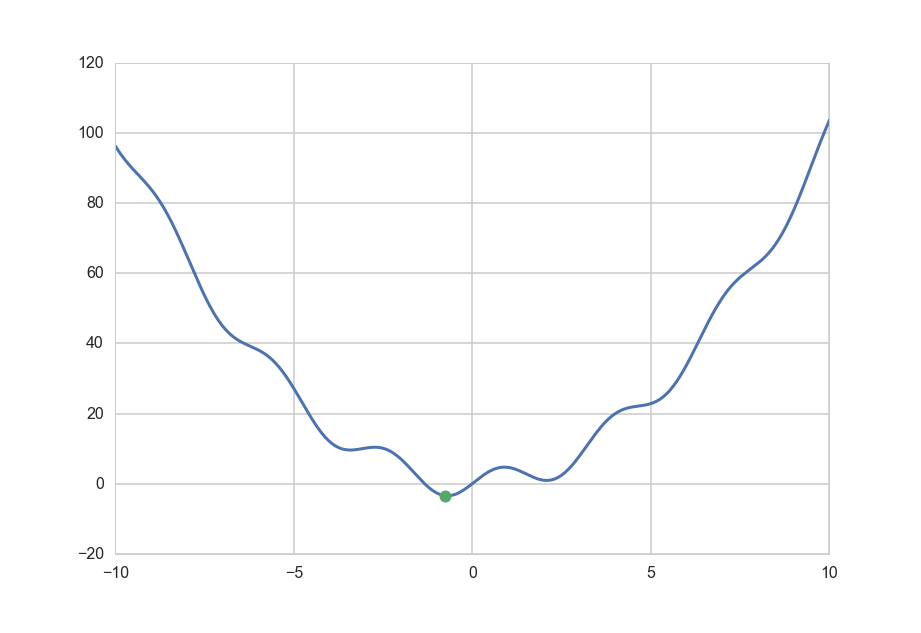
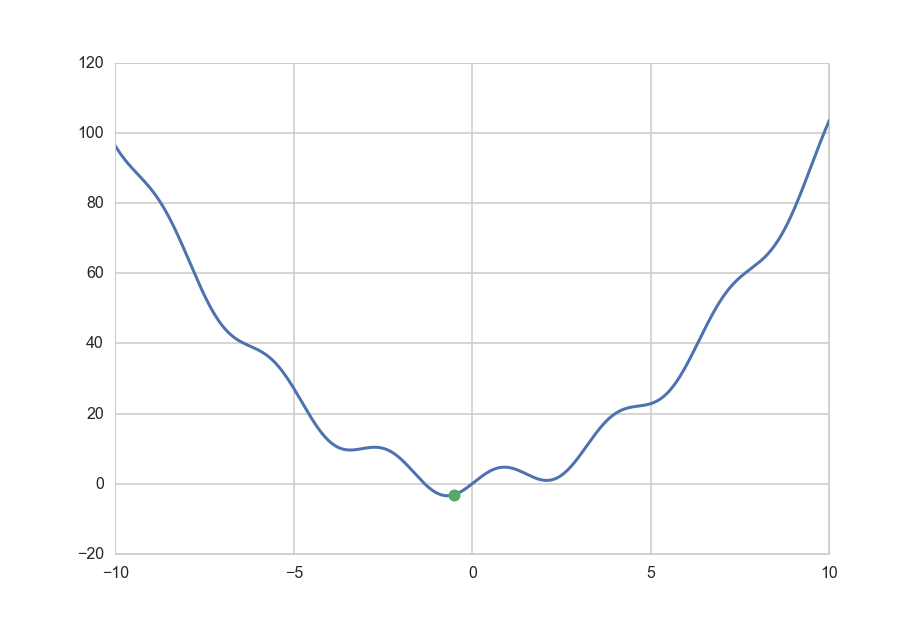
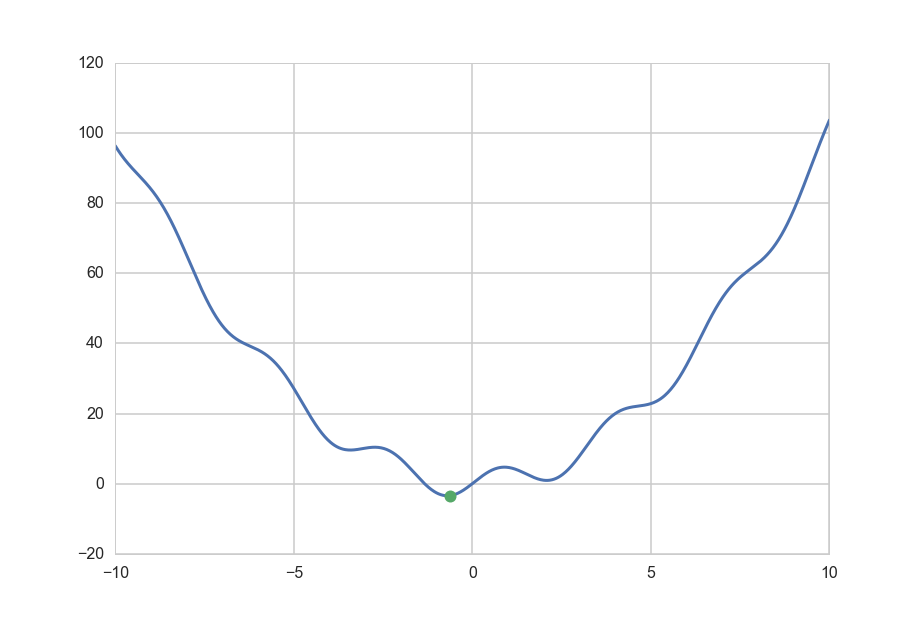
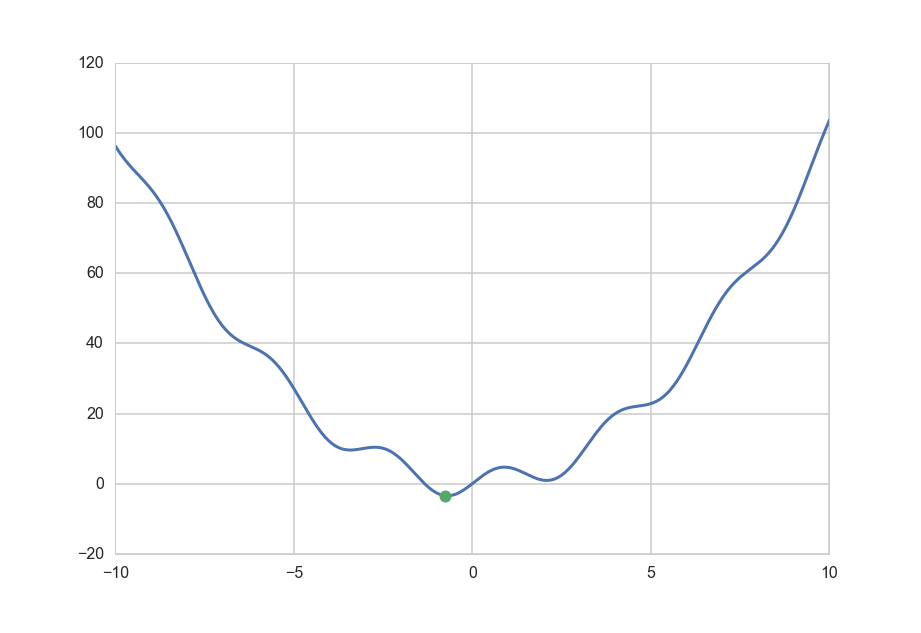
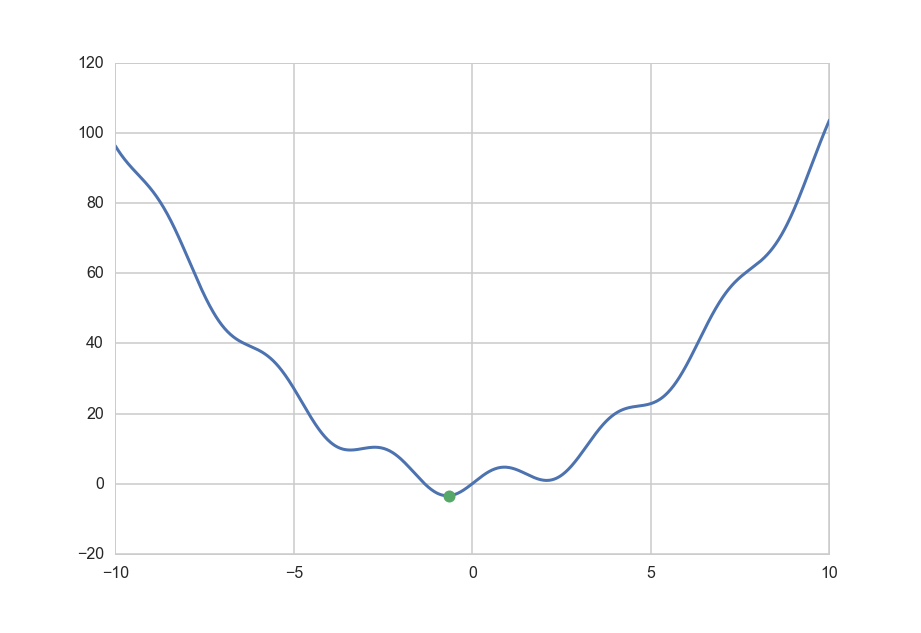
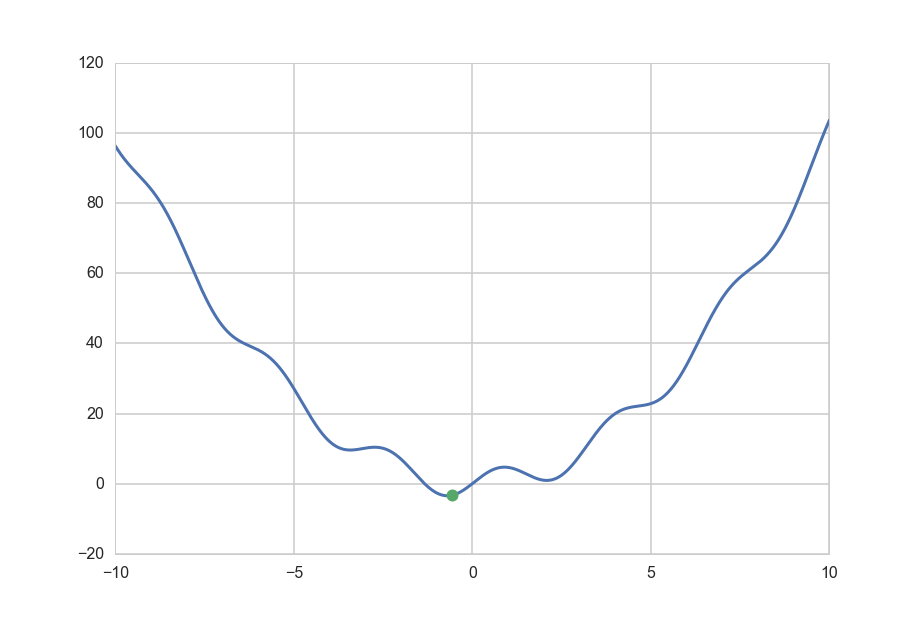
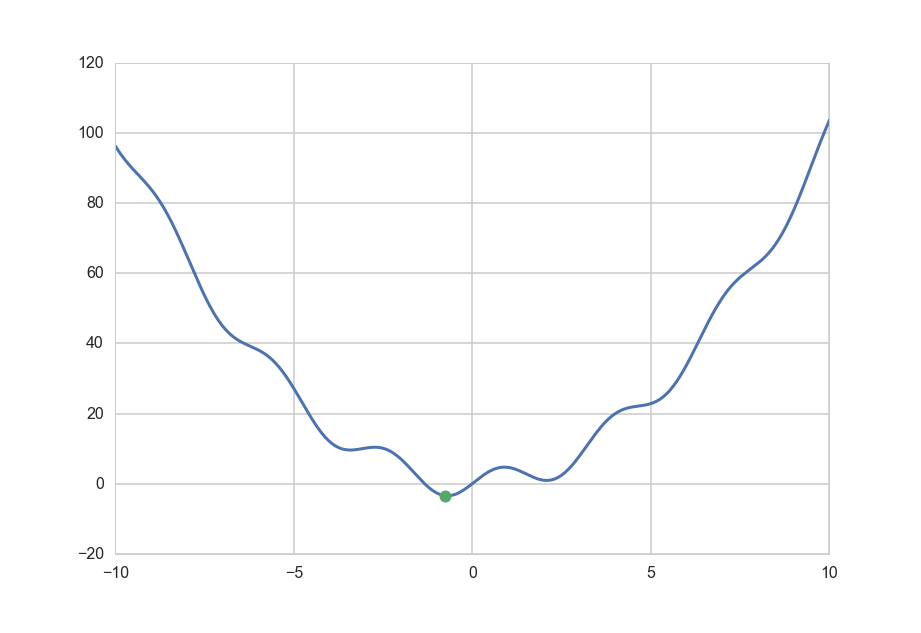
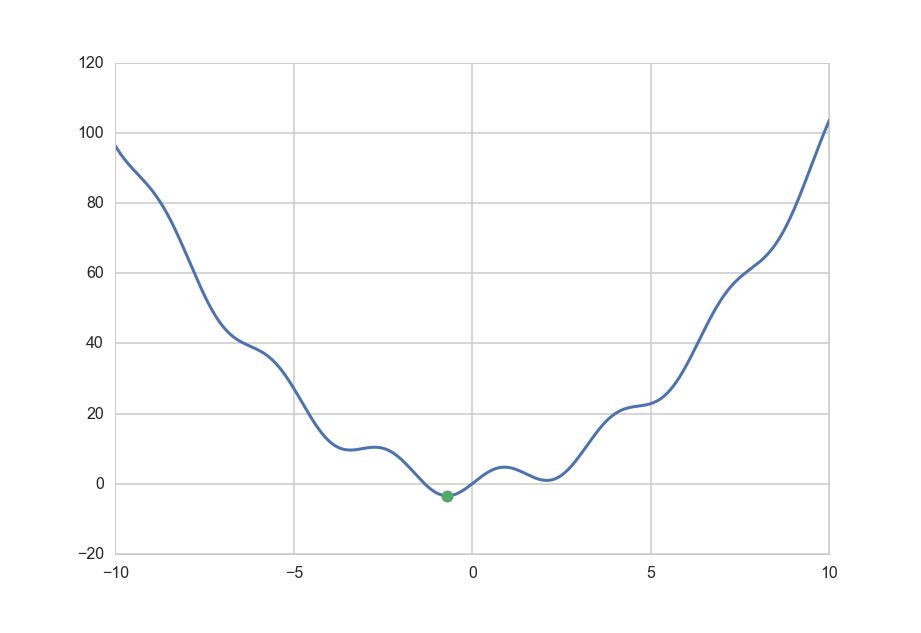
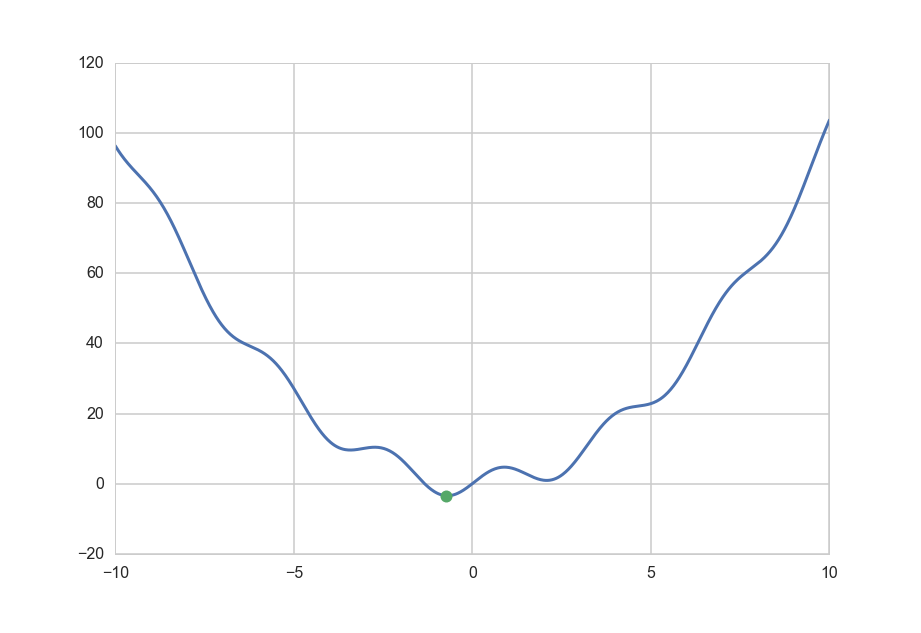
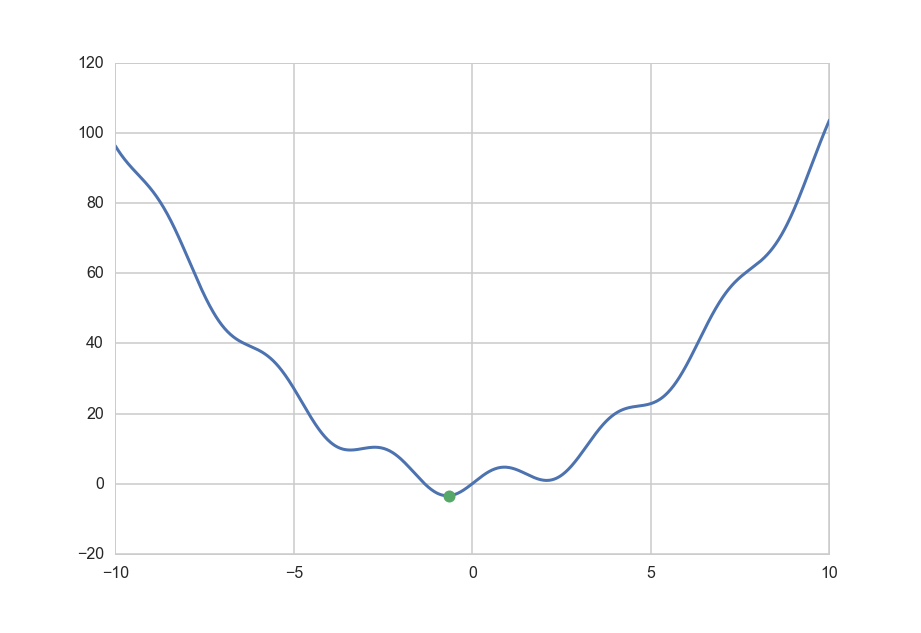
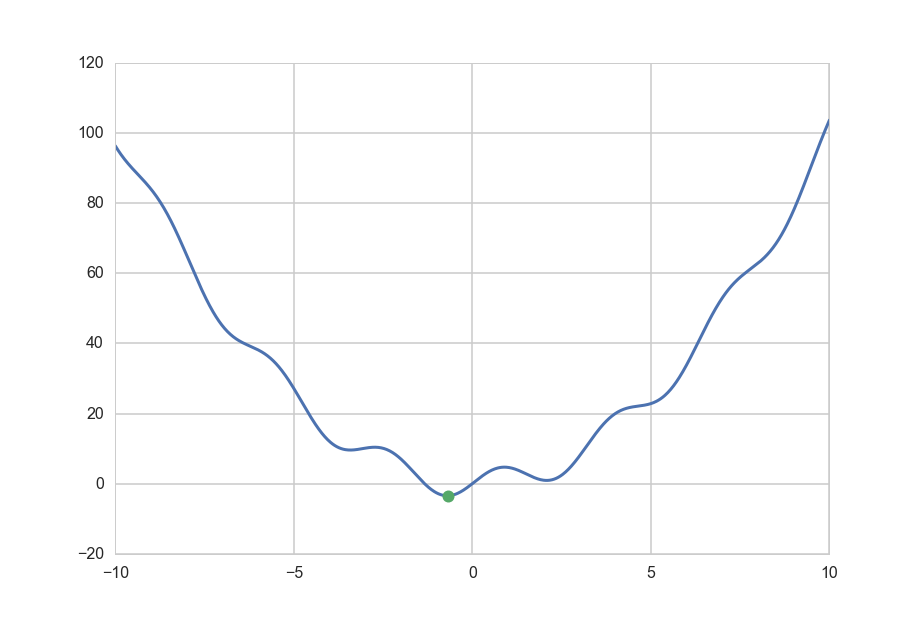
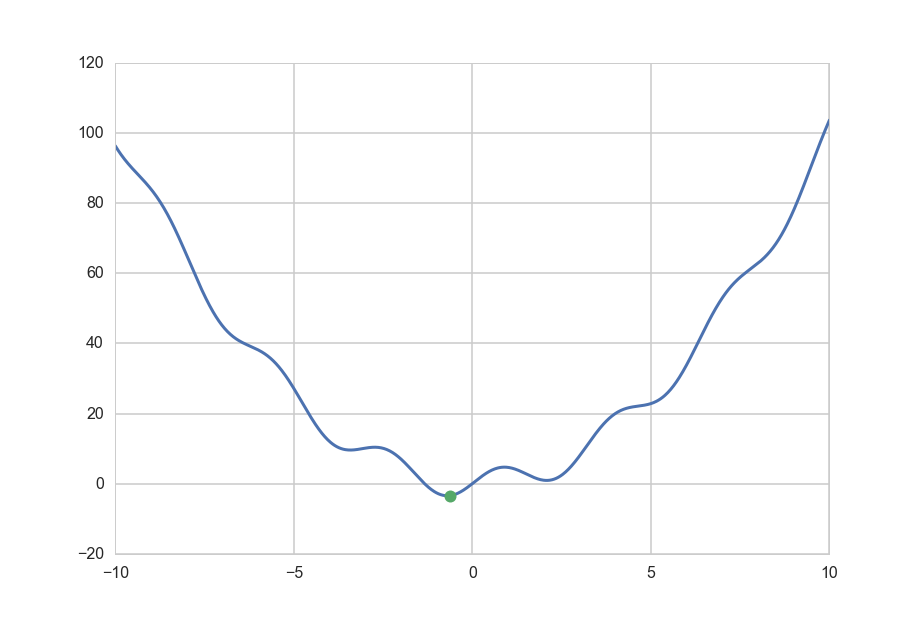
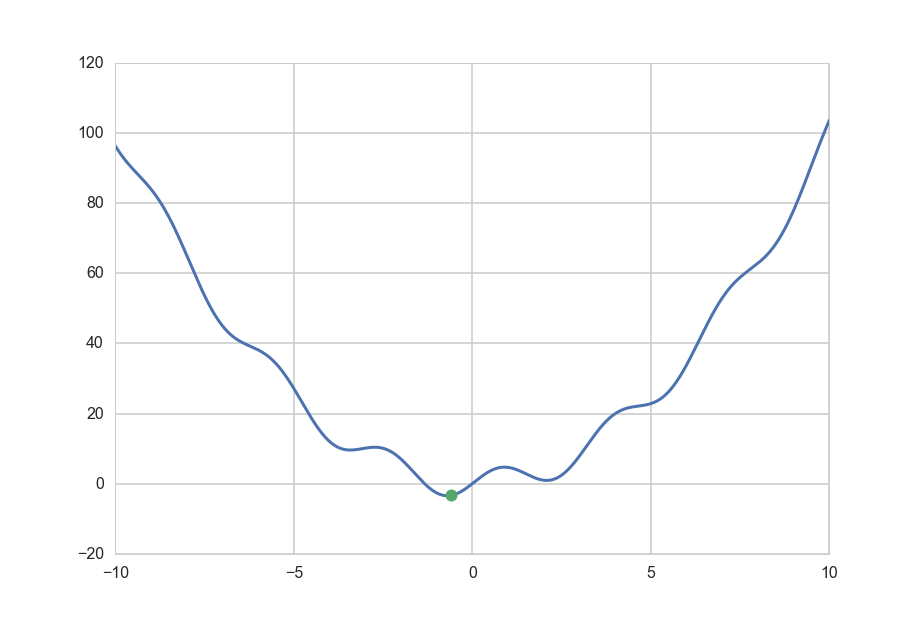
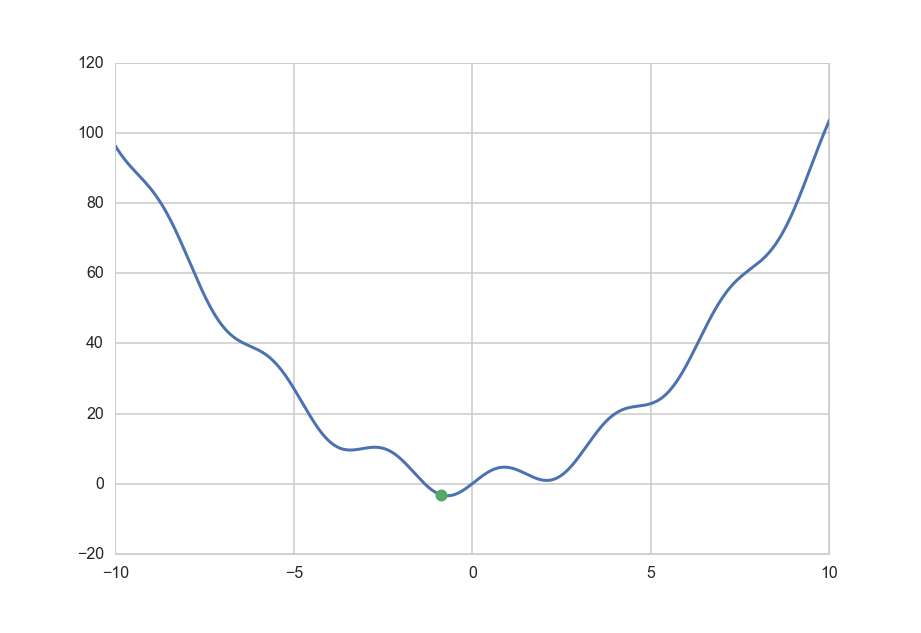
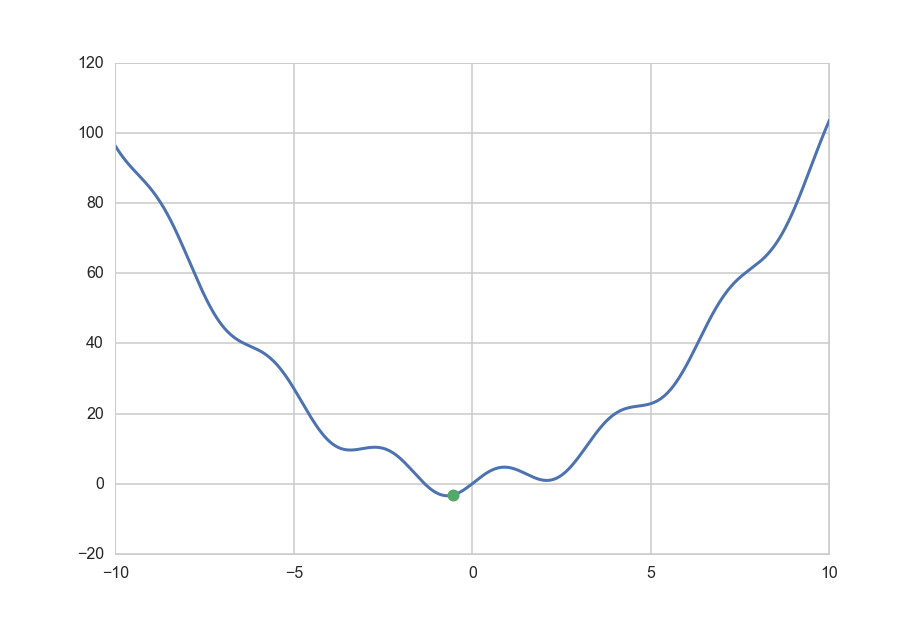
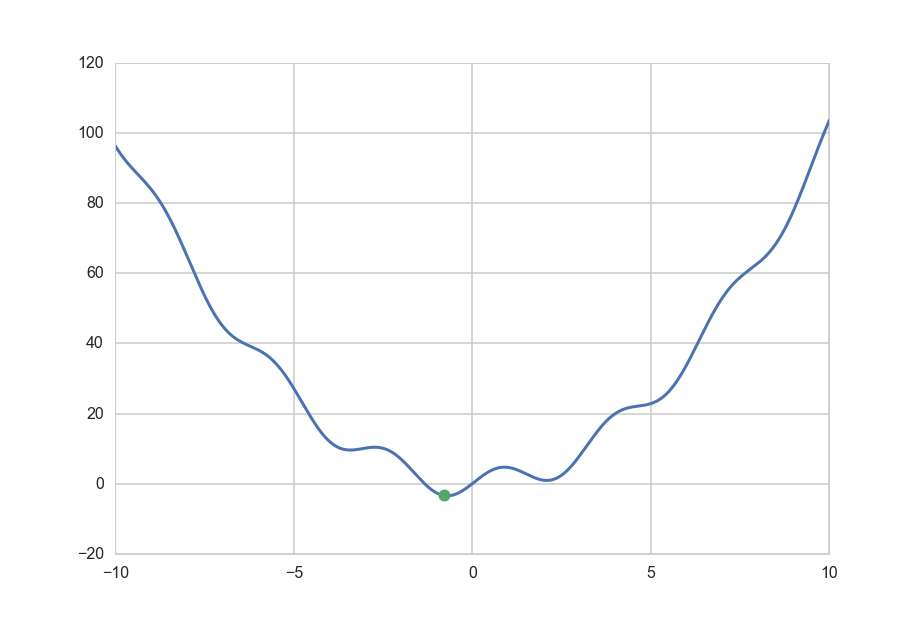
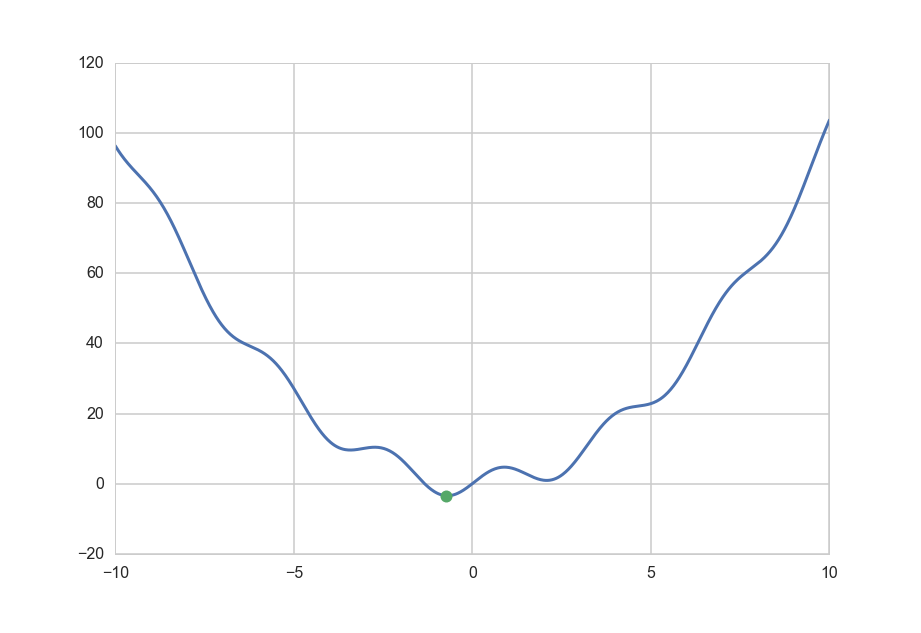
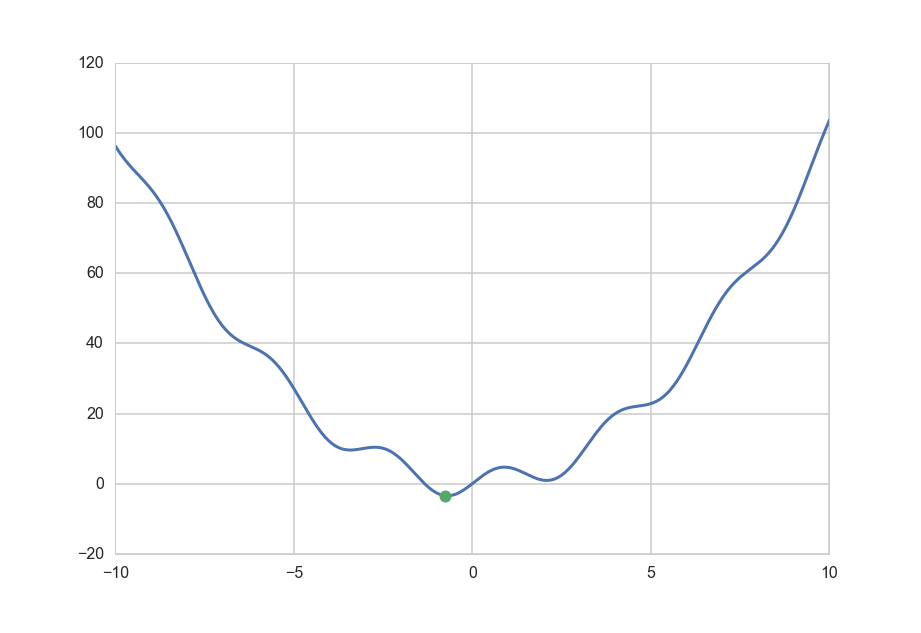
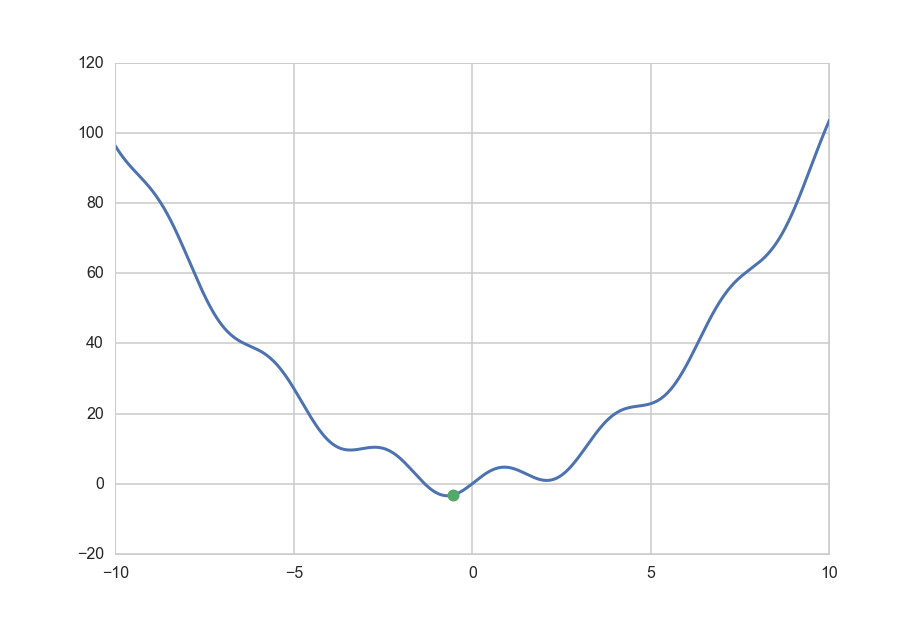
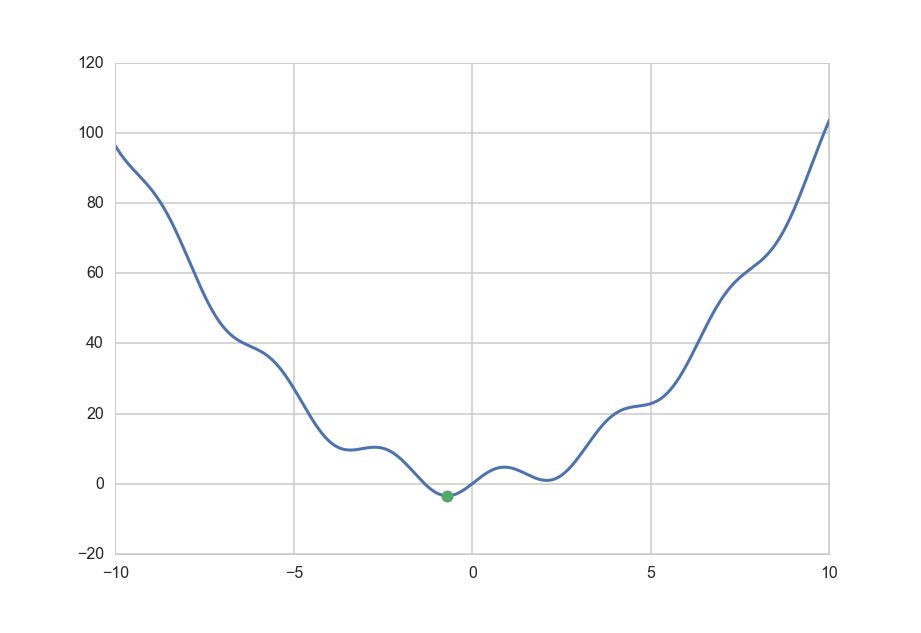
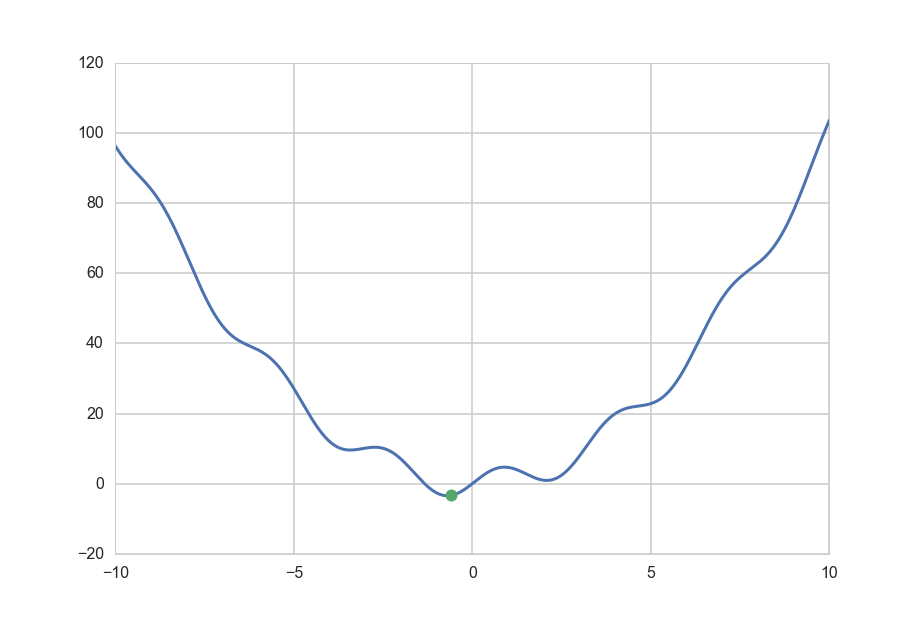
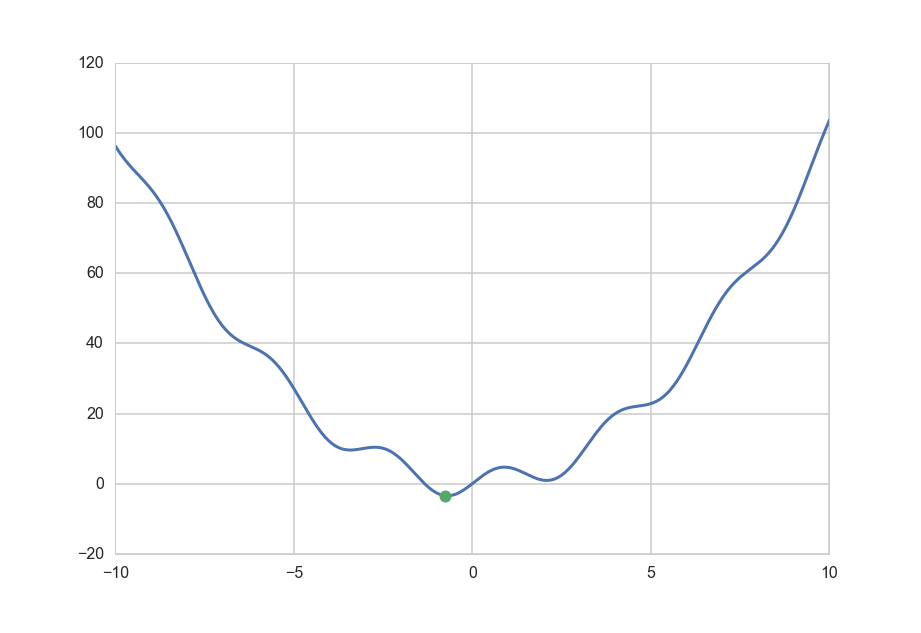
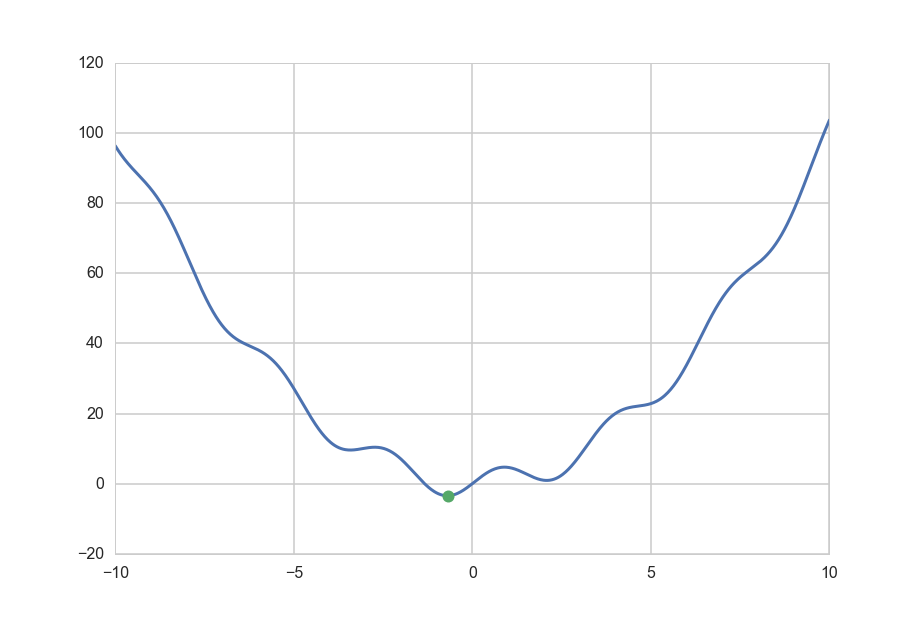
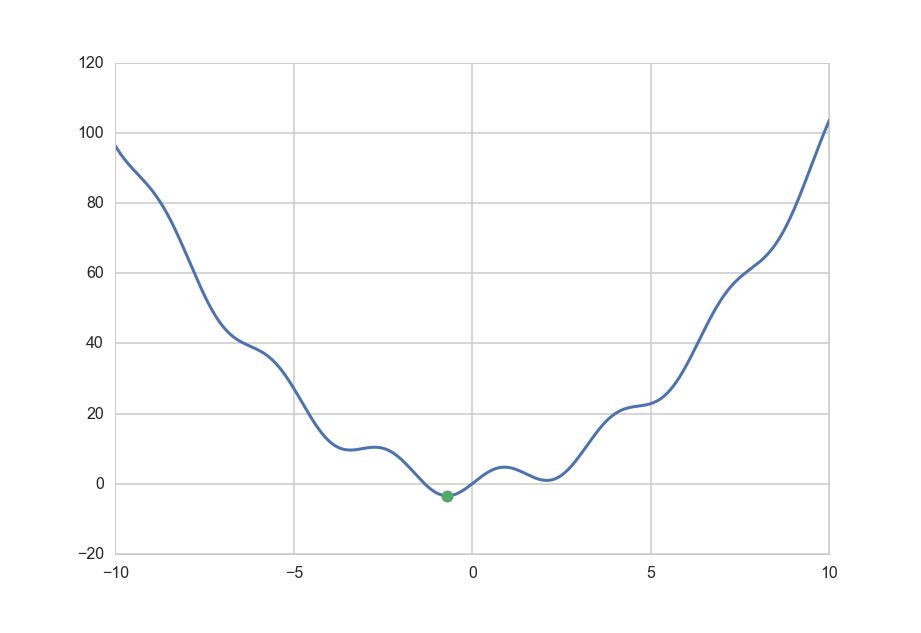
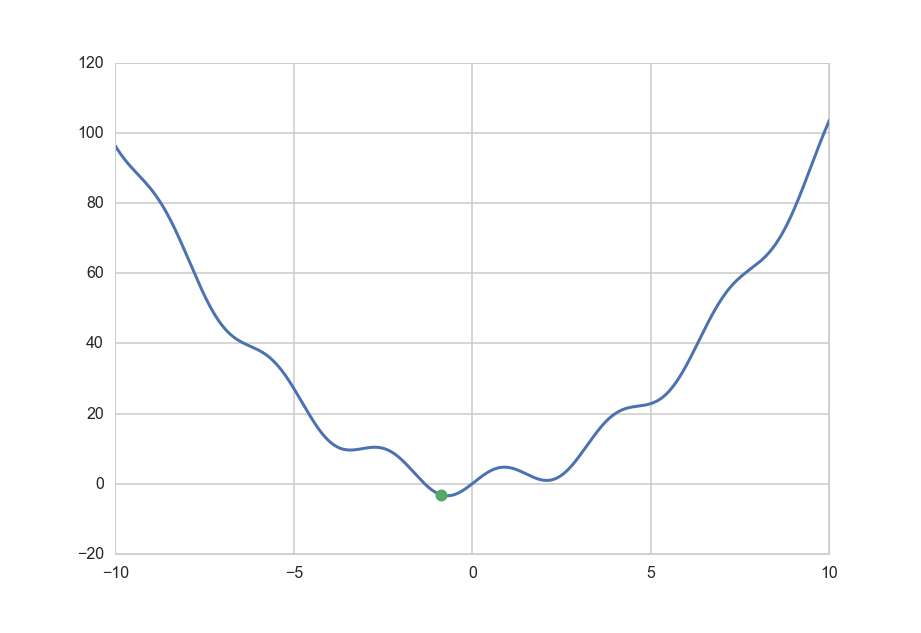
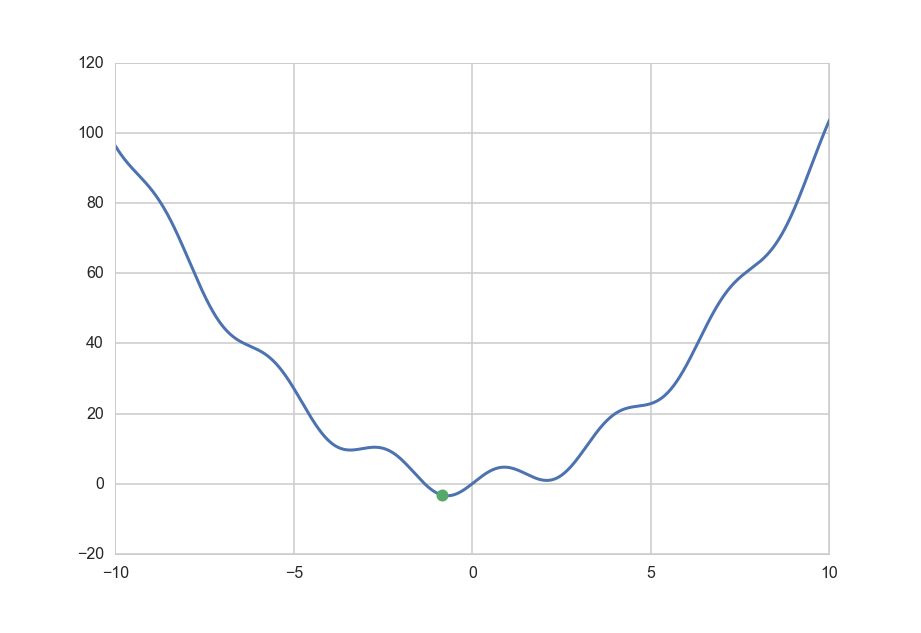
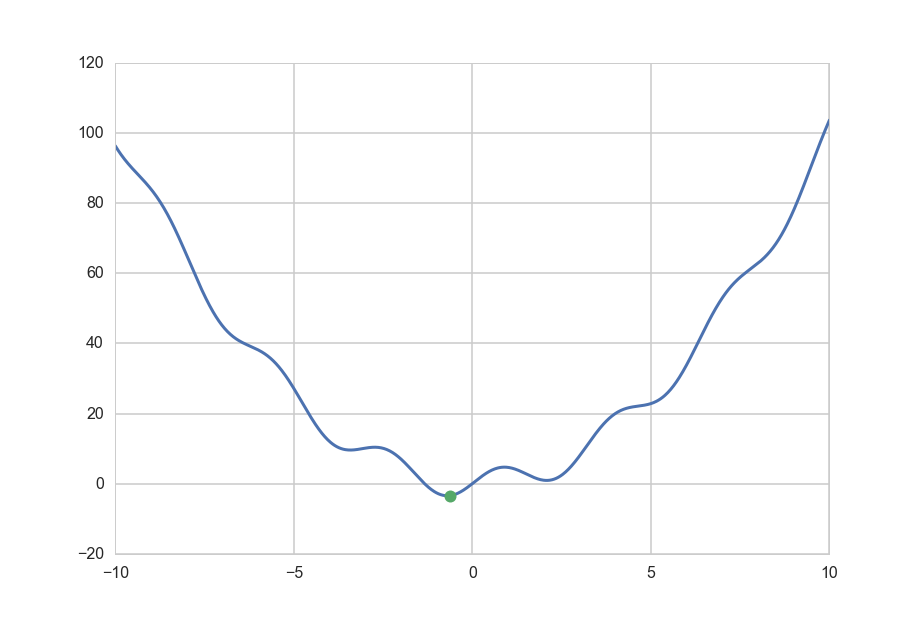
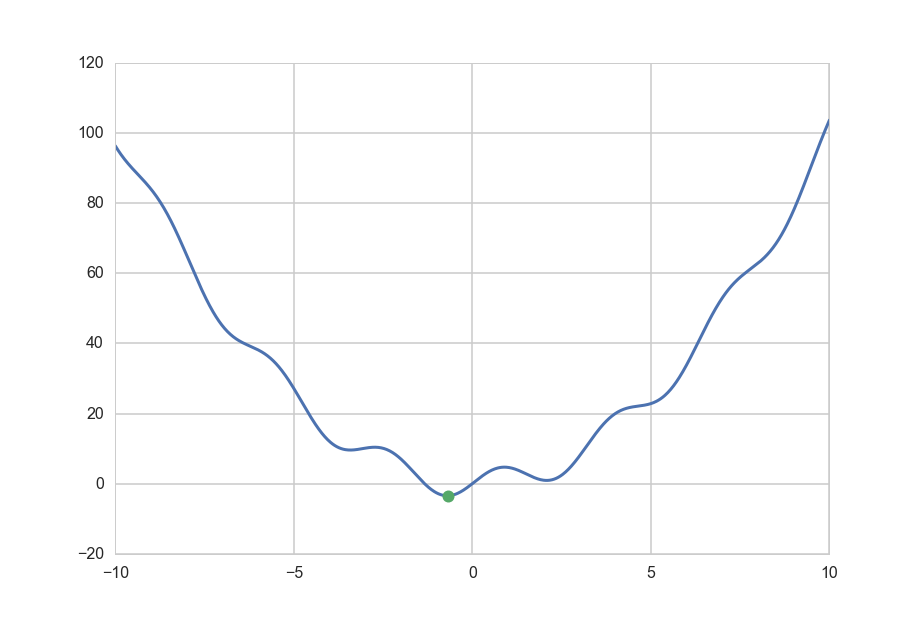
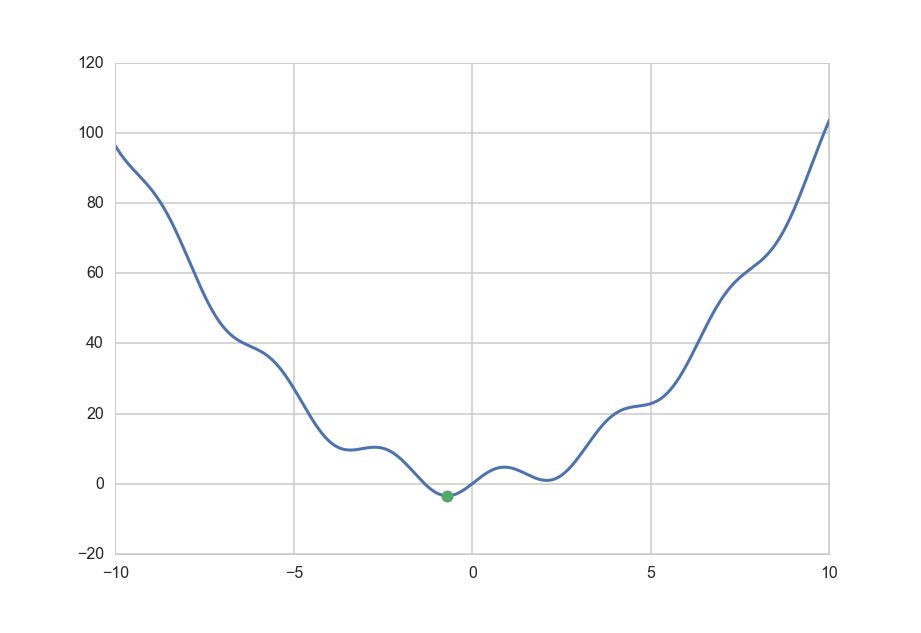
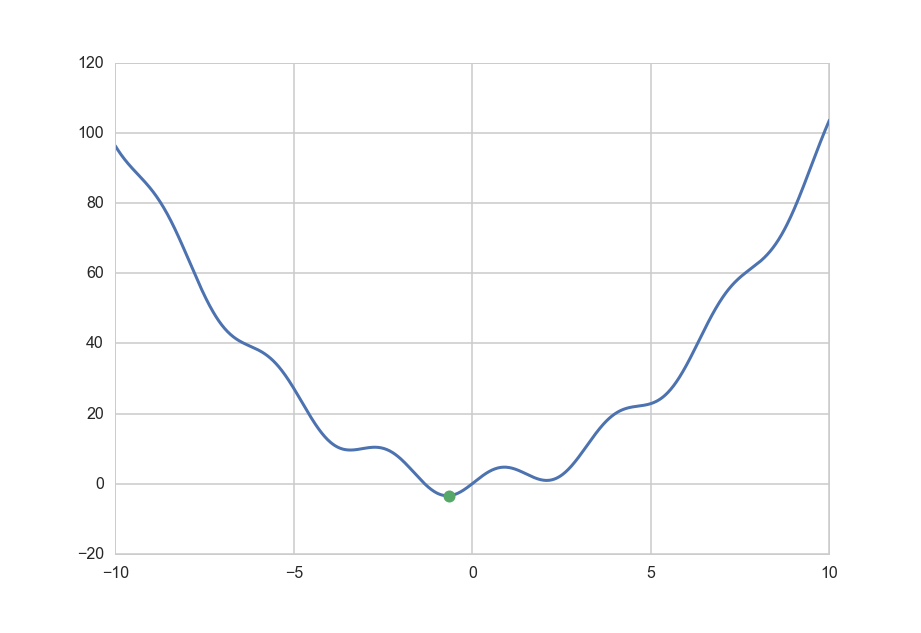
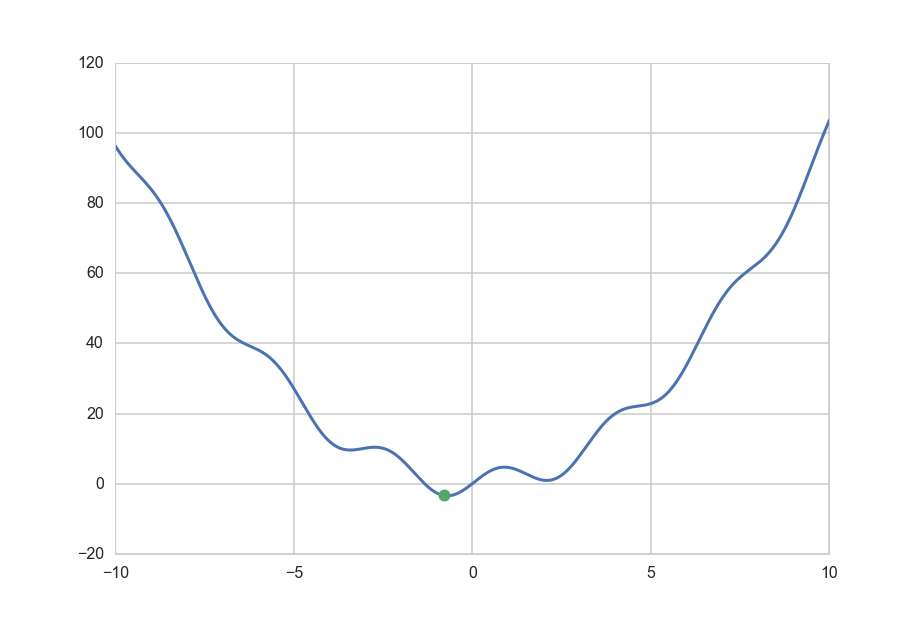
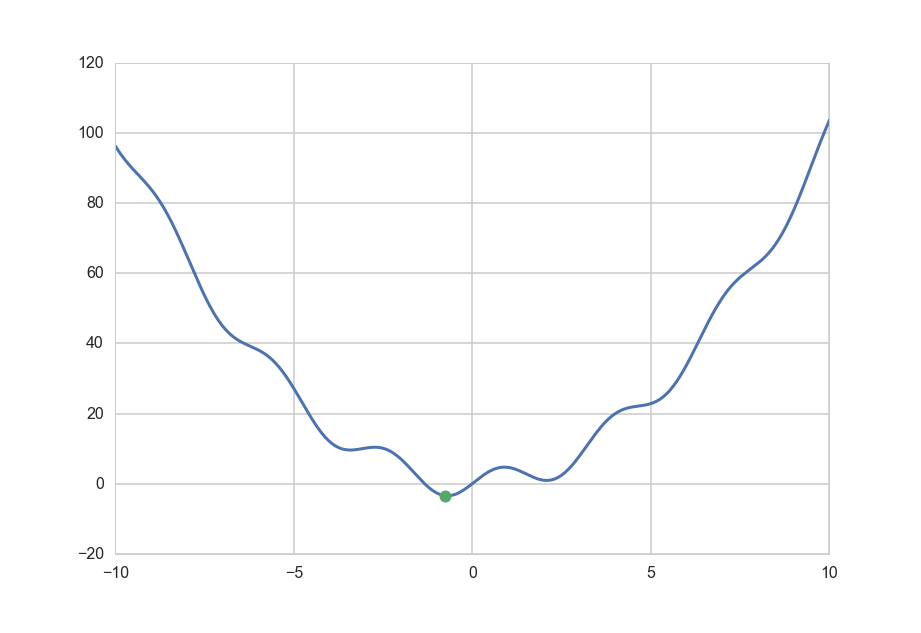
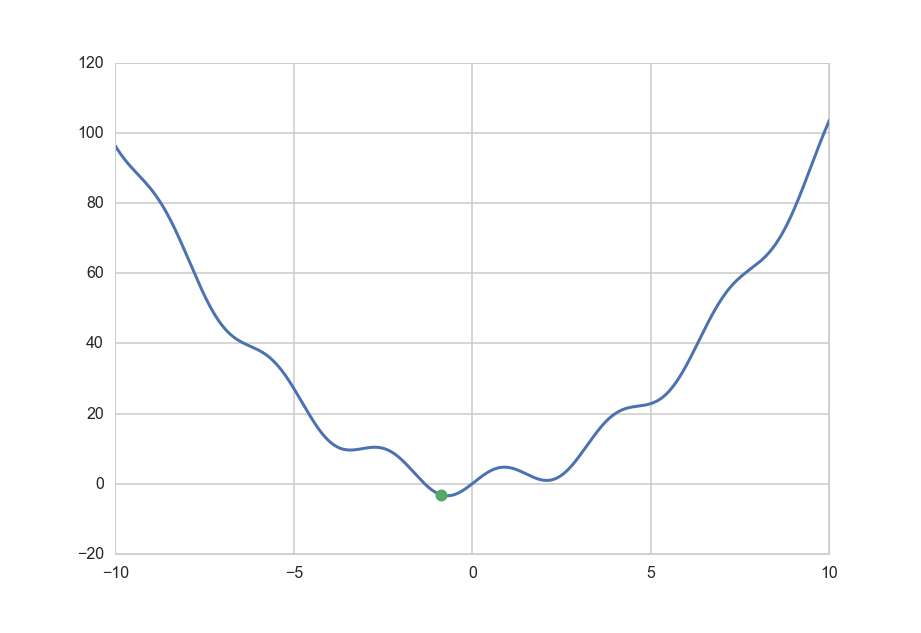
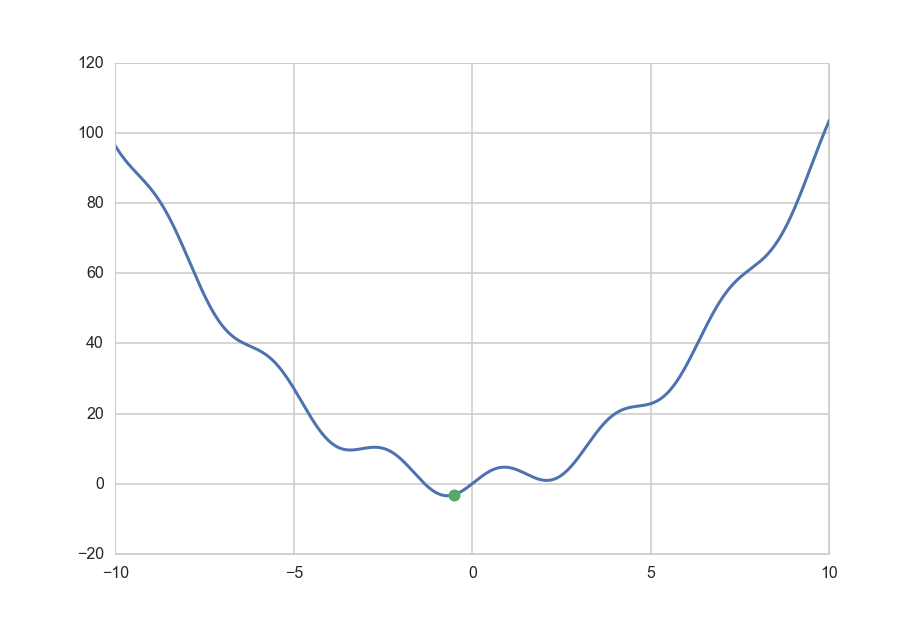
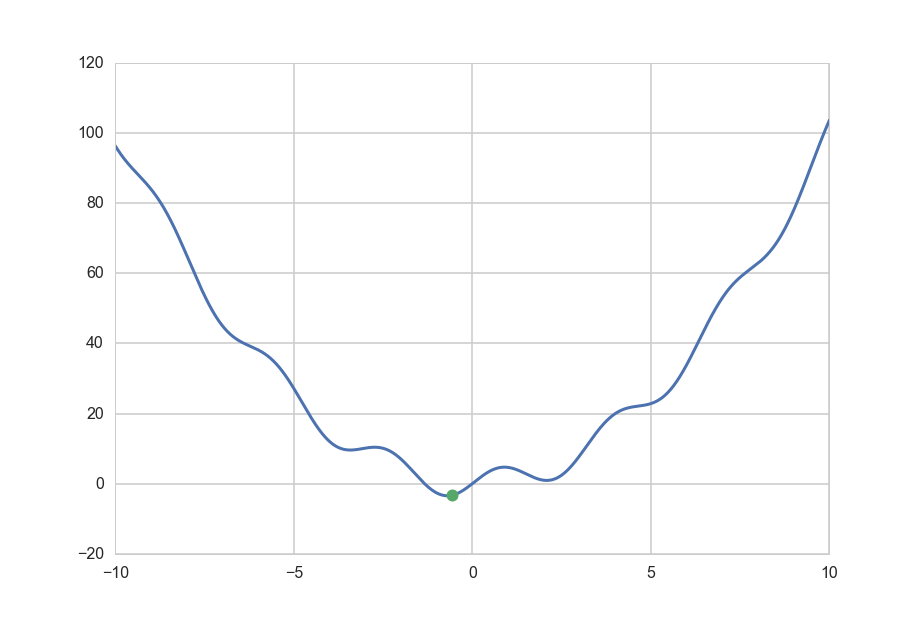
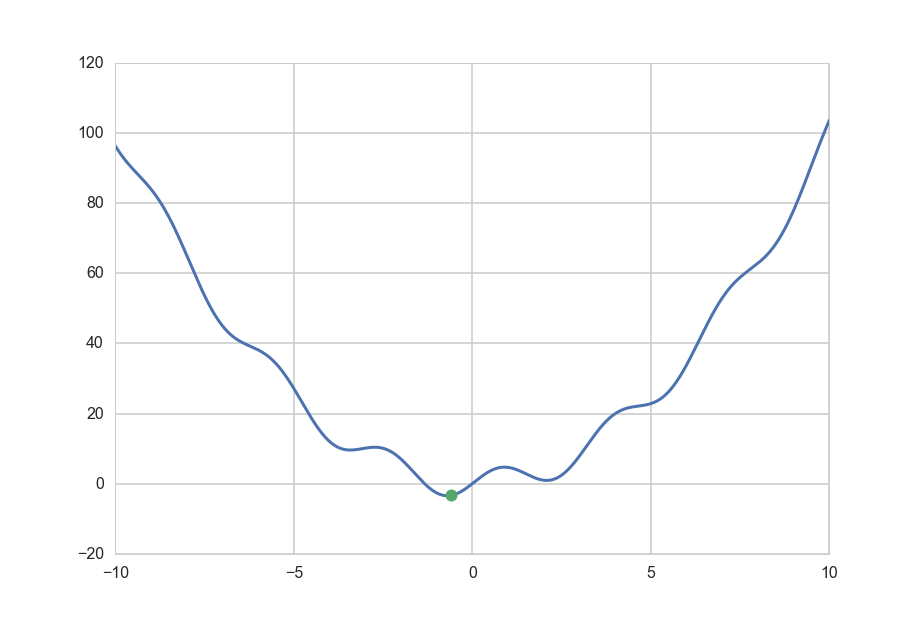
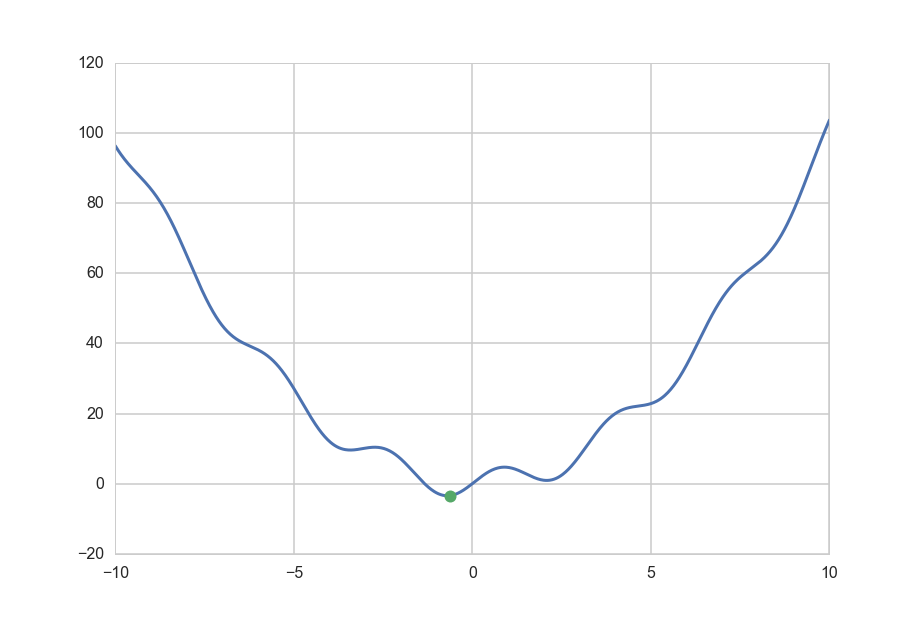
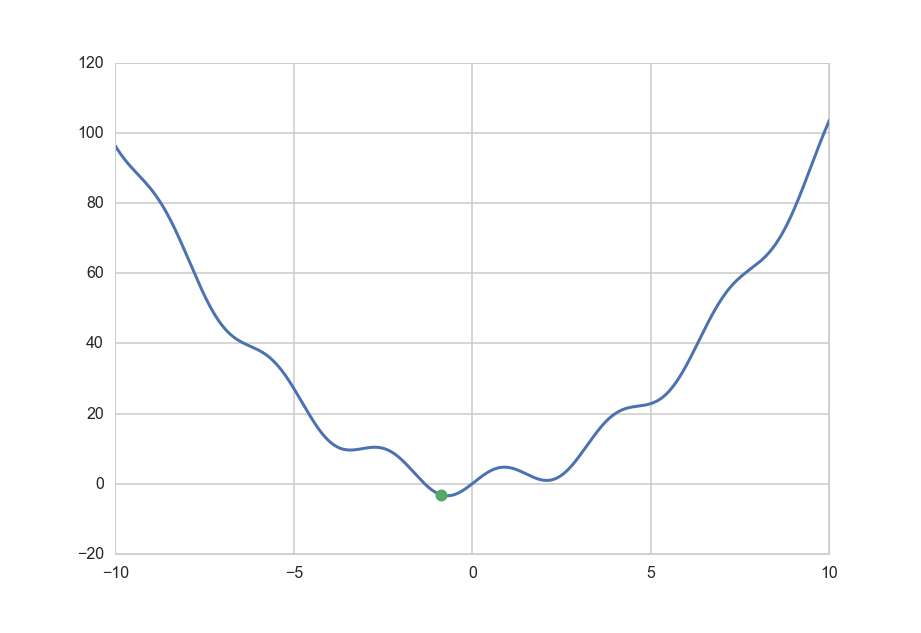
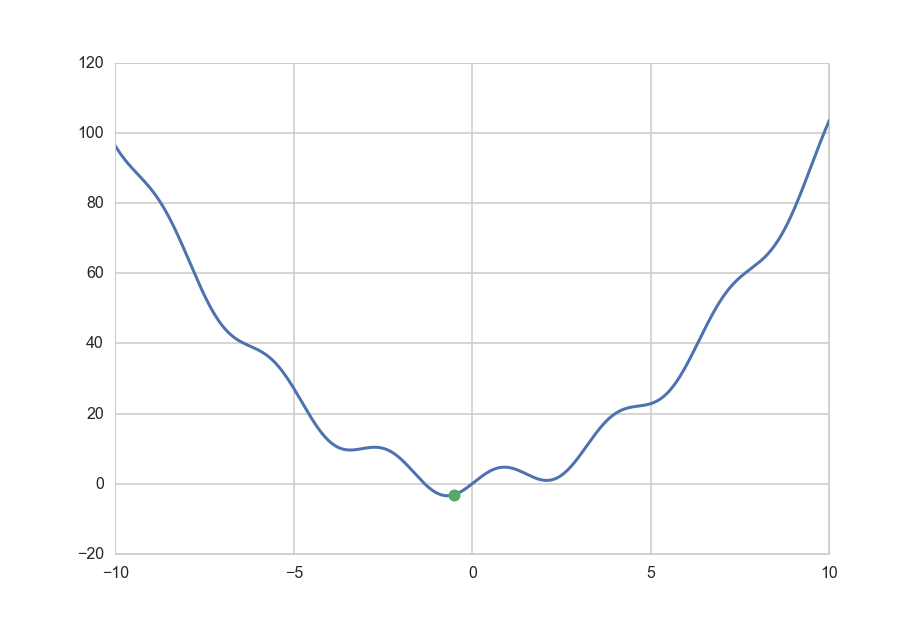
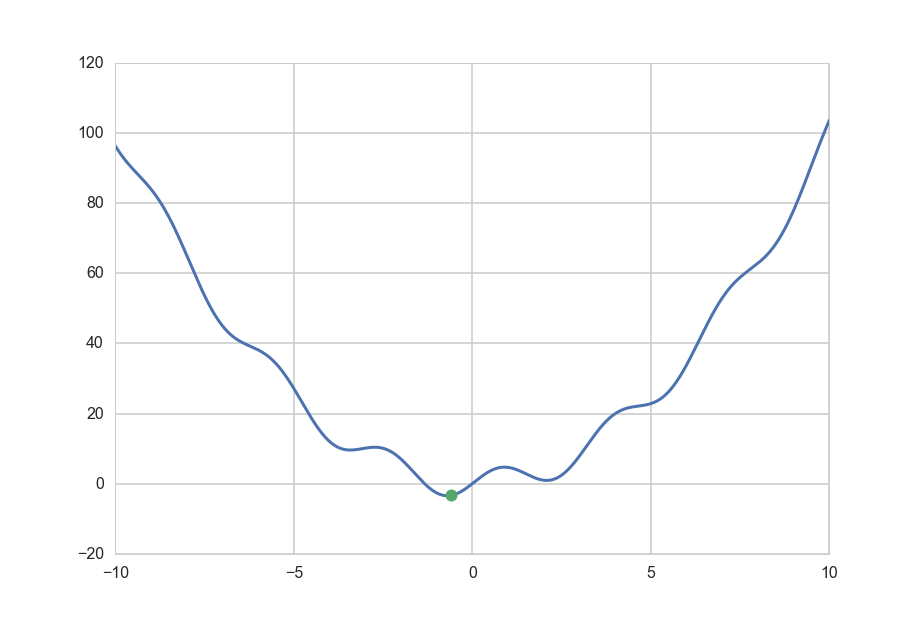
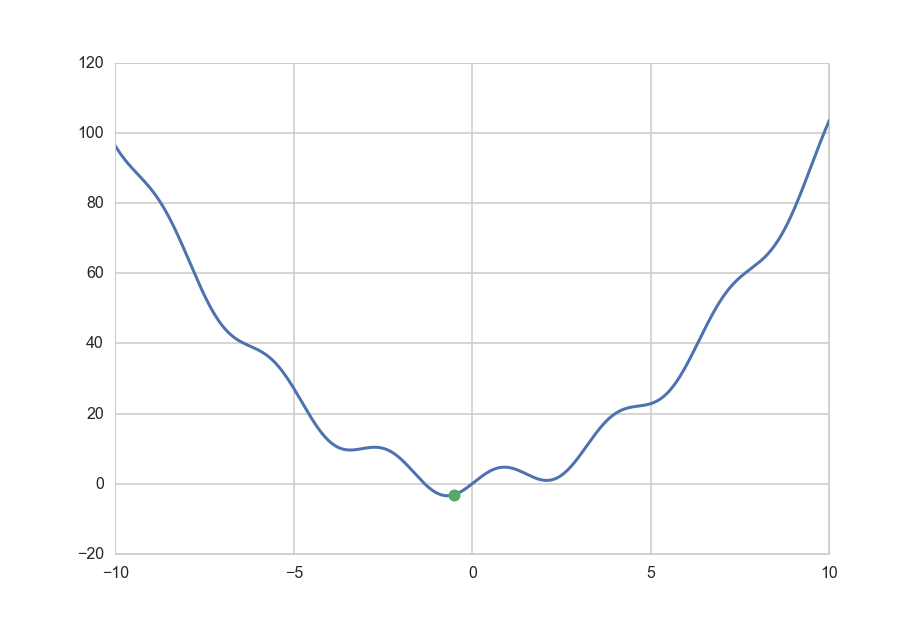
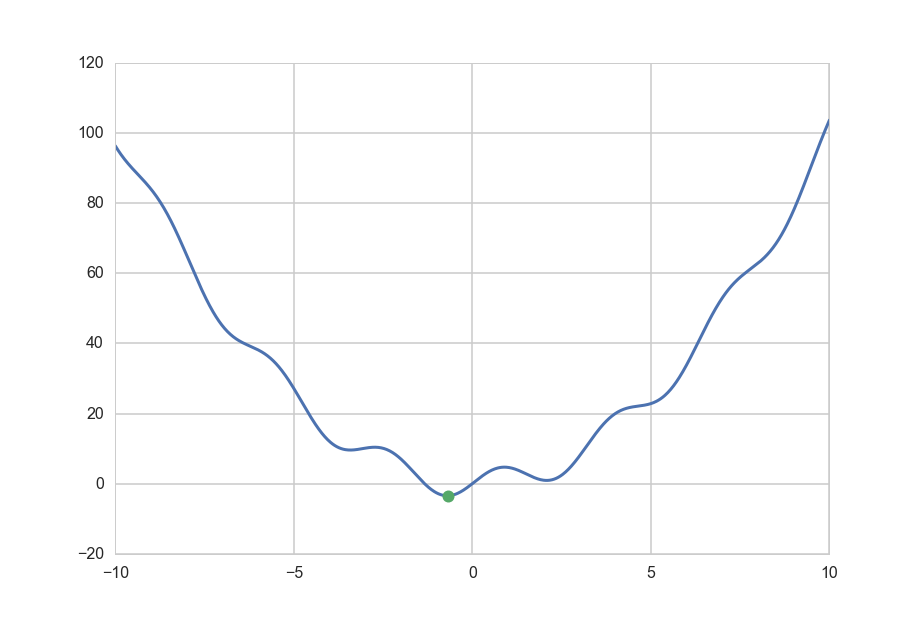
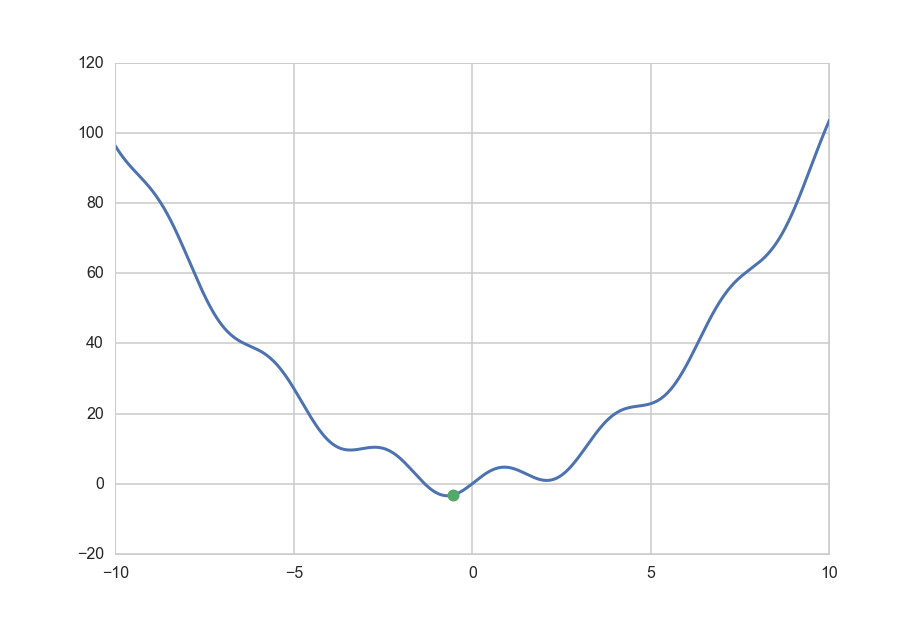
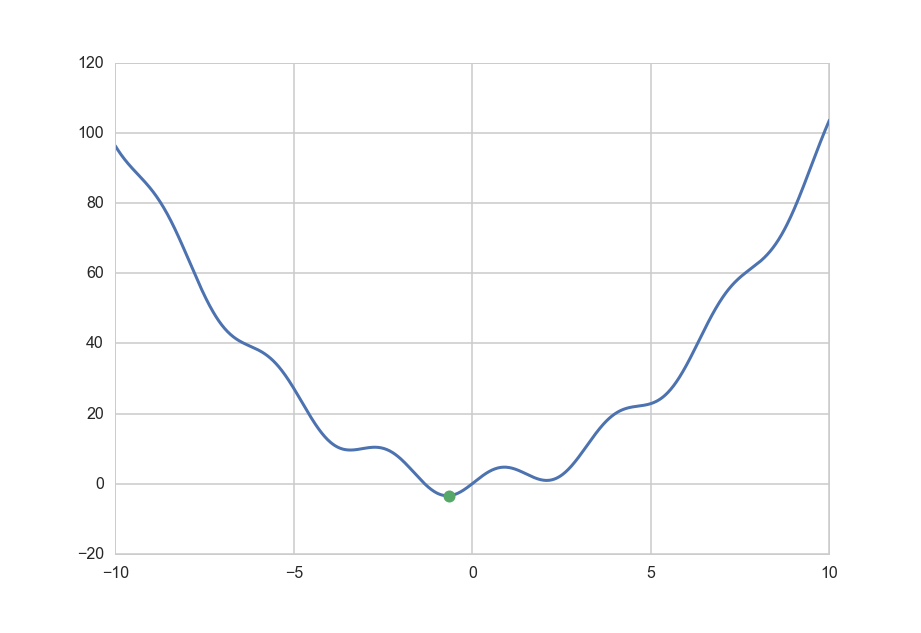
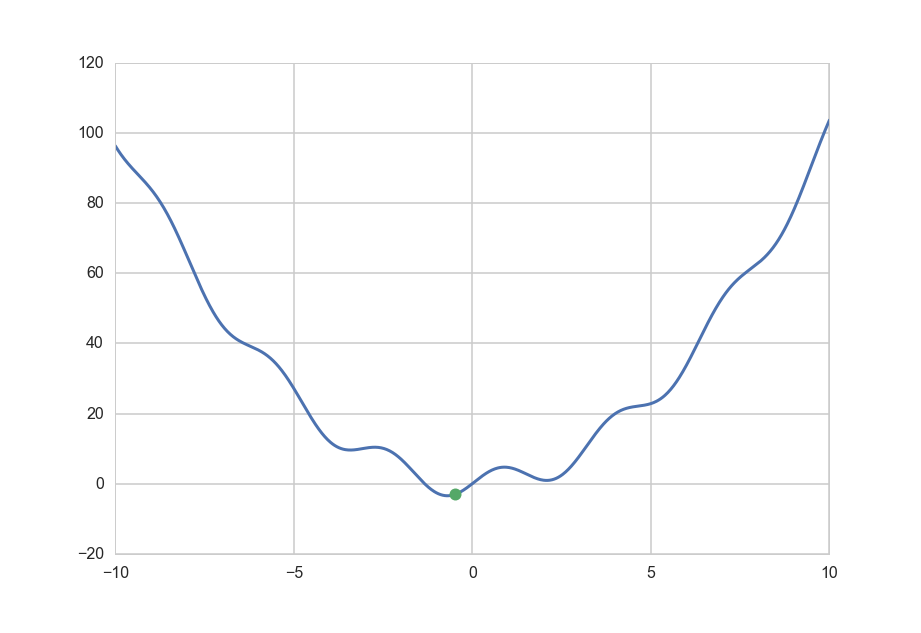
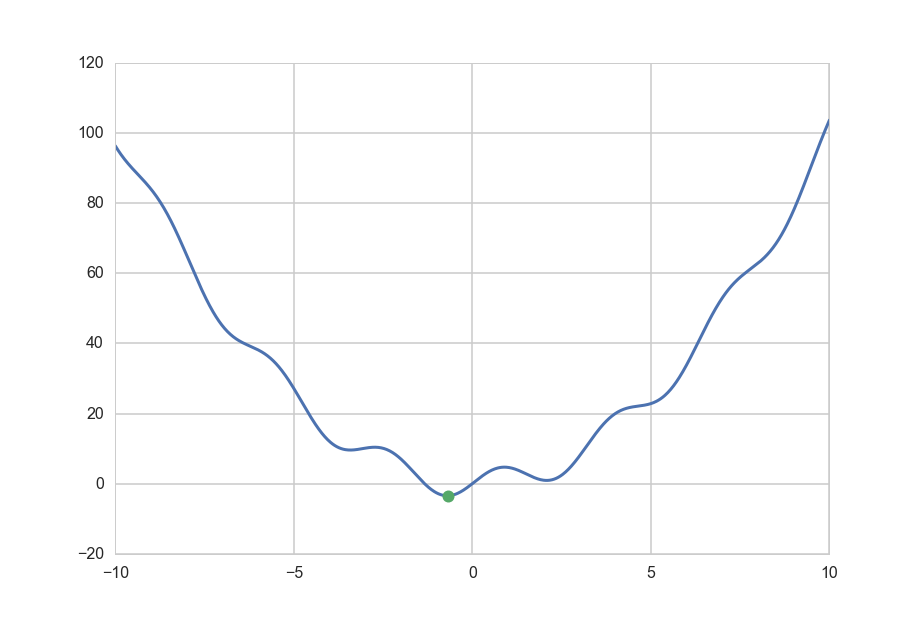
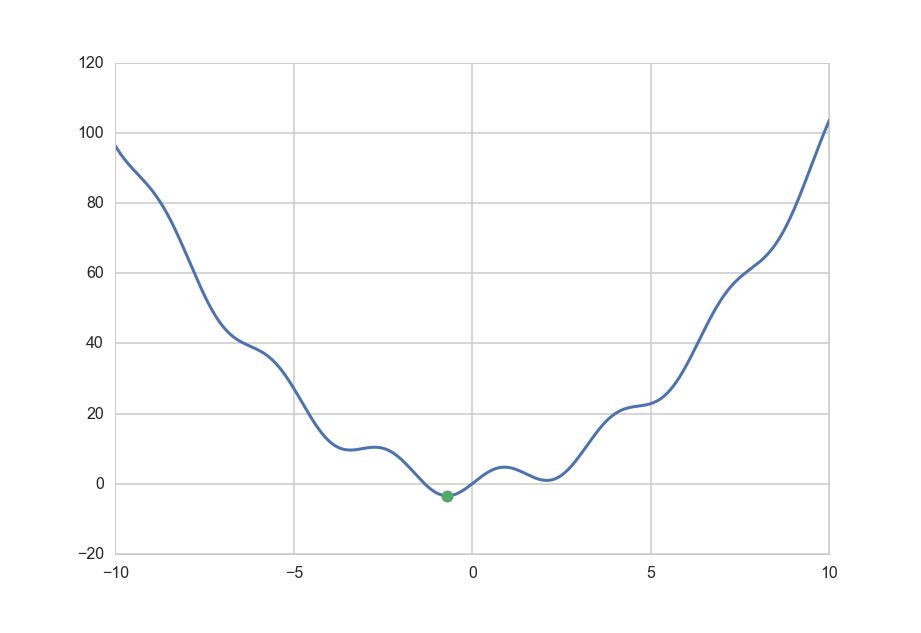
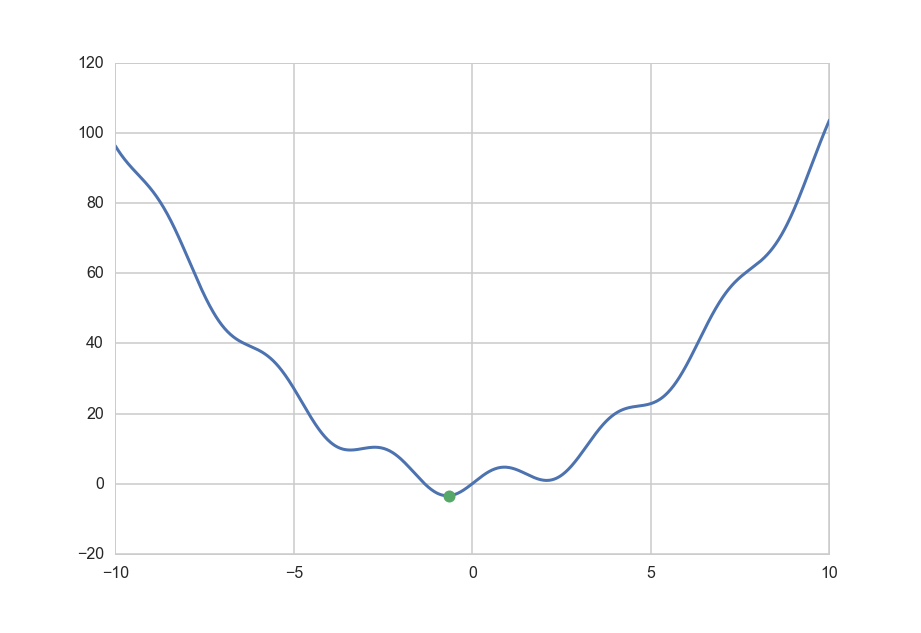
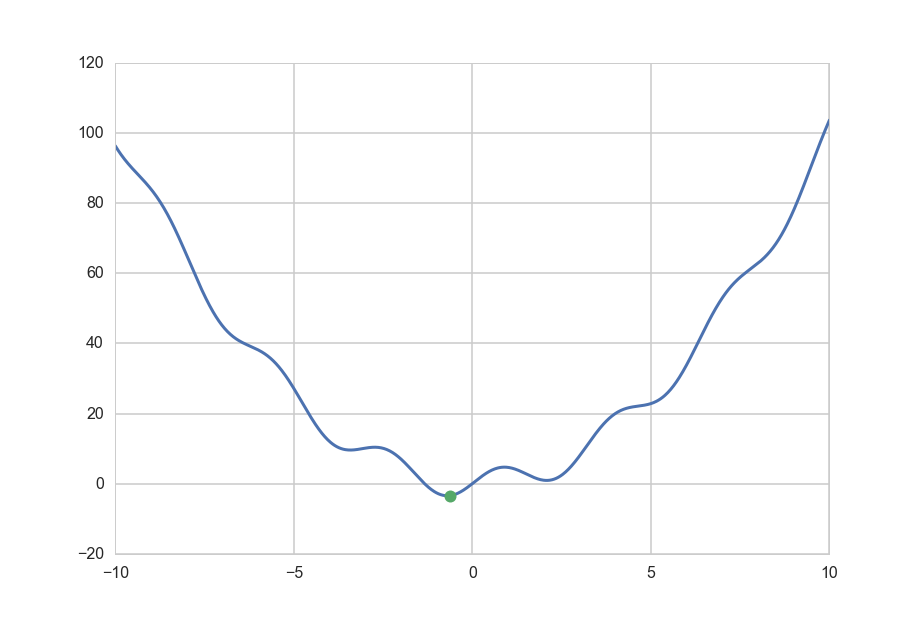
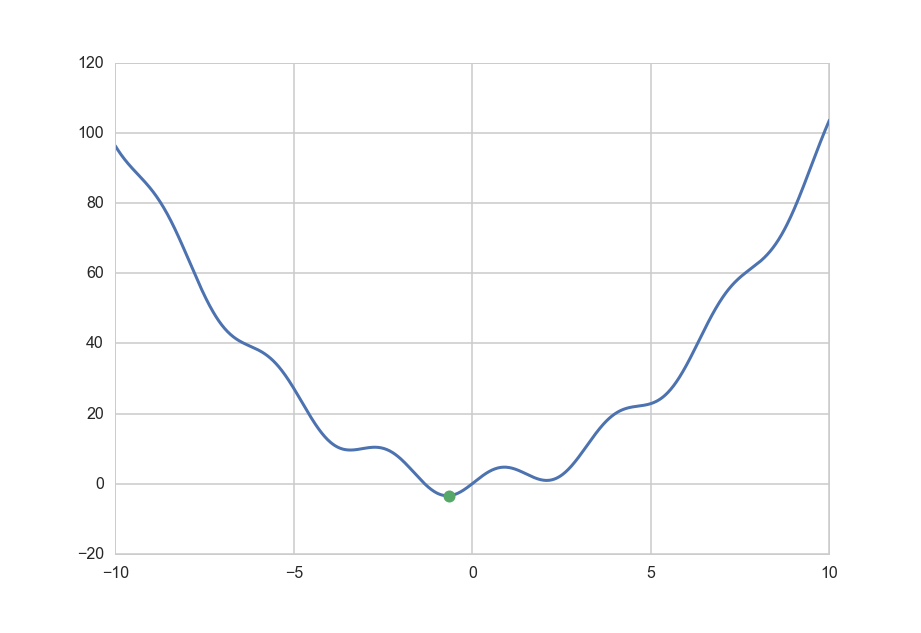
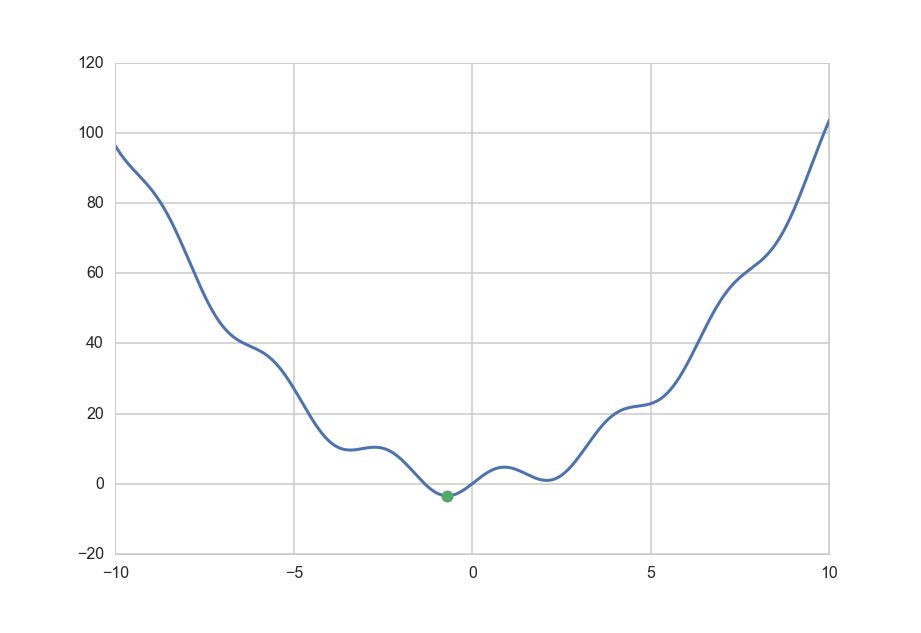
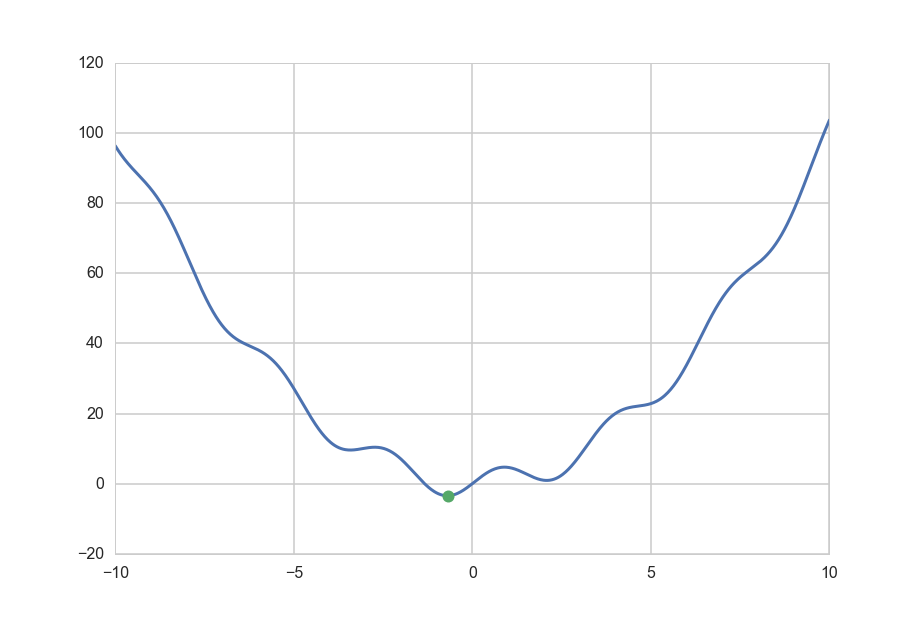
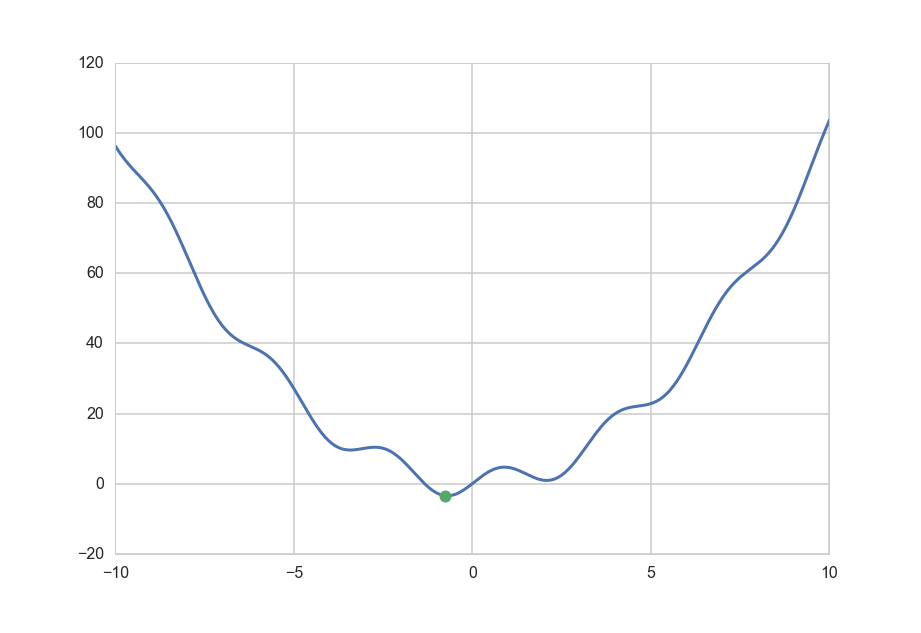
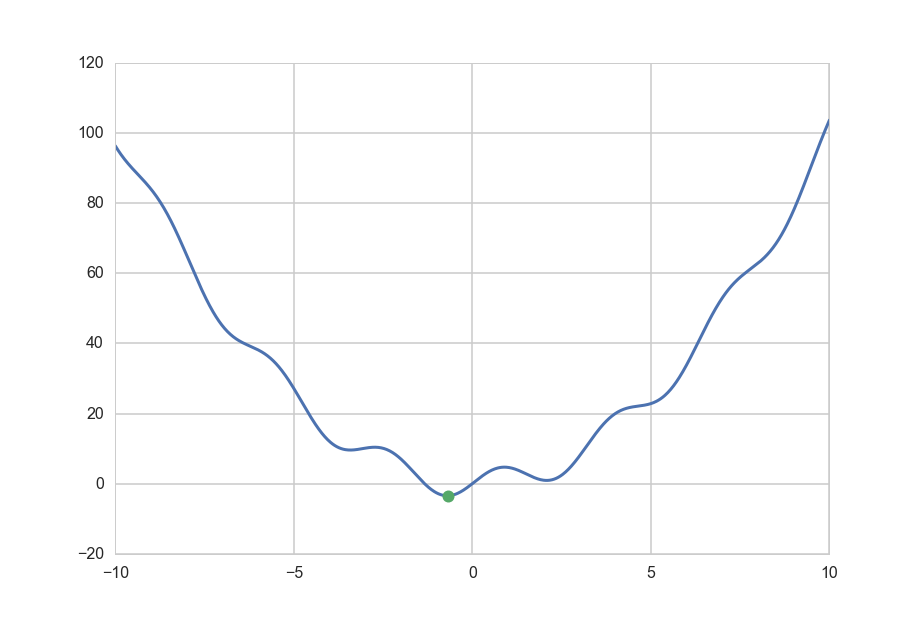
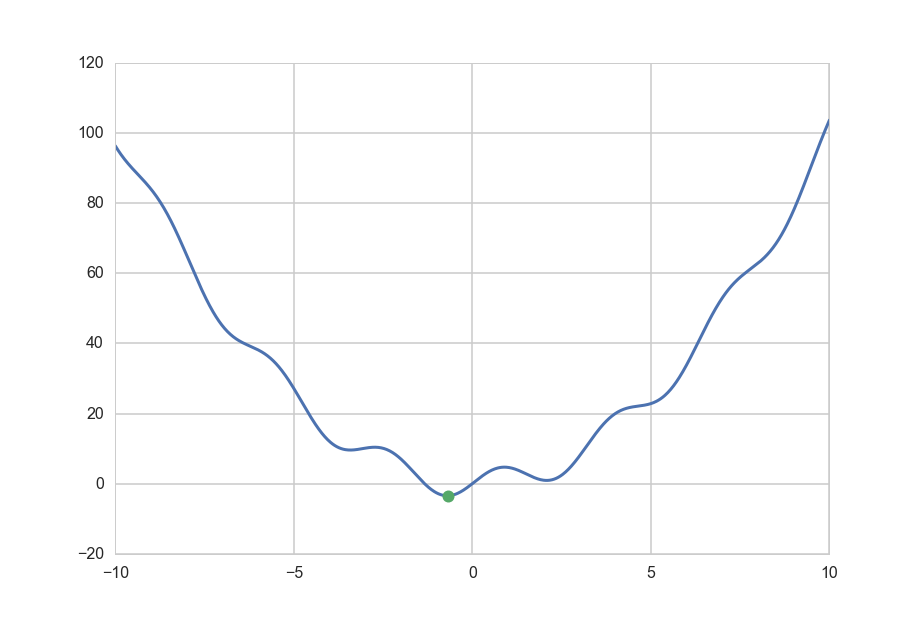
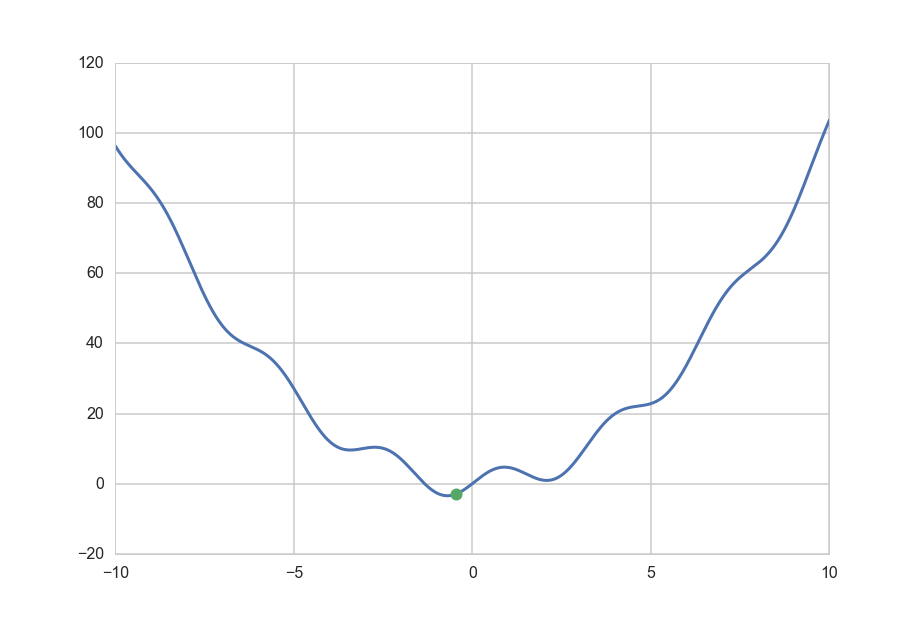
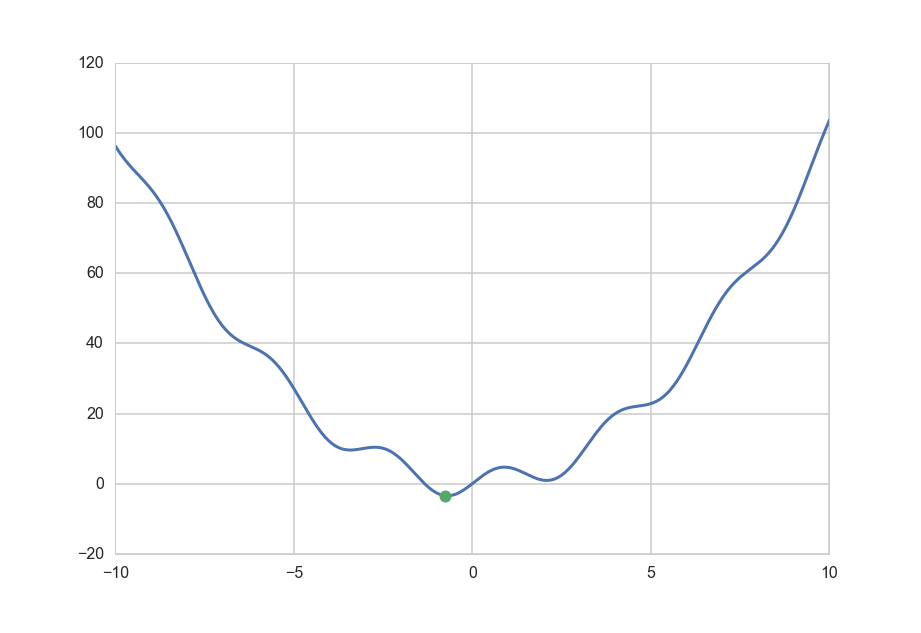
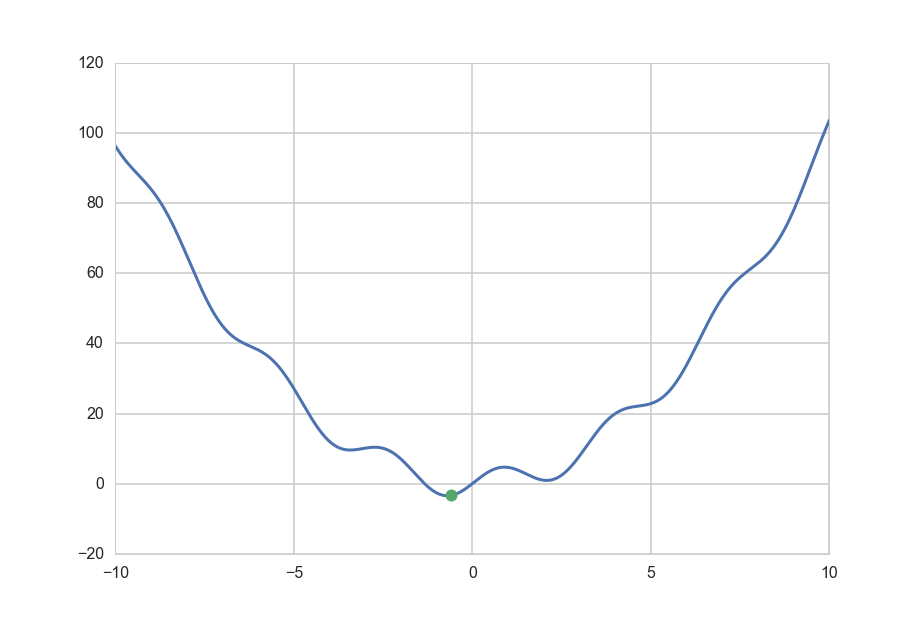
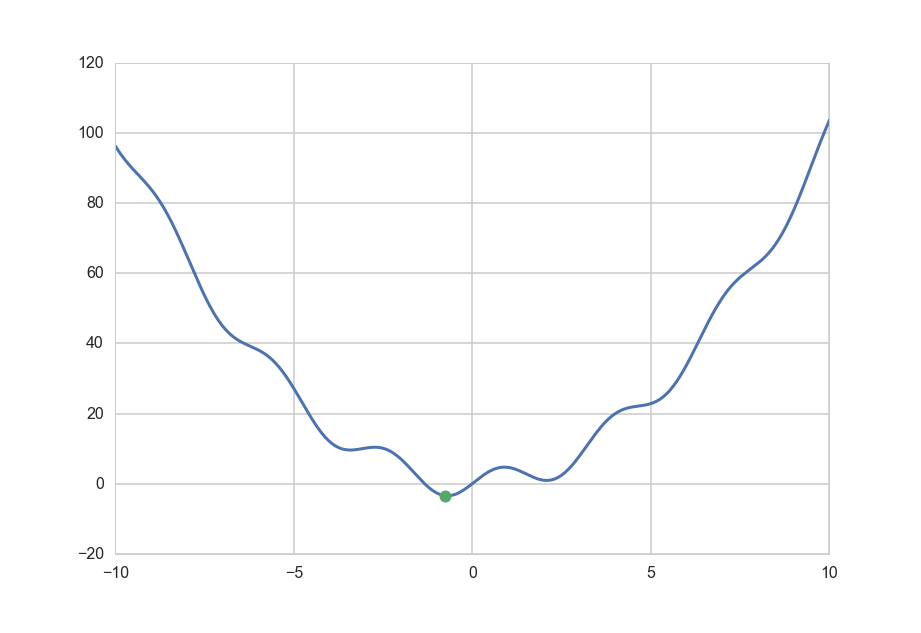
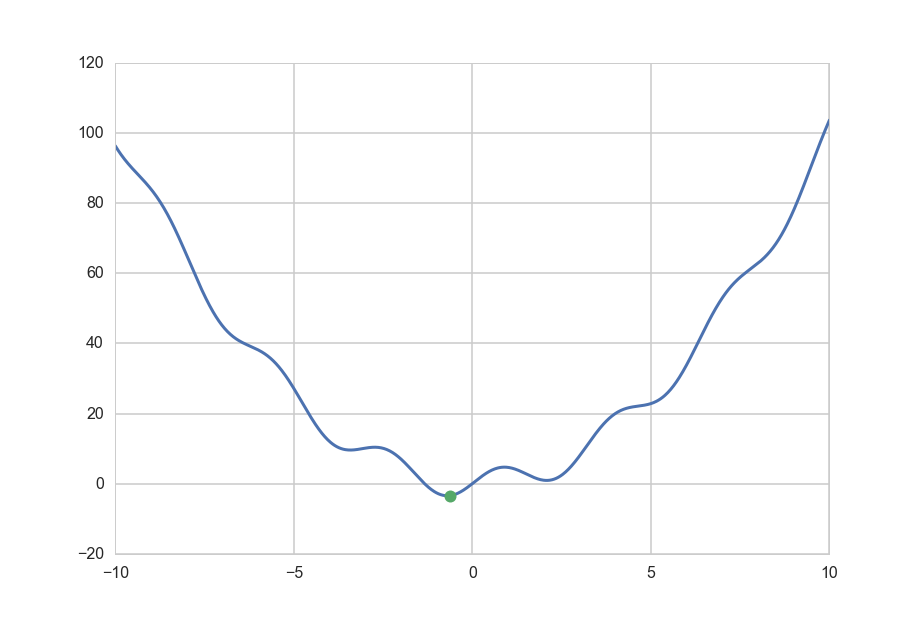
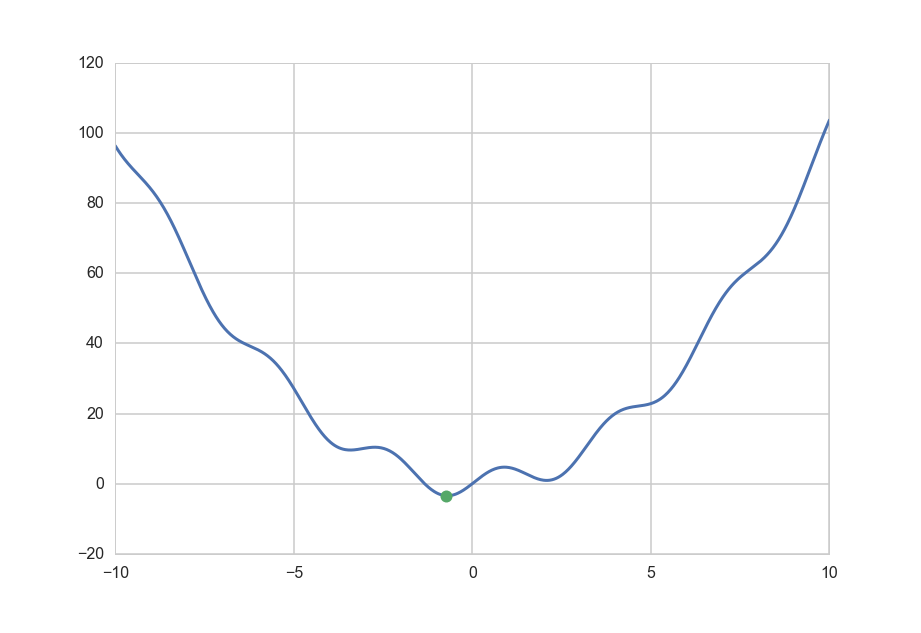
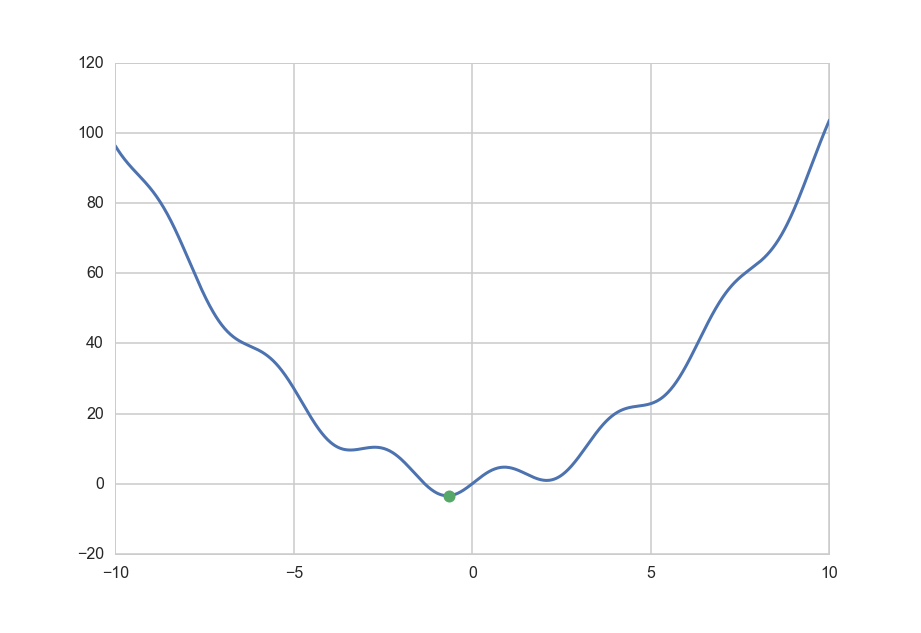
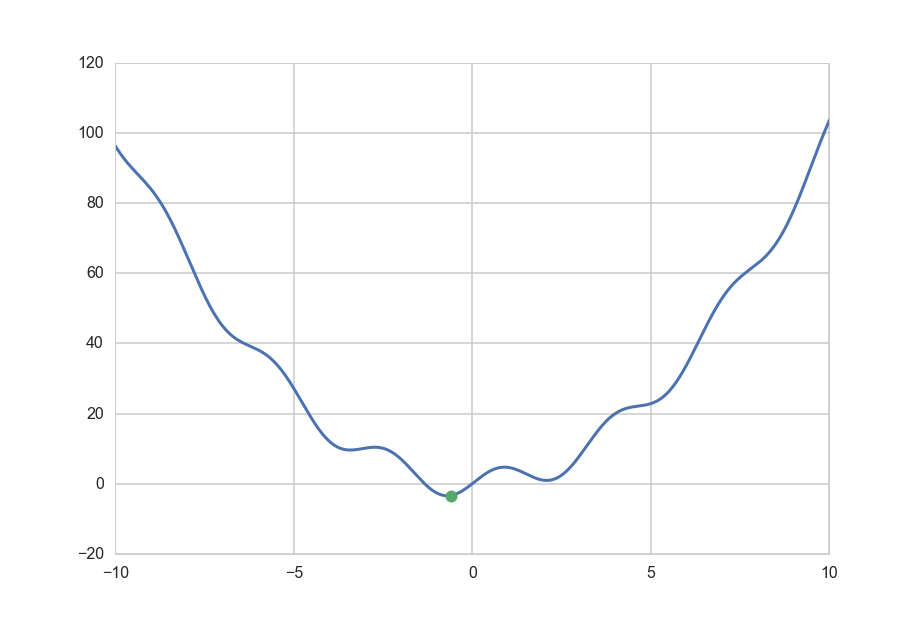
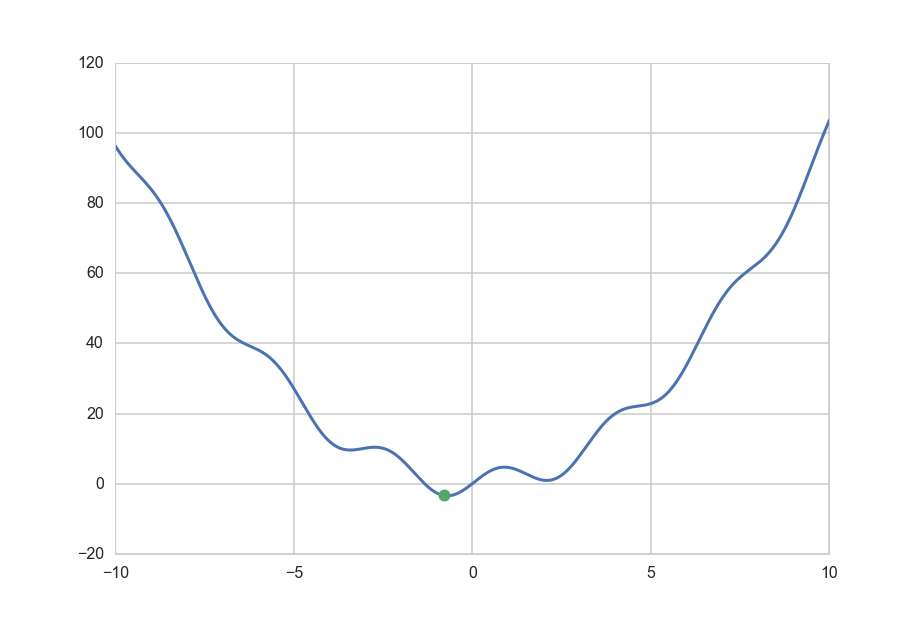
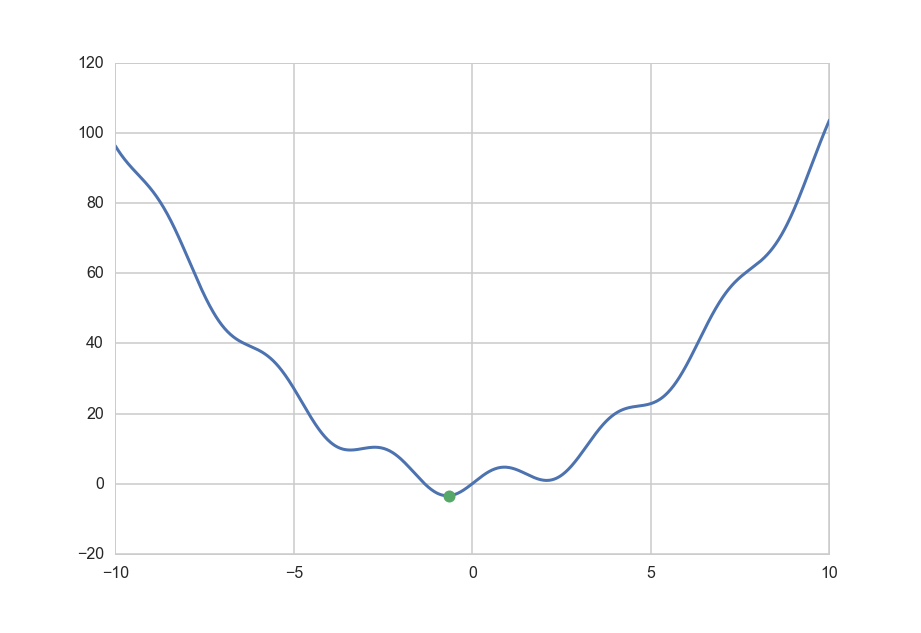
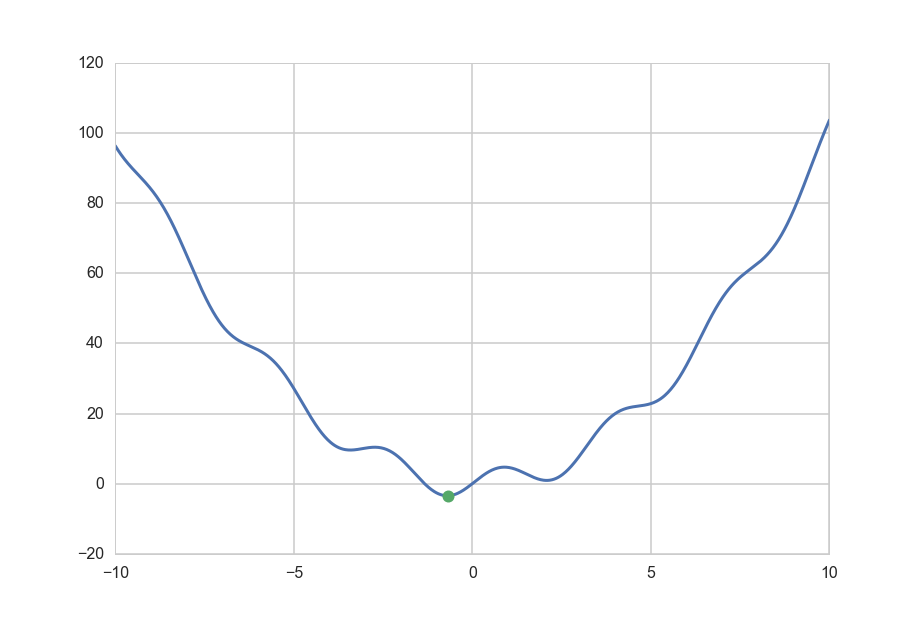
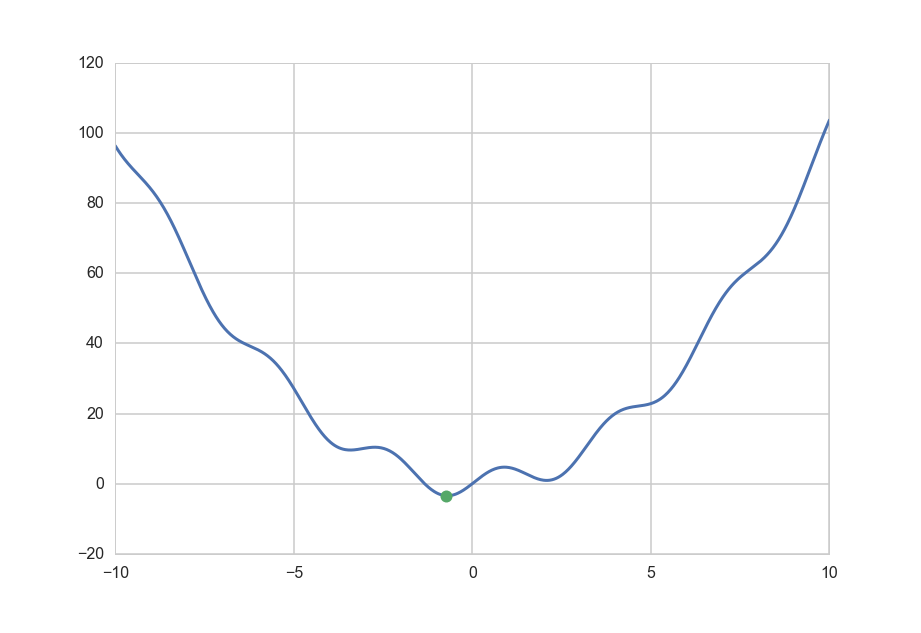
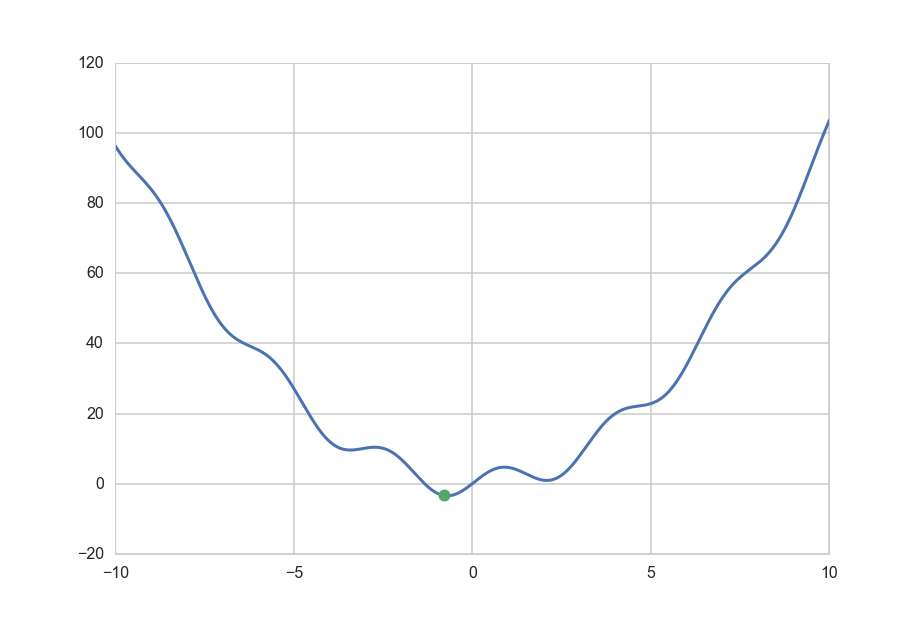
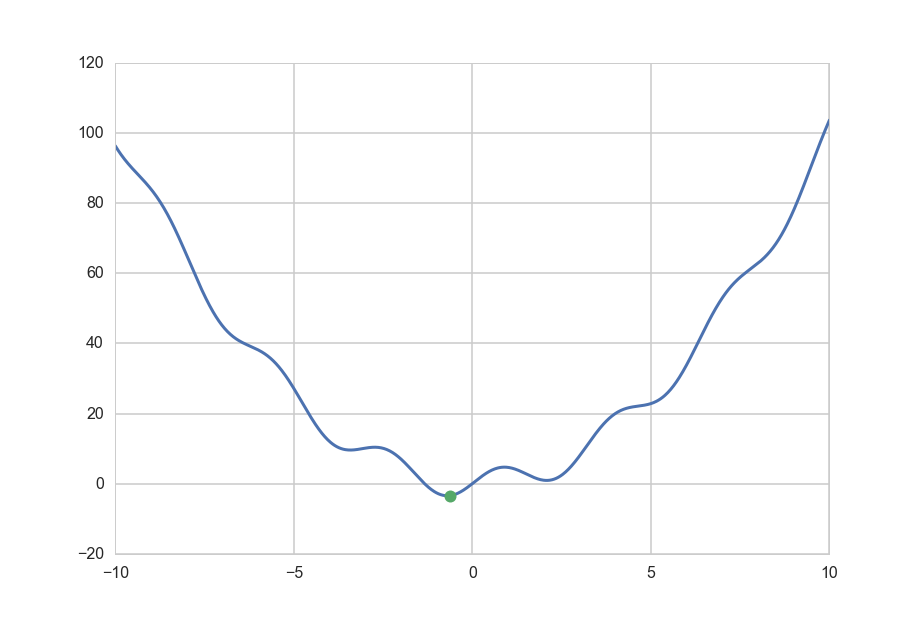
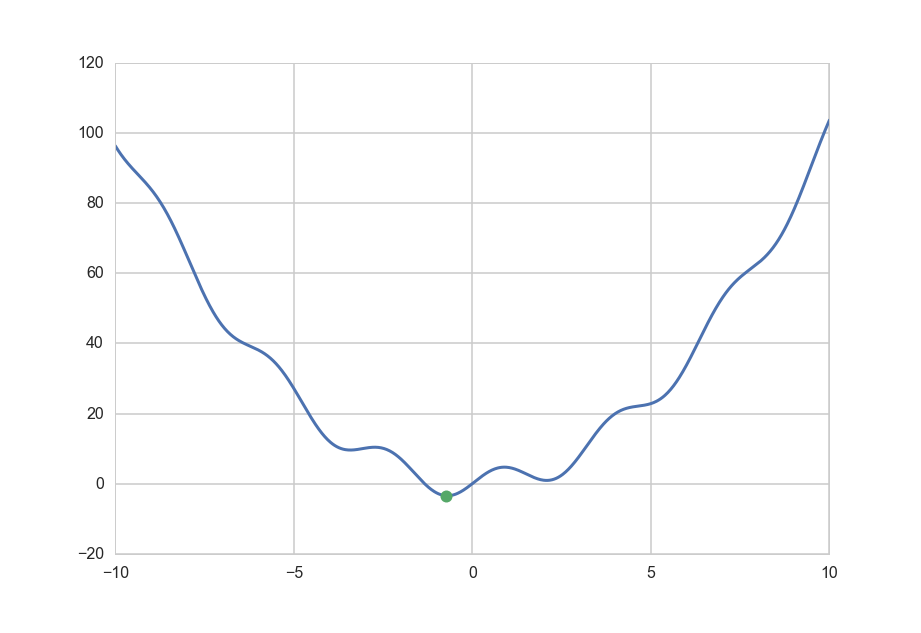
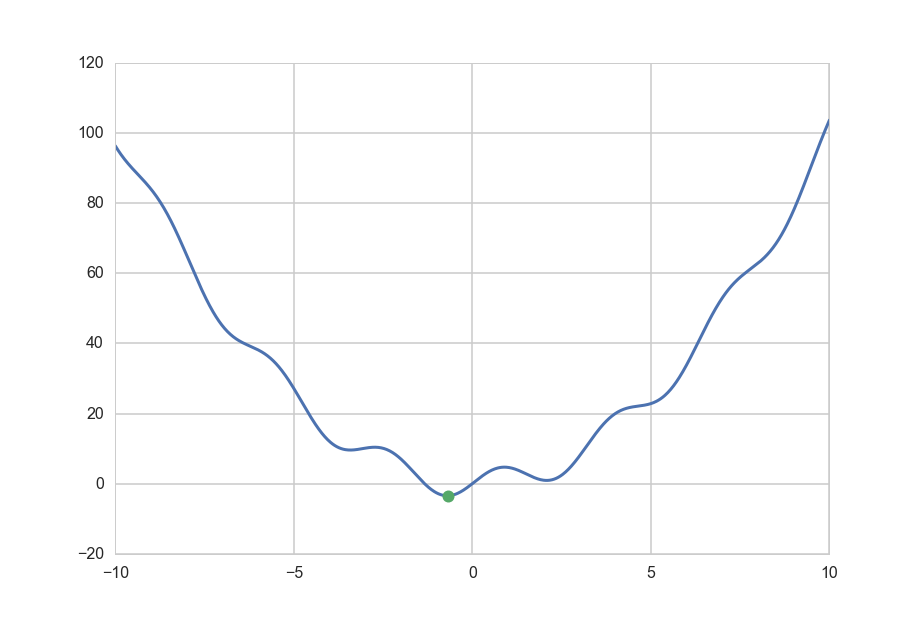
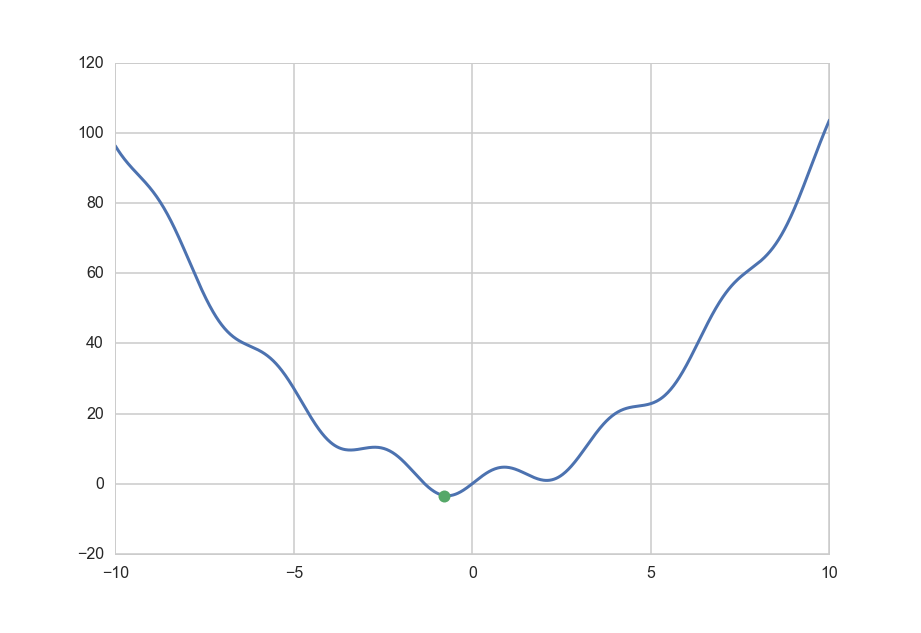
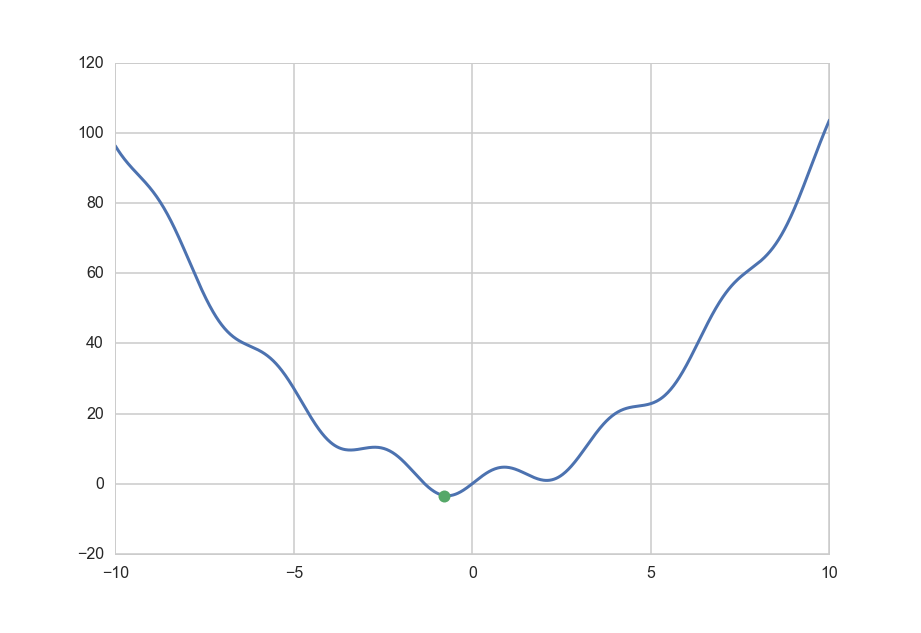
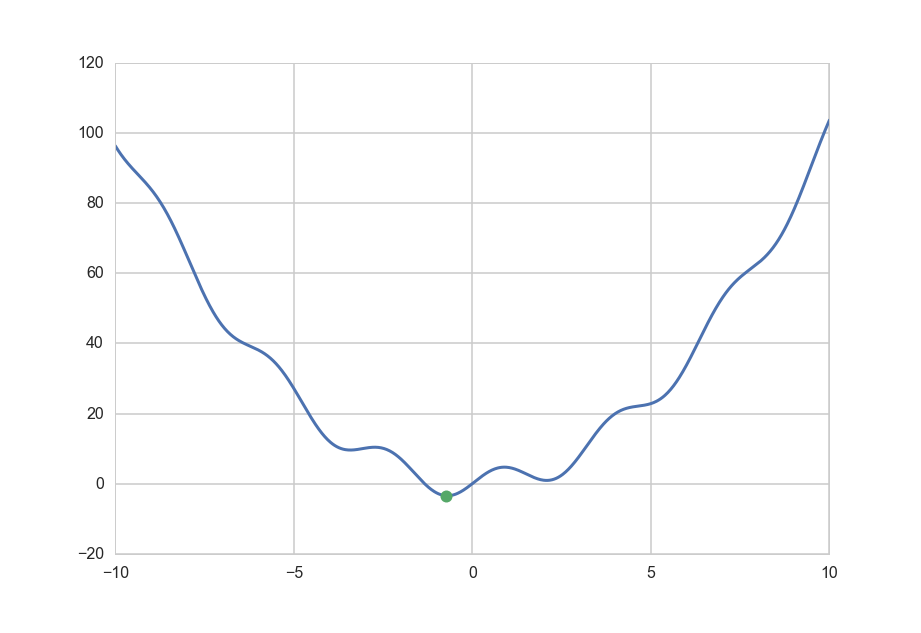
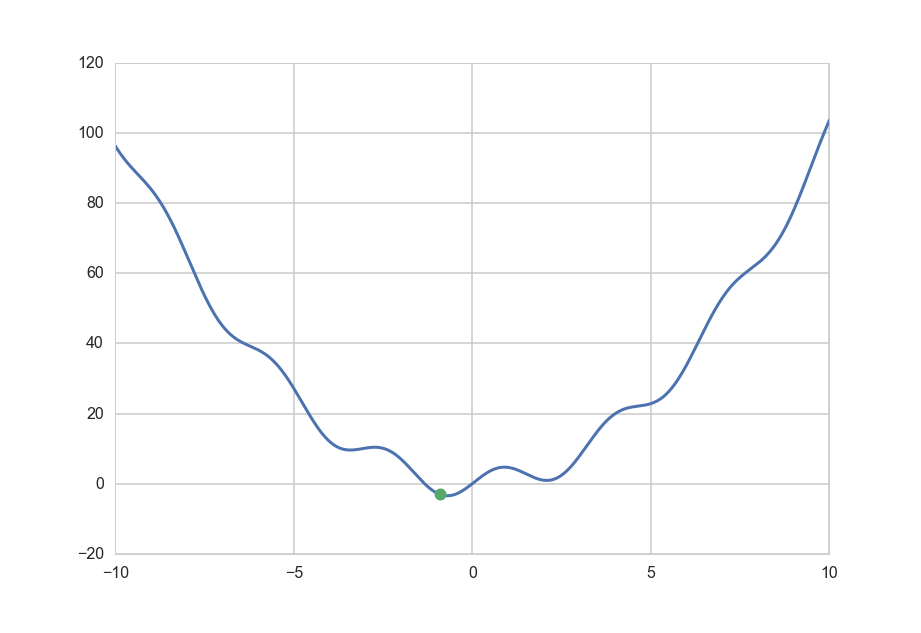
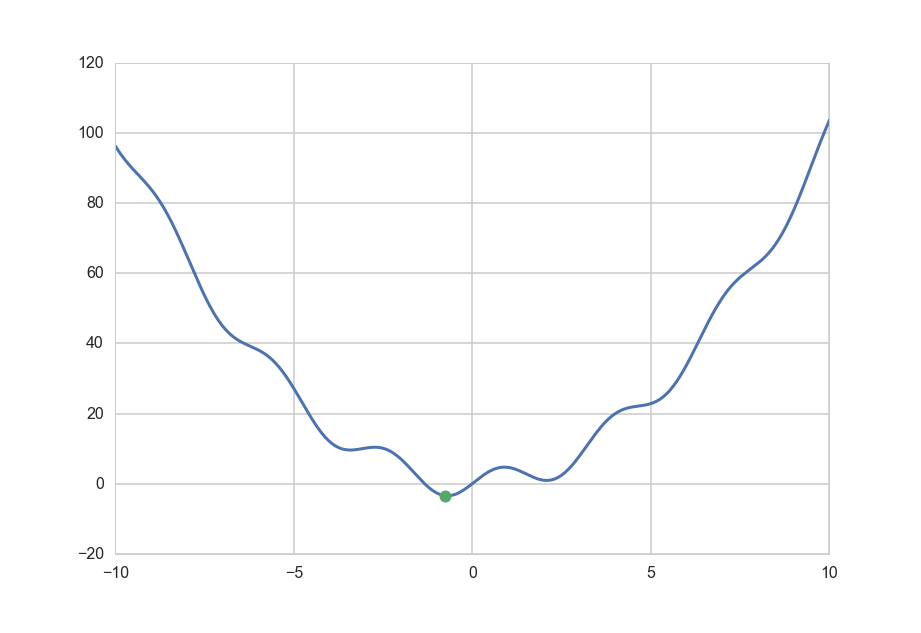
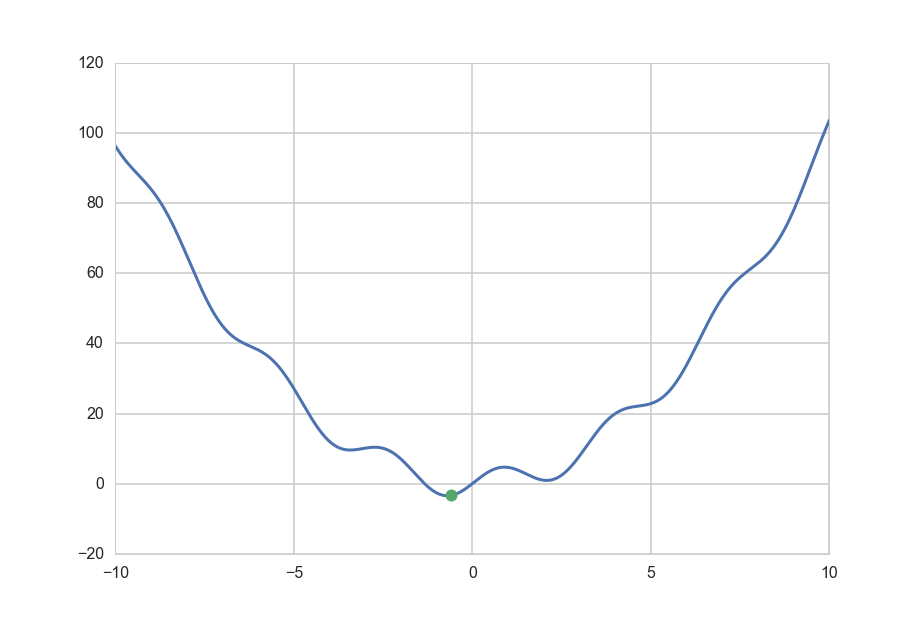
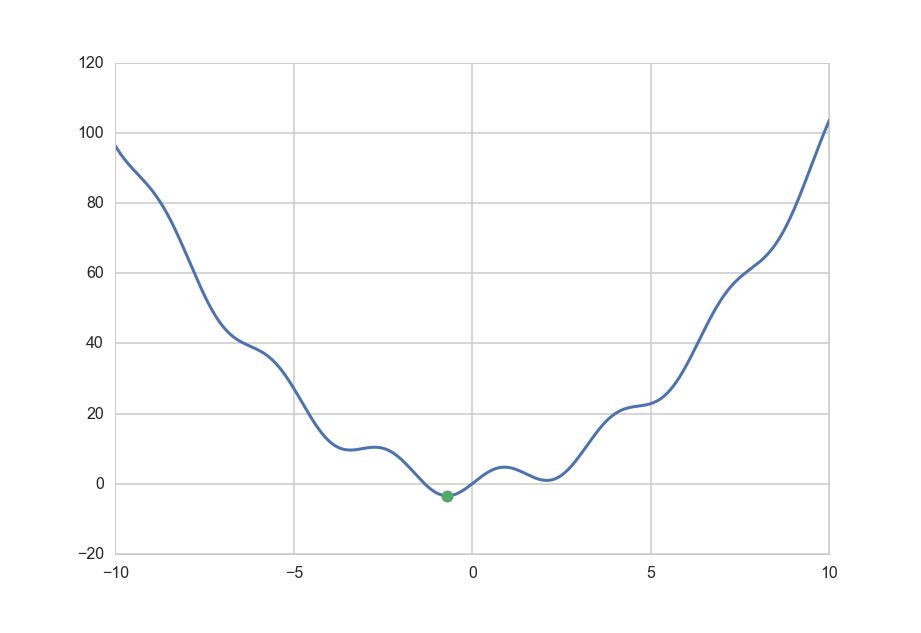
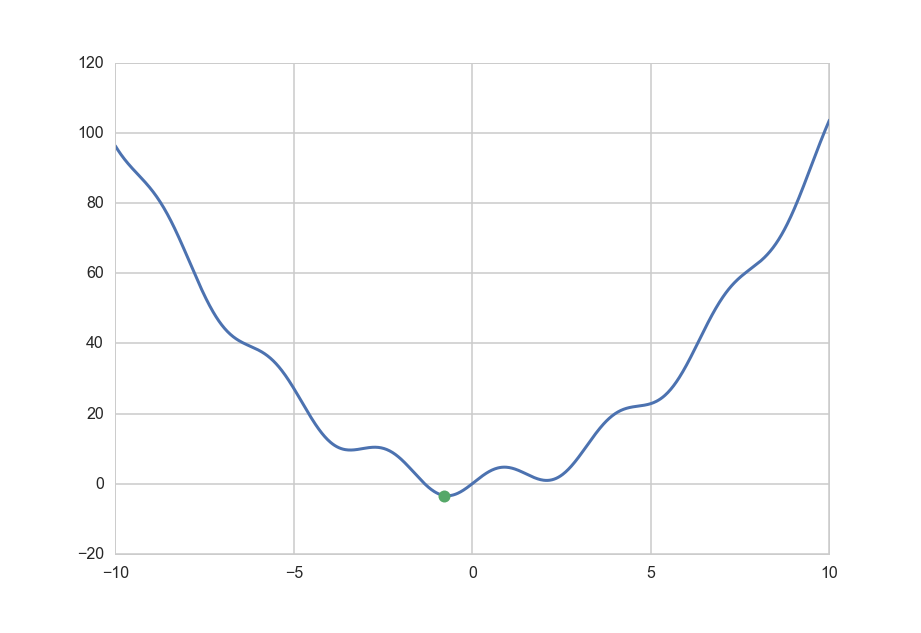
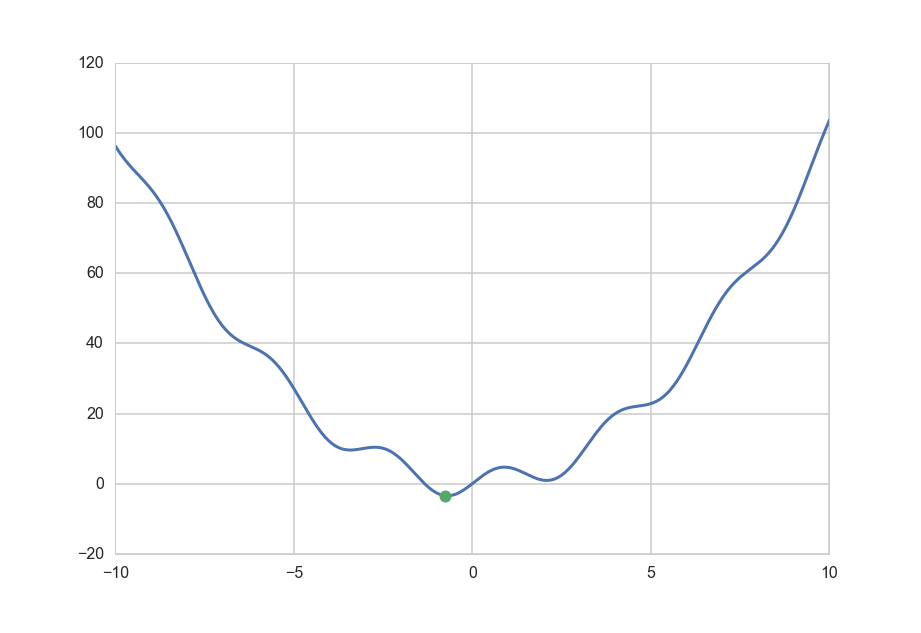
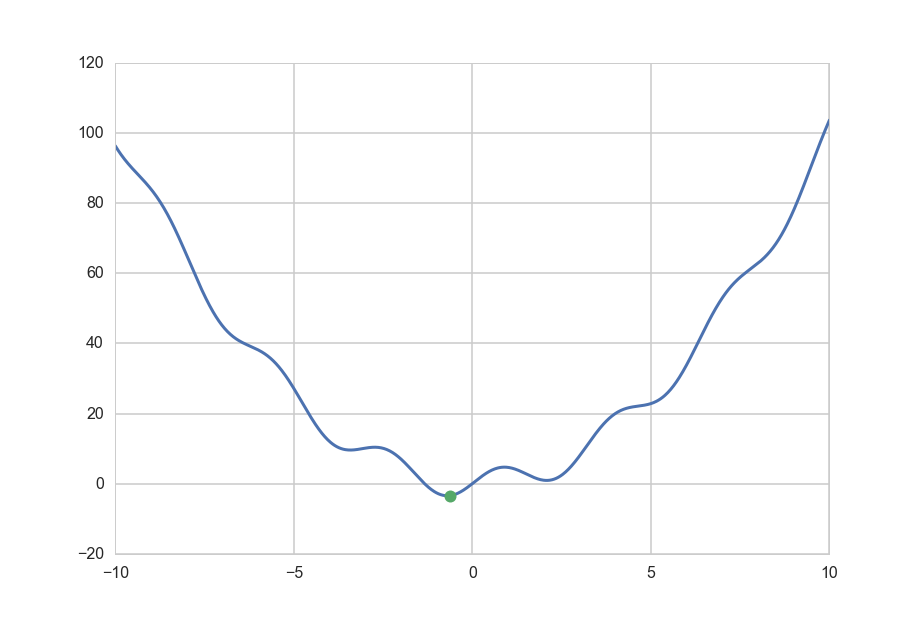
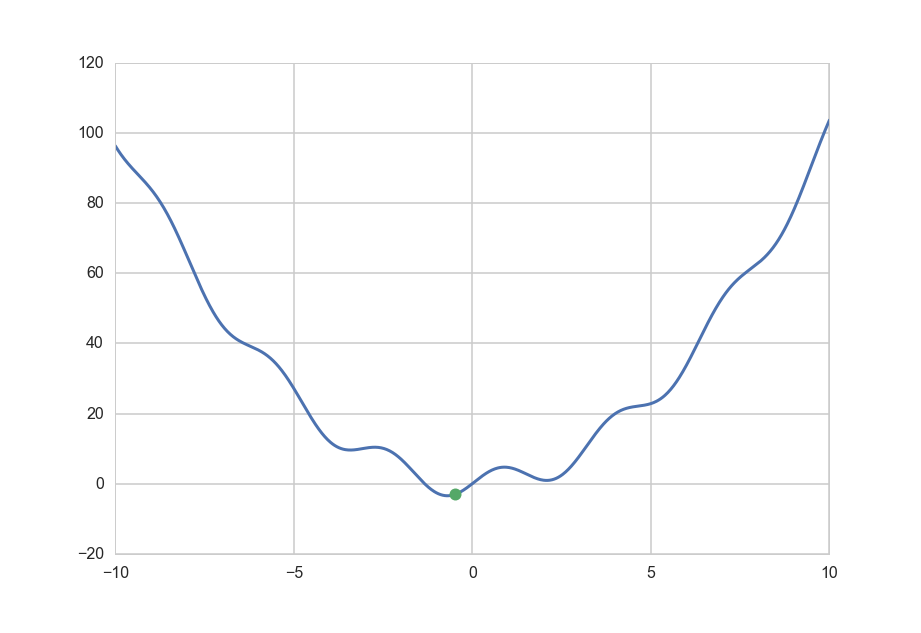
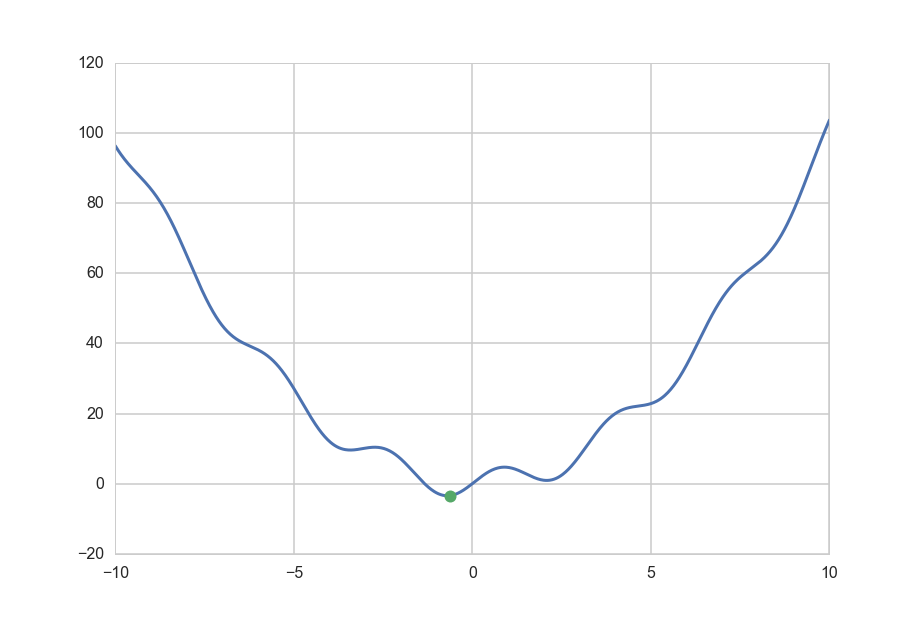
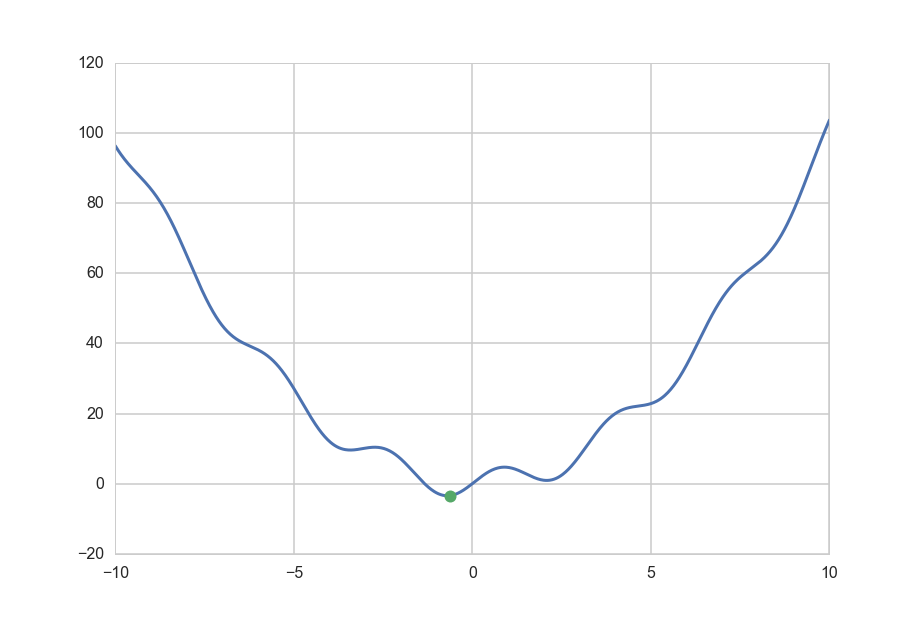
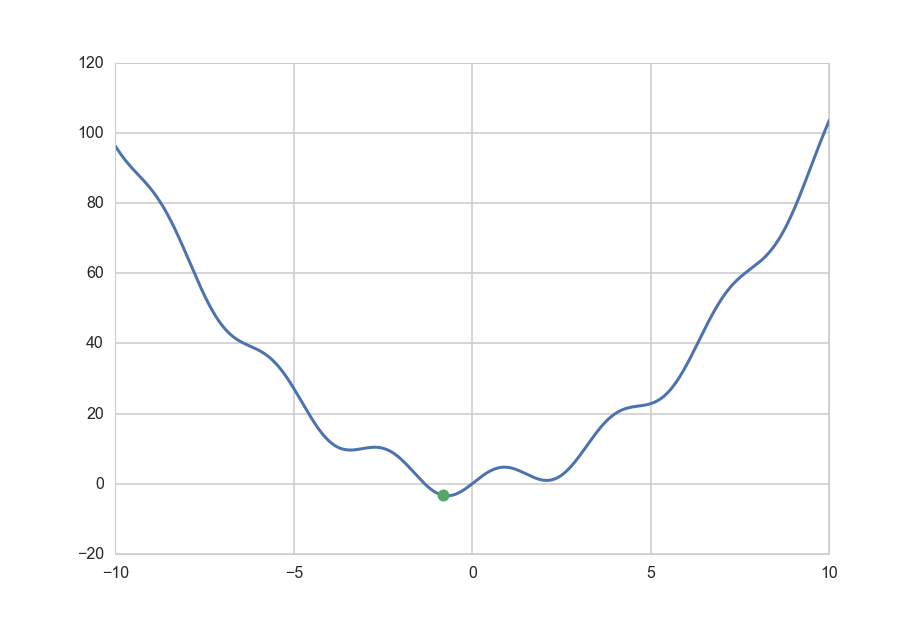
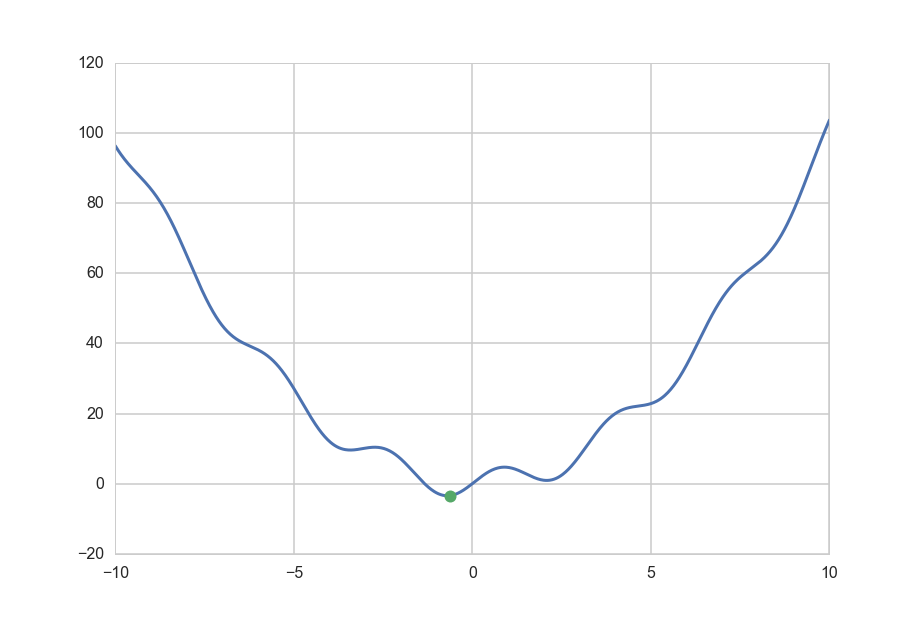
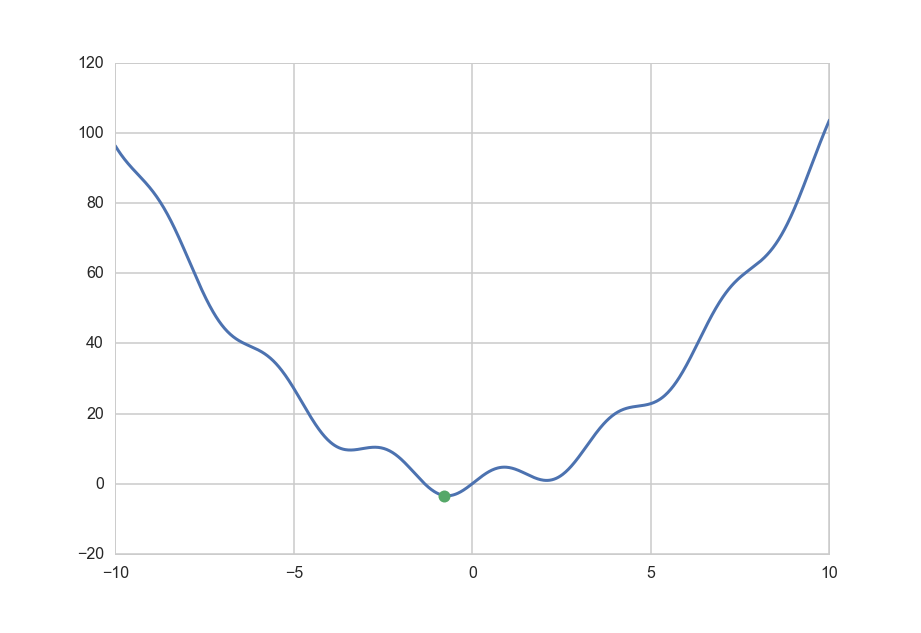
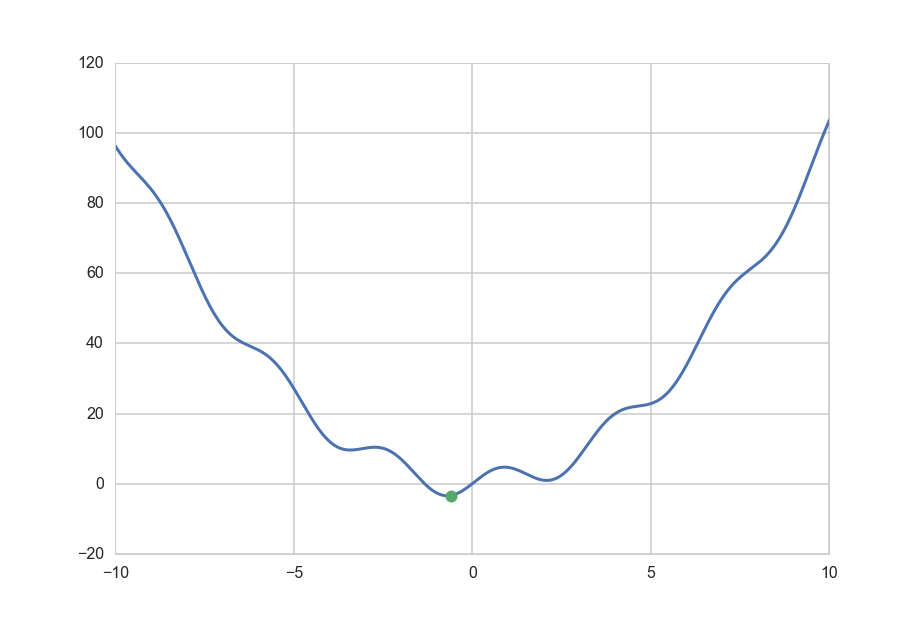

In [20]:
import matplotlib.animation as animation
from JSAnimation import IPython_display
fig = plt.figure()
ax = plt.axes()
fskip=1000
sols=[e[1] for e in out]
smallsols = sols[0:bmeta['index']:fskip]+sols[bmeta['index']::fskip//2]
xdatafn = lambda i, fskip: smallsols[i]
ydatafn = lambda i: f(xdatafn(i, fskip))
i, a = animator(f, xs, xdatafn, ydatafn, fskip, ax)
anim = animation.FuncAnimation(fig, a, init_func=i,
                        frames=len(smallsols), interval=300)
anim.save('images/sa1.mp4')
anim

## Practical Choices

*  Start with temperature $T_0$ large enough to accept all transitions. Its working against $\Delta E$, so should be at-least a bit higher than it.
* The proposal step size should lead to states with similar energy. This would exclude many bad steps
*  Lowering temperature schedule (thermostat). Common choices are
    1. Linear: Temperature decreases as  $T_{k+1} = \alpha T_k$. Typical values are $0.8 < \alpha < 0.99$. $k$ indexes epochs.
    2. Exponential: Temperature decreases as $0.95^{{\rm k}}$
    3. Logarithmic: Temperature decreases as $1/\log({\rm k})$
* Reannealing interval, or epoch length is the number of points to accept before reannealing (change the temperature). Typical starting value is 100, and you want to increase it as  $L_{k+1} = \beta L_k$ where $\beta > 1$.
* Larger decreases in temperature require correspondingly longer epoch lengths to re-equilibriate
* Running long epochs at larger temperatures is not very useful. In most problems local minima can be jumped over even at low temperatures. Thus it may be useful to decrease temperature rapidly at first.
* Stopping criterion
    1. Max iterations bounds the number of iterations the algorithm takes
    2. Function tolerance. The algorithm stops if the average change in the objective function after  $m$ iterations is below user specified tolerance
    3. Objective limit. The algorithm stops if the objective function goes below some value 
    
- It can be shown (although this is too slow a bound) that convergence to a set of global maxima is assured for $T_i = 1/(Clog(i + T_0))$ where $C$ and $T_0$ are problem dependent. The usual interpretation is that $C$ is the height of the tallest local minimum.
- Sometimes reheating is useful to explore new areas.

## Combinatoric optimization

Simulated annealing is particularly good at dealing with combinatoric optimization problems, like the travelling salesman problem, where you must find an optimal tour for the salesman between different cities based on the distance he travels.

Its a bit depressing to realize that an entire class of algorithms such as gradient descent arenot useful for such problems. The configuration space that you are minimizing over is not continuous, and these problems tend to take a lot of time to solve.

In such a case, a solution corresponds to a particular order of cities, which can be represented as links between the cities. A proposal might be two sever two non-adjacent links and swap them. You would then re-calculate the distance, which is your energy. The process repeats until you find an optimal tour.